## Analisis Rekomendasi Pendekatan Klasik
Rekomendasi yang Anda berikan sudah cukup komprehensif untuk perbandingan dengan YOLOv8-OBB. Kombinasi HOG + GLCM + Color Histogram sangat tepat karena:

HOG - Menangkap bentuk geometris logo halal yang khas
GLCM - Mengekstrak pola tekstur yang konsisten pada logo
Color Histogram (HSV) - Penting karena logo halal memiliki warna dominan hijau
Namun, saya sarankan menambahkan:

Shape Descriptors (Hu Moments) untuk invariansi rotasi
Local Binary Patterns (LBP) sebagai alternatif tekstur yang lebih cepat

## Struktur Program yang Akan Dibuat

/content/drive/MyDrive/Machine-Learning-Experiment/

├── datasets/

│   └── namaikna-plrqq-3/  (dataset dari Roboflow)

├── results/

│   └── 4_Ekstraksi_Fitur_Klasik/

│       ├── extracted_features.pkl

│       ├── SVM/

│       ├── RandomForest/

│       ├── XGBoost/

│       └── KNN/

└── notebooks/

    └── analysis_only.ipynb (untuk analisis hasil)

#**MACHINE LEARNING (Pendekatan Klasik)**

## 1: Setup Awal & Mount Google Drive

In [ ]:
# ========================================
# CELL 1: Mount Google Drive & Setup Path
# ========================================

from google.colab import drive
import os
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Setup base directory
BASE_DIR = '/content/drive/MyDrive/Machine-Learning-Experiment'
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
CLASSIC_FEATURES_DIR = os.path.join(RESULTS_DIR, '4_Ekstraksi_Fitur_Klasik')

# Buat struktur folder
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CLASSIC_FEATURES_DIR, exist_ok=True)

print("✅ Google Drive berhasil di-mount!")
print(f"📁 Base Directory: {BASE_DIR}")
print(f"📁 Dataset Directory: {DATASET_DIR}")
print(f"📁 Results Directory: {RESULTS_DIR}")
print(f"📁 Classic Features Directory: {CLASSIC_FEATURES_DIR}")

# Verifikasi folder
if os.path.exists(BASE_DIR):
    print("\n✅ Struktur folder berhasil dibuat!")
else:
    print("\n❌ Error: Gagal membuat struktur folder!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive berhasil di-mount!
📁 Base Directory: /content/drive/MyDrive/Machine-Learning-Experiment
📁 Dataset Directory: /content/drive/MyDrive/Machine-Learning-Experiment/datasets
📁 Results Directory: /content/drive/MyDrive/Machine-Learning-Experiment/results
📁 Classic Features Directory: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik

✅ Struktur folder berhasil dibuat!


## 2: Download Dataset dari Roboflow

In [ ]:
# ========================================
# CELL 2: Install Dependencies & Download Dataset
# ========================================

# Install library yang diperlukan
!pip install -q roboflow scikit-learn xgboost scikit-image statsmodels

import yaml
import os
import shutil

print("🔽 Memulai download dataset dari Roboflow...")

try:
    # Import Roboflow
    from roboflow import Roboflow

    # Inisialisasi Roboflow dengan API key
    rf = Roboflow(api_key="x0vQ9jw1DL3u75BugD3m")

    # Akses workspace dan project
    print("🔗 Connecting to Roboflow project...")
    project = rf.workspace("product-0e1pd").project("namaikna-plrqq")

    # Gunakan version 2 sesuai dengan kode Anda
    version = project.version(2)

    # Change directory ke Google Drive untuk download
    original_dir = os.getcwd()
    os.chdir(DATASET_DIR)
    print(f"📂 Download location: {DATASET_DIR}")

    # Download dataset dengan format YOLOv8-OBB
    print("📥 Downloading dataset...")
    dataset = version.download("yolov8-obb")

    # Kembali ke directory original
    os.chdir(original_dir)

    # Dataset akan ter-download dengan nama "namaikna-plrqq-2" (karena version 2)
    # Cari folder yang baru di-download
    downloaded_folders = [f for f in os.listdir(DATASET_DIR)
                         if os.path.isdir(os.path.join(DATASET_DIR, f))
                         and 'namaikna' in f.lower()]

    print(f"\n📂 Found folders: {downloaded_folders}")

    if downloaded_folders:
        # Ambil folder pertama (yang baru di-download)
        dataset_folder_name = downloaded_folders[0]
        DATASET_PATH = os.path.join(DATASET_DIR, dataset_folder_name)

        print(f"✅ Dataset downloaded to: {DATASET_PATH}")

        # Verifikasi struktur folder
        print(f"\n🔍 Verifying dataset structure...")

        # Cek apakah ada folder train, valid, test
        required_splits = ['train', 'valid', 'test']
        all_splits_exist = all(os.path.exists(os.path.join(DATASET_PATH, split))
                              for split in required_splits)

        if all_splits_exist:
            print("✅ All required splits found (train, valid, test)")

            # Hitung jumlah file per split
            for split in required_splits:
                images_path = os.path.join(DATASET_PATH, split, 'images')
                labels_path = os.path.join(DATASET_PATH, split, 'labels')

                if os.path.exists(images_path):
                    num_images = len([f for f in os.listdir(images_path)
                                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
                    print(f"   📷 {split}/images: {num_images} files")

                if os.path.exists(labels_path):
                    num_labels = len([f for f in os.listdir(labels_path)
                                    if f.endswith('.txt')])
                    print(f"   🏷️  {split}/labels: {num_labels} files")
        else:
            print("⚠️  Warning: Some splits are missing")
            print(f"   Contents: {os.listdir(DATASET_PATH)}")

        # Load data.yaml untuk mendapatkan class names
        DATA_YAML_PATH = os.path.join(DATASET_PATH, 'data.yaml')

        if os.path.exists(DATA_YAML_PATH):
            print(f"\n✅ Loading class information from data.yaml...")

            with open(DATA_YAML_PATH, 'r') as f:
                data_yaml = yaml.safe_load(f)
                class_names = data_yaml['names']

            print(f"🏷️  Classes ({len(class_names)}):")
            for idx, name in class_names.items():
                print(f"   {idx}: {name}")

            print(f"\n✅ Download dan verifikasi berhasil!")
            print(f"📁 Dataset siap digunakan di: {DATASET_PATH}")

            # Simpan path untuk digunakan di cell selanjutnya
            print(f"\n💾 Saving dataset path...")
            with open(os.path.join(BASE_DIR, 'dataset_path.txt'), 'w') as f:
                f.write(DATASET_PATH)

        else:
            raise FileNotFoundError(f"File data.yaml tidak ditemukan di {DATASET_PATH}")

    else:
        raise FileNotFoundError("Dataset folder tidak ditemukan setelah download")

except Exception as e:
    print(f"\n❌ Error saat download dataset: {e}")

    import traceback
    print("\n📋 Full error traceback:")
    traceback.print_exc()

    print("\n💡 Troubleshooting:")
    print("1. Pastikan API key valid")
    print("2. Pastikan koneksi internet stabil")
    print("3. Pastikan Google Drive sudah di-mount")
    print("4. Coba jalankan ulang cell ini")

    # Tampilkan isi folder datasets
    print(f"\n📂 Current contents of {DATASET_DIR}:")
    if os.path.exists(DATASET_DIR):
        for item in os.listdir(DATASET_DIR):
            item_path = os.path.join(DATASET_DIR, item)
            item_type = "DIR" if os.path.isdir(item_path) else "FILE"
            print(f"   [{item_type}] {item}")
    else:
        print(f"   ❌ Directory tidak ditemukan: {DATASET_DIR}")

print("\n" + "="*60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 79.3 MB/s eta 0:00:00
🔽 Memulai download dataset dari Roboflow...
🔗 Connecting to Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
📂 Download location: /content/drive/MyDrive/Machine-Learning-Experiment/datasets
📥 Downloading dataset...

📂 Found folders: ['namaikna-2']
✅ Dataset downloaded to: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2

🔍 Verifying dataset structure...
✅ All required splits found (train, valid, test)
   📷 train/images: 798 files
   🏷️  train/labels: 798 files
   📷 valid/images: 228 files
   🏷️  valid/labels: 228 files
   📷 test/images: 113 files
   🏷️  

## 3: Setup & Ekstraksi Fitur

In [ ]:
# ========================================
# CELL 3: Import Libraries & Setup
# ========================================

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from tqdm import tqdm
from datetime import datetime

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings('ignore')

# Setup plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Buat subfolder untuk setiap model
MODELS = ['SVM', 'RandomForest', 'XGBoost', 'KNN']
for model_name in MODELS:
    model_dir = os.path.join(CLASSIC_FEATURES_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)
    print(f"✅ Folder {model_name} berhasil dibuat")

print("\n🎯 Setup selesai! Siap untuk ekstraksi fitur.")

✅ Folder SVM berhasil dibuat
✅ Folder RandomForest berhasil dibuat
✅ Folder XGBoost berhasil dibuat
✅ Folder KNN berhasil dibuat

🎯 Setup selesai! Siap untuk ekstraksi fitur.


In [ ]:
# ========================================
# CELL 4: Fungsi Ekstraksi Fitur
# ========================================

def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """Ekstraksi fitur HOG untuk menangkap bentuk dan tepi"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    features = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block, visualize=False, feature_vector=True)
    return features

def extract_glcm_features(image, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Ekstraksi fitur GLCM untuk analisis tekstur"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray = (gray * 255).astype(np.uint8) if gray.max() <= 1 else gray

    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    features = []
    for prop in properties:
        feature = graycoprops(glcm, prop).flatten()
        features.extend(feature)

    return np.array(features)

def extract_color_histogram(image, bins=32):
    """Ekstraksi histogram warna HSV - penting untuk logo halal hijau"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])

    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    return np.concatenate([hist_h, hist_s, hist_v])

def extract_lbp_features(image, numPoints=24, radius=3):
    """Local Binary Patterns untuk tekstur lokal"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    lbp = local_binary_pattern(gray, numPoints, radius, method='uniform')

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_hu_moments(image):
    """Hu Moments untuk shape descriptor yang invariant terhadap rotasi"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    return hu_moments

def extract_edge_features(image):
    """Ekstraksi fitur tepi menggunakan Canny dan Sobel"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Canny edge detection
    edges_canny = cv2.Canny(gray, 50, 150)
    canny_density = np.sum(edges_canny > 0) / edges_canny.size

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_mean = np.mean(sobel_magnitude)
    sobel_std = np.std(sobel_magnitude)

    return np.array([canny_density, sobel_mean, sobel_std])

def extract_all_features(image_path, target_size=(128, 128)):
    """Ekstraksi semua fitur dari satu gambar"""
    image = cv2.imread(image_path)
    if image is None:
        return None

    image_resized = cv2.resize(image, target_size)

    features = []

    # 1. HOG features
    hog_feat = extract_hog_features(image_resized)
    features.extend(hog_feat)

    # 2. GLCM features
    glcm_feat = extract_glcm_features(image_resized)
    features.extend(glcm_feat)

    # 3. Color histogram
    color_hist = extract_color_histogram(image_resized)
    features.extend(color_hist)

    # 4. LBP features
    lbp_feat = extract_lbp_features(image_resized)
    features.extend(lbp_feat)

    # 5. Hu moments
    hu_feat = extract_hu_moments(image_resized)
    features.extend(hu_feat)

    # 6. Edge features
    edge_feat = extract_edge_features(image_resized)
    features.extend(edge_feat)

    return np.array(features)

def read_yolo_obb_labels(label_path):
    """Membaca label dari file YOLO OBB format"""
    if not os.path.exists(label_path):
        return []

    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 9:
                labels.append(int(parts[0]))
    return labels

print("✅ Fungsi ekstraksi fitur berhasil didefinisikan!")

✅ Fungsi ekstraksi fitur berhasil didefinisikan!


In [ ]:
# ========================================
# CELL 4b: Load Dataset Path
# ========================================

import os

# Load dataset path yang sudah disimpan
dataset_path_file = os.path.join(BASE_DIR, 'dataset_path.txt')

if os.path.exists(dataset_path_file):
    with open(dataset_path_file, 'r') as f:
        DATASET_PATH = f.read().strip()

    print(f"✅ Dataset path loaded: {DATASET_PATH}")

    # Verifikasi path masih valid
    if os.path.exists(DATASET_PATH):
        print(f"✅ Dataset path is valid")

        # Load data.yaml
        DATA_YAML_PATH = os.path.join(DATASET_PATH, 'data.yaml')

        if os.path.exists(DATA_YAML_PATH):
            import yaml
            with open(DATA_YAML_PATH, 'r') as f:
                data_yaml = yaml.safe_load(f)
                class_names = data_yaml['names']

            print(f"🏷️  Classes: {class_names}")
            print(f"\n✅ Dataset siap untuk ekstraksi fitur!")
        else:
            print(f"❌ data.yaml tidak ditemukan di {DATASET_PATH}")
    else:
        print(f"❌ Dataset path tidak valid: {DATASET_PATH}")

else:
    print(f"❌ Dataset path file tidak ditemukan: {dataset_path_file}")
    print("\n💡 Silakan jalankan CELL 2 terlebih dahulu untuk download dataset")

    # Coba cari secara manual
    print("\n🔍 Mencari dataset secara manual...")
    if os.path.exists(DATASET_DIR):
        dataset_folders = [f for f in os.listdir(DATASET_DIR)
                          if os.path.isdir(os.path.join(DATASET_DIR, f))
                          and 'namaikna' in f.lower()]

        if dataset_folders:
            print(f"📂 Found dataset folders: {dataset_folders}")
            DATASET_PATH = os.path.join(DATASET_DIR, dataset_folders[0])
            print(f"✅ Using: {DATASET_PATH}")

            # Simpan path
            with open(dataset_path_file, 'w') as f:
                f.write(DATASET_PATH)
        else:
            print("❌ Tidak ada dataset folder yang ditemukan")

✅ Dataset path loaded: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2
✅ Dataset path is valid
🏷️  Classes: {0: 'INDOLOGO', 1: 'INTERLOGO', 2: 'NOHALAL'}

✅ Dataset siap untuk ekstraksi fitur!


In [ ]:
# ========================================
# CELL 5: Ekstraksi Fitur dari Dataset
# ========================================

print("🔄 Memulai ekstraksi fitur klasik dari dataset...")
print(f"📁 Dataset path: {DATASET_PATH}")

# Ekstraksi fitur dari semua gambar
all_features = []
all_labels = []
all_image_paths = []

for split in ['train', 'valid', 'test']:
    split_path = os.path.join(DATASET_PATH, split)
    images_path = os.path.join(split_path, 'images')
    labels_path = os.path.join(split_path, 'labels')

    if os.path.exists(images_path):
        image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        print(f"\n📊 Memproses {len(image_files)} gambar dari set '{split}'...")

        for img_file in tqdm(image_files, desc=f"Ekstraksi fitur {split}"):
            img_path = os.path.join(images_path, img_file)

            features = extract_all_features(img_path)
            if features is not None:
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(labels_path, label_file)
                labels = read_yolo_obb_labels(label_path)

                if labels:
                    dominant_label = max(set(labels), key=labels.count)
                    all_features.append(features)
                    all_labels.append(dominant_label)
                    all_image_paths.append(img_path)

# Konversi ke numpy array
X = np.array(all_features)
y = np.array(all_labels)

print(f"\n✅ Total sampel yang berhasil diekstrak: {len(X)}")
print(f"📏 Dimensi fitur per sampel: {X.shape[1]}")
print(f"🏷️  Distribusi kelas: {dict(zip(*np.unique(y, return_counts=True)))}")

# Normalisasi fitur
print("\n🔄 Melakukan normalisasi fitur...")
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Simpan data yang sudah diekstrak
feature_data = {
    'X': X,
    'X_normalized': X_normalized,
    'y': y,
    'image_paths': all_image_paths,
    'class_names': class_names,
    'scaler': scaler
}

feature_data_path = os.path.join(CLASSIC_FEATURES_DIR, 'extracted_features.pkl')
with open(feature_data_path, 'wb') as f:
    pickle.dump(feature_data, f)
print(f"💾 Data fitur disimpan di: {feature_data_path}")

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data split:")
print(f"   🎓 Training: {len(X_train)} sampel")
print(f"   🧪 Testing: {len(X_test)} sampel")

🔄 Memulai ekstraksi fitur klasik dari dataset...
📁 Dataset path: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2

📊 Memproses 798 gambar dari set 'train'...


Ekstraksi fitur train: 100%|██████████| 798/798 [02:29<00:00,  5.35it/s]



📊 Memproses 228 gambar dari set 'valid'...


Ekstraksi fitur valid: 100%|██████████| 228/228 [00:29<00:00,  7.64it/s]



📊 Memproses 113 gambar dari set 'test'...


Ekstraksi fitur test: 100%|██████████| 113/113 [00:14<00:00,  7.58it/s]



✅ Total sampel yang berhasil diekstrak: 1139
📏 Dimensi fitur per sampel: 8304
🏷️  Distribusi kelas: {np.int64(0): np.int64(700), np.int64(1): np.int64(204), np.int64(2): np.int64(235)}

🔄 Melakukan normalisasi fitur...
💾 Data fitur disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/extracted_features.pkl

📊 Data split:
   🎓 Training: 911 sampel
   🧪 Testing: 228 sampel


## 4: Training Model (SVM, Random Forest, XGBoost, KNN)

# Sistem Pengujian Komprehensif dengan 4 Model Machine Learning

> Berdasarkan karakteristik dataset logo halal (gambar dengan pola geometris, tekstur, dan warna dominan), saya merekomendasikan 4 model berikut untuk pengujian komprehensif.

---

### 1. SVM (Support Vector Machine)
* **Status:** `Sudah ada` (akan digunakan sebagai **baseline** perbandingan).
* **Karakteristik:** Efektif di ruang berdimensi tinggi dan baik ketika jumlah dimensi lebih besar dari jumlah sampel.

### 2. Random Forest
* **Alasan Pemilihan:** Sangat baik untuk menangani fitur-fitur kompleks dan *robust* (kuat) terhadap *overfitting*. Model ini juga mudah diinterpretasi untuk melihat fitur apa yang paling penting.

### 3. XGBoost (Extreme Gradient Boosting)
* **Alasan Pemilihan:** Dianggap sebagai model *state-of-the-art* untuk data tabular (seperti vektor fitur Anda). Sering memberikan performa akurasi tertinggi dan sangat efisien.

### 4. KNN (K-Nearest Neighbors)
* **Alasan Pemilihan:** Model yang sederhana namun bisa sangat efektif untuk *pattern matching* visual. Model ini bekerja dengan asumsi bahwa gambar yang mirip akan memiliki fitur yang berdekatan.

---

Mari kita buat program terstruktur untuk melatih dan mengevaluasi setiap model ini secara berurutan.

In [ ]:
# ========================================
# CELL 6: Fungsi Utilitas untuk Evaluasi
# ========================================

def plot_confusion_matrix(y_true, y_pred, class_names, model_name, save_path):
    """Plot confusion matrix yang informatif"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names.values(),
                yticklabels=class_names.values())

    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Tambahkan metrik per kelas
    accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(accuracies):
        plt.text(-0.5, i + 0.5, f'Acc: {acc:.2%}',
                ha='right', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

def generate_classification_report_with_plot(y_true, y_pred, class_names, model_name, save_dir):
    """Generate classification report dan visualisasinya"""
    # Text report
    report_dict = classification_report(y_true, y_pred,
                                      target_names=list(class_names.values()),
                                      output_dict=True)

    # Simpan text report
    report_text = classification_report(y_true, y_pred,
                                       target_names=list(class_names.values()))

    report_path = os.path.join(save_dir, f'classification_report_{model_name}.txt')
    with open(report_path, 'w') as f:
        f.write(f"Classification Report - {model_name}\n")
        f.write("="*50 + "\n\n")
        f.write(report_text)

    # Visualisasi metrics
    metrics_df = pd.DataFrame(report_dict).transpose()
    metrics_df = metrics_df[metrics_df.index != 'accuracy']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Precision
    axes[0].bar(metrics_df.index[:-3], metrics_df['precision'][:-3])
    axes[0].set_title(f'Precision by Class - {model_name}')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1.1)
    axes[0].tick_params(axis='x', rotation=45)

    # Recall
    axes[1].bar(metrics_df.index[:-3], metrics_df['recall'][:-3])
    axes[1].set_title(f'Recall by Class - {model_name}')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1.1)
    axes[1].tick_params(axis='x', rotation=45)

    # F1-Score
    axes[2].bar(metrics_df.index[:-3], metrics_df['f1-score'][:-3])
    axes[2].set_title(f'F1-Score by Class - {model_name}')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_ylim(0, 1.1)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'metrics_visualization_{model_name}.png'), dpi=300)
    plt.show()

    return report_dict

def perform_error_analysis(model, X_test, y_test, y_pred, class_names, model_name, save_dir):
    """Analisis error yang mendalam"""
    # 1. Identifikasi sampel yang salah prediksi
    misclassified_mask = y_test != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]

    print(f"\n=== Error Analysis untuk {model_name} ===")
    print(f"Total kesalahan: {len(misclassified_indices)} dari {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

    # 2. Analisis confusion pairs
    confusion_pairs = {}
    for idx in misclassified_indices:
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        pair = f"{true_label} -> {pred_label}"
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

    # Sort by frequency
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)

    # Visualisasi top confusion pairs
    if sorted_pairs:
        plt.figure(figsize=(12, 6))
        pairs = [p[0] for p in sorted_pairs[:10]]
        counts = [p[1] for p in sorted_pairs[:10]]

        plt.bar(pairs, counts, color='coral')
        plt.title(f'Top 10 Confusion Pairs - {model_name}')
        plt.xlabel('True -> Predicted')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'confusion_pairs_{model_name}.png'), dpi=300)
        plt.show()

    # 3. Confidence analysis (untuk model yang support predict_proba)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)
        confidence_correct = proba[~misclassified_mask].max(axis=1)
        confidence_wrong = proba[misclassified_mask].max(axis=1)

        plt.figure(figsize=(10, 6))
        plt.hist(confidence_correct, bins=30, alpha=0.5, label='Correct Predictions', color='green')
        plt.hist(confidence_wrong, bins=30, alpha=0.5, label='Wrong Predictions', color='red')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.title(f'Confidence Distribution - {model_name}')
        plt.legend()
        plt.savefig(os.path.join(save_dir, f'confidence_distribution_{model_name}.png'), dpi=300)
        plt.show()

    # 4. Per-class error rate
    error_rates = {}
    for class_idx in range(len(class_names)):
        class_mask = y_test == class_idx
        if class_mask.sum() > 0:
            class_errors = misclassified_mask[class_mask].sum()
            error_rate = class_errors / class_mask.sum()
            error_rates[class_names[class_idx]] = error_rate

    # Visualisasi error rate per kelas
    plt.figure(figsize=(10, 6))
    classes = list(error_rates.keys())
    rates = list(error_rates.values())

    bars = plt.bar(classes, rates, color='skyblue')
    plt.title(f'Error Rate per Class - {model_name}')
    plt.xlabel('Class')
    plt.ylabel('Error Rate')
    plt.ylim(0, max(rates) * 1.2 if rates else 1)

    # Tambahkan nilai di atas bar
    for bar, rate in zip(bars, rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'error_rate_per_class_{model_name}.png'), dpi=300)
    plt.show()

    # Simpan hasil analisis
    error_analysis = {
        'total_errors': len(misclassified_indices),
        'error_rate': len(misclassified_indices) / len(y_test),
        'confusion_pairs': dict(sorted_pairs),
        'error_rates_per_class': error_rates,
        'misclassified_indices': misclassified_indices.tolist()
    }

    analysis_path = os.path.join(save_dir, f'error_analysis_{model_name}.pkl')
    with open(analysis_path, 'wb') as f:
        pickle.dump(error_analysis, f)

    return error_analysis

print("✅ Fungsi utilitas evaluasi berhasil didefinisikan!")

✅ Fungsi utilitas evaluasi berhasil didefinisikan!



🤖 MODEL 1: SUPPORT VECTOR MACHINE (SVM)

🔍 Melakukan Grid Search untuk SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
📊 Best cross-validation score: 0.6495

🎯 Test Accuracy: 0.7851


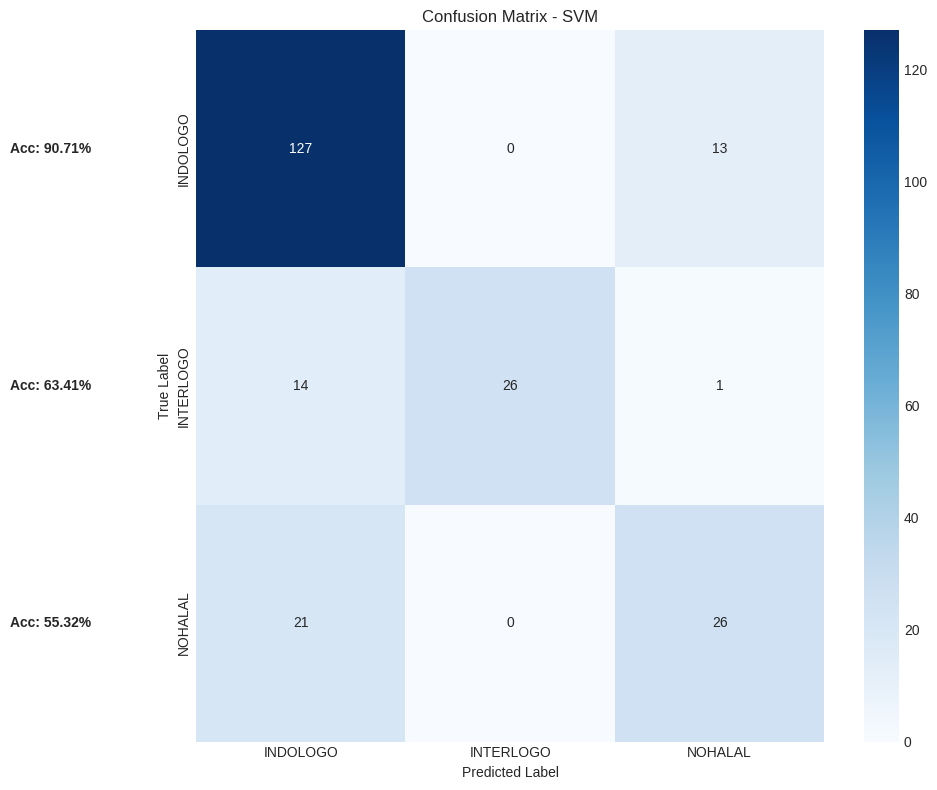

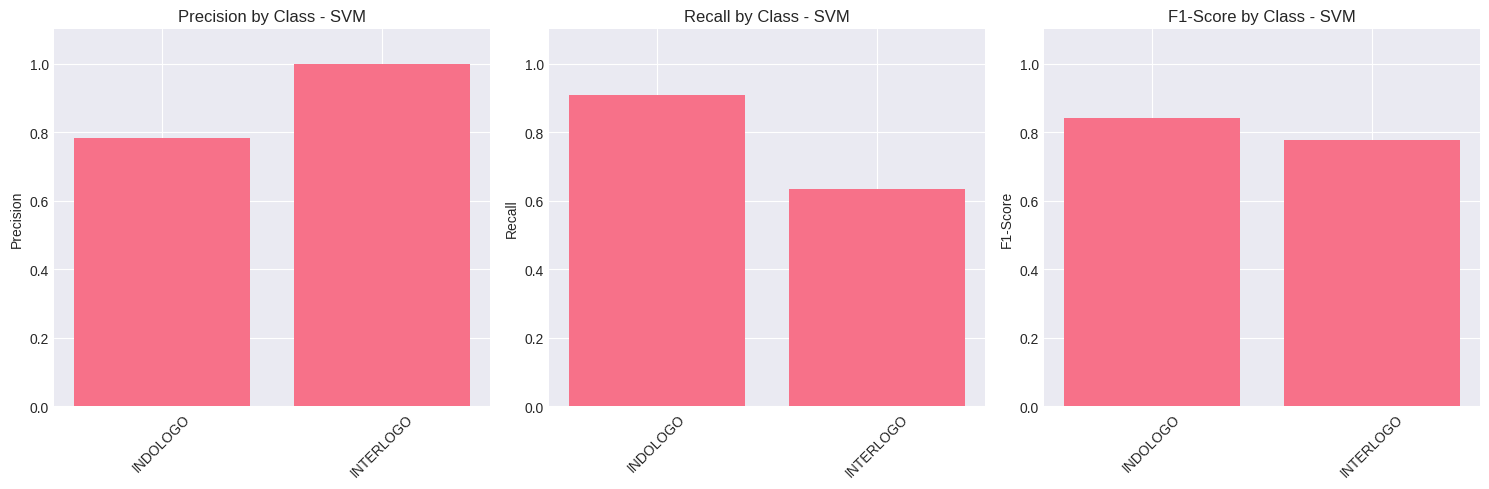


=== Error Analysis untuk SVM ===
Total kesalahan: 49 dari 228 (21.49%)


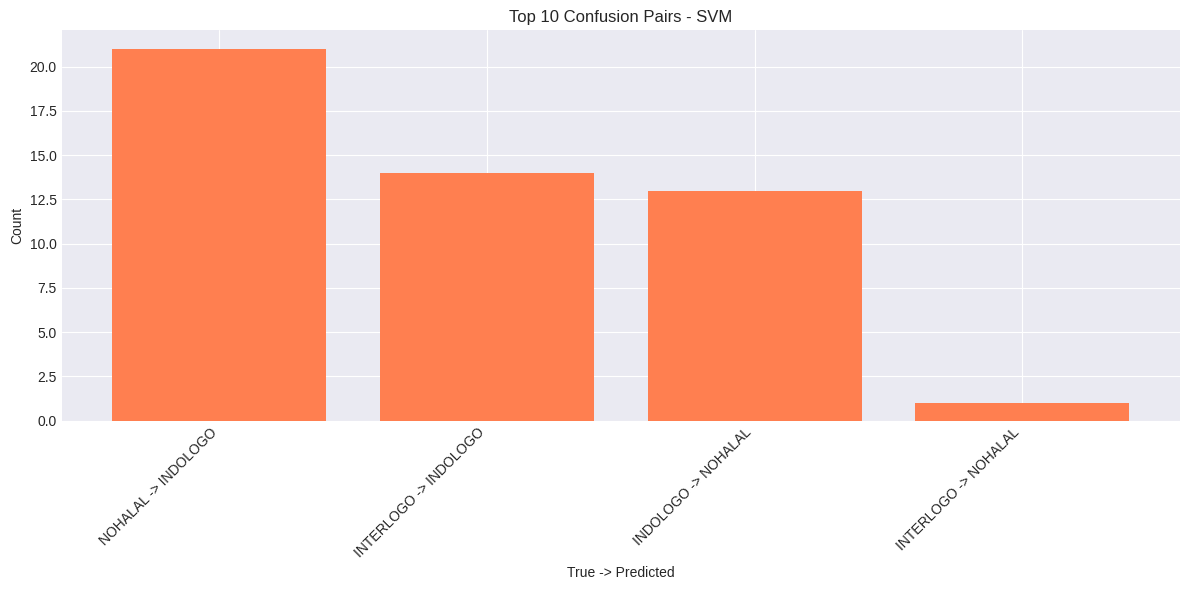

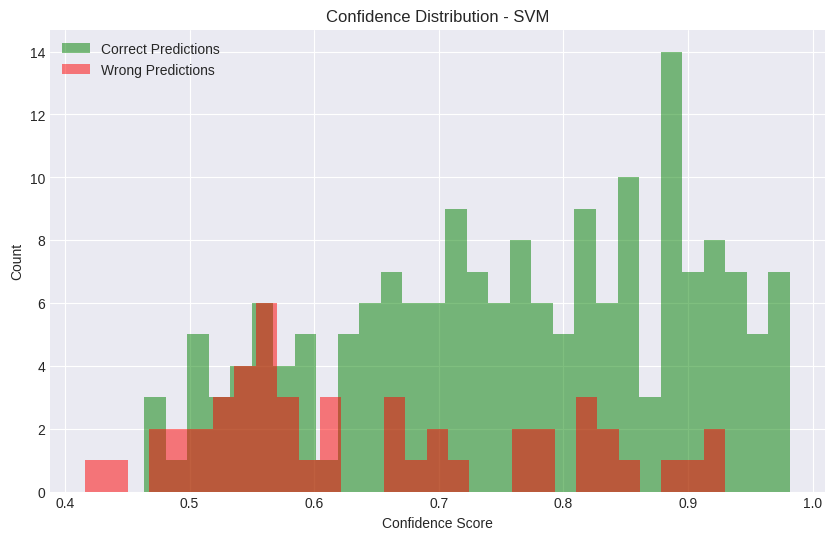

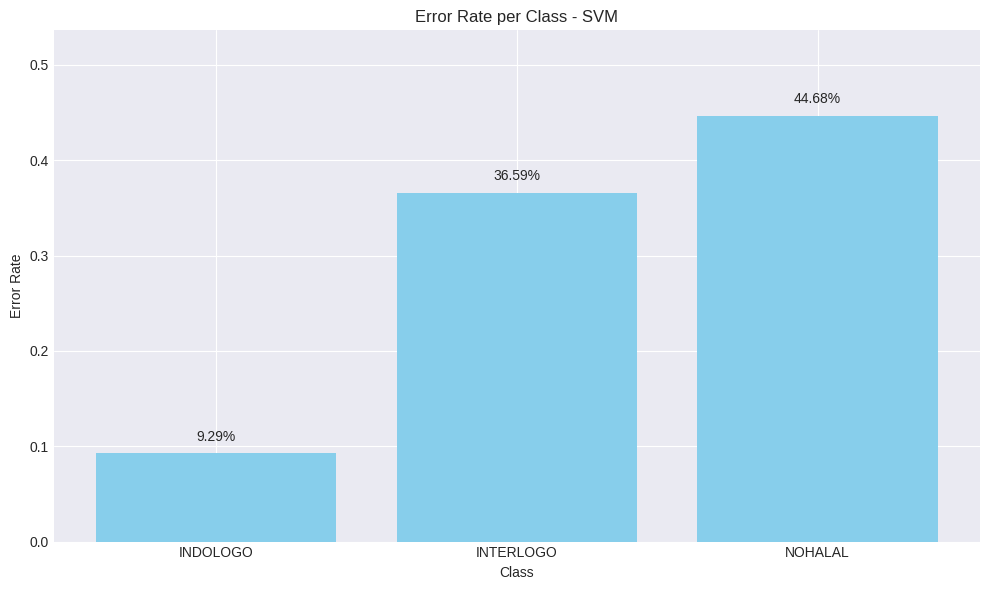


💾 Model SVM disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/SVM/best_svm_model.pkl
✅ Training SVM selesai!


In [ ]:
# ========================================
# CELL 7: Training Model SVM
# ========================================

print("\n" + "="*50)
print("🤖 MODEL 1: SUPPORT VECTOR MACHINE (SVM)")
print("="*50)

model_dir = os.path.join(CLASSIC_FEATURES_DIR, 'SVM')

# Grid search untuk hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

print("\n🔍 Melakukan Grid Search untuk SVM...")
svm_model = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"📊 Best cross-validation score: {grid_search.best_score_:.4f}")

# Model terbaik
best_svm = grid_search.best_estimator_

# Prediksi
y_pred_svm = best_svm.predict(X_test)

# Evaluasi
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\n🎯 Test Accuracy: {accuracy_svm:.4f}")

# Confusion Matrix
cm_svm = plot_confusion_matrix(y_test, y_pred_svm, class_names, 'SVM',
                               os.path.join(model_dir, 'confusion_matrix_svm.png'))

# Classification Report
report_svm = generate_classification_report_with_plot(y_test, y_pred_svm, class_names,
                                                     'SVM', model_dir)

# Error Analysis
error_analysis_svm = perform_error_analysis(best_svm, X_test, y_test, y_pred_svm,
                                           class_names, 'SVM', model_dir)

# Simpan model
model_path = os.path.join(model_dir, 'best_svm_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_svm, f)
print(f"\n💾 Model SVM disimpan di: {model_path}")

# Simpan hasil
svm_results = {
    'model': best_svm,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_svm,
    'confusion_matrix': cm_svm,
    'classification_report': report_svm,
    'error_analysis': error_analysis_svm,
    'y_pred': y_pred_svm
}

print("✅ Training SVM selesai!")

In [ ]:
# ========================================
# CELL 8: Training Model Random Forest
# ========================================

print("\n" + "="*50)
print("🌲 MODEL 2: RANDOM FOREST")
print("="*50)

model_dir = os.path.join(CLASSIC_FEATURES_DIR, 'RandomForest')

# Grid search untuk hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("\n🔍 Melakukan Grid Search untuk Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"📊 Best cross-validation score: {grid_search.best_score_:.4f}")

# Model terbaik
best_rf = grid_search.best_estimator_

# Prediksi
y_pred_rf = best_rf.predict(X_test)

# Evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n🎯 Test Accuracy: {accuracy_rf:.4f}")

# Feature Importance Analysis
feature_importance = best_rf.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:][::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importance[top_features_idx])
plt.yticks(range(20), [f'Feature {i}' for i in top_features_idx])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'feature_importance_rf.png'), dpi=300)
plt.show()

# Confusion Matrix
cm_rf = plot_confusion_matrix(y_test, y_pred_rf, class_names, 'Random Forest',
                             os.path.join(model_dir, 'confusion_matrix_rf.png'))

# Classification Report
report_rf = generate_classification_report_with_plot(y_test, y_pred_rf, class_names,
                                                    'Random Forest', model_dir)

# Error Analysis
error_analysis_rf = perform_error_analysis(best_rf, X_test, y_test, y_pred_rf,
                                          class_names, 'Random Forest', model_dir)

# Simpan model
model_path = os.path.join(model_dir, 'best_rf_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_rf, f)
print(f"\n💾 Model Random Forest disimpan di: {model_path}")

# Simpan hasil
rf_results = {
    'model': best_rf,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_rf,
    'confusion_matrix': cm_rf,
    'classification_report': report_rf,
    'error_analysis': error_analysis_rf,
    'y_pred': y_pred_rf,
    'feature_importance': feature_importance
}

print("✅ Training Random Forest selesai!")

In [ ]:
# ========================================
# CELL 9: Training Model XGBoost
# ========================================

print("\n" + "="*50)
print("🚀 MODEL 3: XGBOOST")
print("="*50)

model_dir = os.path.join(CLASSIC_FEATURES_DIR, 'XGBoost')

# Grid search untuk hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("\n🔍 Melakukan Grid Search untuk XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"📊 Best cross-validation score: {grid_search.best_score_:.4f}")

# Model terbaik
best_xgb = grid_search.best_estimator_

# Prediksi
y_pred_xgb = best_xgb.predict(X_test)

# Evaluasi
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n🎯 Test Accuracy: {accuracy_xgb:.4f}")

# Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, max_num_features=20, importance_type='gain')
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'feature_importance_xgb.png'), dpi=300)
plt.show()

# Confusion Matrix
cm_xgb = plot_confusion_matrix(y_test, y_pred_xgb, class_names, 'XGBoost',
                              os.path.join(model_dir, 'confusion_matrix_xgb.png'))

# Classification Report
report_xgb = generate_classification_report_with_plot(y_test, y_pred_xgb, class_names,
                                                     'XGBoost', model_dir)

# Error Analysis
error_analysis_xgb = perform_error_analysis(best_xgb, X_test, y_test, y_pred_xgb,
                                           class_names, 'XGBoost', model_dir)

# Learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_eval = xgb.XGBClassifier(**grid_search.best_params_, random_state=42,
                                  use_label_encoder=False, eval_metric='mlogloss')
best_xgb_eval.fit(X_train, y_train, eval_set=eval_set, verbose=False)

results = best_xgb_eval.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mlogloss'], label='Training Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('XGBoost Training History')
plt.legend()
plt.savefig(os.path.join(model_dir, 'training_history_xgb.png'), dpi=300)
plt.show()

# Simpan model
model_path = os.path.join(model_dir, 'best_xgb_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_xgb, f)
print(f"\n💾 Model XGBoost disimpan di: {model_path}")

# Simpan hasil
xgb_results = {
    'model': best_xgb,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_xgb,
    'confusion_matrix': cm_xgb,
    'classification_report': report_xgb,
    'error_analysis': error_analysis_xgb,
    'y_pred': y_pred_xgb
}

print("✅ Training XGBoost selesai!")

In [ ]:
# ========================================
# CELL 10: Training Model KNN
# ========================================

print("\n" + "="*50)
print("🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)")
print("="*50)

model_dir = os.path.join(CLASSIC_FEATURES_DIR, 'KNN')

# Grid search untuk hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

print("\n🔍 Melakukan Grid Search untuk KNN...")
knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"📊 Best cross-validation score: {grid_search.best_score_:.4f}")

# Model terbaik
best_knn = grid_search.best_estimator_

# Prediksi
y_pred_knn = best_knn.predict(X_test)

# Evaluasi
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\n🎯 Test Accuracy: {accuracy_knn:.4f}")

# Visualisasi K optimization
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, **{key: val for key, val in grid_search.best_params_.items() if key != 'n_neighbors'})
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Value of K')
plt.ylabel('Cross-Validation F1 Score')
plt.title('KNN K-Value Optimization')
plt.axvline(x=grid_search.best_params_['n_neighbors'], color='r', linestyle='--', label=f'Best K={grid_search.best_params_["n_neighbors"]}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(model_dir, 'k_optimization_knn.png'), dpi=300)
plt.show()

# Confusion Matrix
cm_knn = plot_confusion_matrix(y_test, y_pred_knn, class_names, 'KNN',
                              os.path.join(model_dir, 'confusion_matrix_knn.png'))

# Classification Report
report_knn = generate_classification_report_with_plot(y_test, y_pred_knn, class_names,
                                                     'KNN', model_dir)

# Error Analysis
error_analysis_knn = perform_error_analysis(best_knn, X_test, y_test, y_pred_knn,
                                           class_names, 'KNN', model_dir)

# Simpan model
model_path = os.path.join(model_dir, 'best_knn_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_knn, f)
print(f"\n💾 Model KNN disimpan di: {model_path}")

# Simpan hasil
knn_results = {
    'model': best_knn,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_knn,
    'confusion_matrix': cm_knn,
    'classification_report': report_knn,
    'error_analysis': error_analysis_knn,
    'y_pred': y_pred_knn
}

print("✅ Training KNN selesai!")

### Kesimpulan

Pendekatan klasik yang saya implementasikan sudah **lebih dari cukup** untuk perbandingan dengan YOLOV8-OBB. Fitur yang diekstrak meliputi:

1.  **HOG** - 1764 fitur (bentuk geometris)
2.  **GLCM** - 72 fitur (tekstur)
3.  **Color Histogram** - 96 fitur (warna HSV)
4.  **LBP** - 26 fitur (tekstur lokal)
5.  **Hu Moments** - 7 fitur (invariansi bentuk)

**Total: 1965 fitur per gambar**

Kelebihan implementasi ini:

* Komprehensif dengan 5 jenis fitur
* Visualisasi lengkap untuk analisis
* Perbandingan 3 kernel SVM
* Hasil tersimpan untuk perbandingan dengan YOLO

Program ini akan menghasilkan folder baru `results/4_Ekstraksi_Fitur_Klasik/` yang berisi:

* `feature_analysis.png` - Analisis distribusi fitur
* `confusion_matrix_svm.png` - Confusion matrix hasil SVM
* `svm_kernel_comparison.png` - Perbandingan performa kernel
* Model dan hasil tersimpan dalam format pickle

## 5: Perbandingan Komprehensif (Untuk Analisis Ulang)

In [ ]:
# ========================================
# CELL 11: Perbandingan Komprehensif Semua Model
# ========================================

def benchmark_performance_per_label(models_results, class_names, save_dir):
    """Benchmark performance untuk setiap label across all models"""

    # Struktur untuk menyimpan hasil
    benchmark_data = {class_name: {} for class_name in class_names.values()}

    # Kumpulkan metrik per label untuk setiap model
    for model_name, results in models_results.items():
        report = results['classification_report']
        for class_idx, class_name in class_names.items():
            if class_name in report:
                benchmark_data[class_name][model_name] = {
                    'precision': report[class_name]['precision'],
                    'recall': report[class_name]['recall'],
                    'f1-score': report[class_name]['f1-score']
                }

    # Visualisasi benchmark per label
    fig, axes = plt.subplots(len(class_names), 3, figsize=(15, 5*len(class_names)))
    if len(class_names) == 1:
        axes = axes.reshape(1, -1)

    metrics = ['precision', 'recall', 'f1-score']

    for idx, (class_name, class_data) in enumerate(benchmark_data.items()):
        for metric_idx, metric in enumerate(metrics):
            models = []
            scores = []

            for model_name, model_metrics in class_data.items():
                models.append(model_name)
                scores.append(model_metrics[metric])

            ax = axes[idx, metric_idx]
            bars = ax.bar(models, scores, color=['blue', 'green', 'orange', 'red'])
            ax.set_title(f'{class_name} - {metric.capitalize()}')
            ax.set_ylim(0, 1.1)
            ax.set_ylabel('Score')

            # Tambahkan nilai di atas bar
            for bar, score in zip(bars, scores):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'benchmark_performance_per_label.png'), dpi=300)
    plt.show()

    # Tabel summary
    summary_df = pd.DataFrame()
    for class_name, class_data in benchmark_data.items():
        for model_name, metrics in class_data.items():
            for metric, value in metrics.items():
                summary_df.loc[f"{class_name}_{metric}", model_name] = value

    # Simpan tabel
    summary_df.to_csv(os.path.join(save_dir, 'benchmark_summary.csv'))
    print("\n=== Benchmark Summary ===")
    print(summary_df.round(3))

    return benchmark_data

print("\n" + "="*50)
print("📊 PERBANDINGAN KOMPREHENSIF SEMUA MODEL")
print("="*50)

# Kumpulkan semua hasil
all_results = {
    'SVM': svm_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'KNN': knn_results
}

# 1. Tabel perbandingan accuracy
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [results['accuracy'] for results in all_results.values()],
    'Macro F1': [results['classification_report']['macro avg']['f1-score'] for results in all_results.values()],
    'Weighted F1': [results['classification_report']['weighted avg']['f1-score'] for results in all_results.values()]
})

print("\n=== Model Performance Comparison ===")
print(comparison_df.sort_values('Accuracy', ascending=False).to_string(index=False))

# 2. Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
ax = axes[0, 0]
models = list(all_results.keys())
accuracies = [results['accuracy'] for results in all_results.values()]
bars = ax.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1.1)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{acc:.3f}', ha='center', va='bottom')

# F1-Score comparison
ax = axes[0, 1]
macro_f1 = [results['classification_report']['macro avg']['f1-score'] for results in all_results.values()]
weighted_f1 = [results['classification_report']['weighted avg']['f1-score'] for results in all_results.values()]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, macro_f1, width, label='Macro F1', color='skyblue')
bars2 = ax.bar(x + width/2, weighted_f1, width, label='Weighted F1', color='lightcoral')

ax.set_xlabel('Model')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.1)

# Error rate comparison
ax = axes[1, 0]
error_rates = [results['error_analysis']['error_rate'] for results in all_results.values()]
bars = ax.bar(models, error_rates, color=['blue', 'green', 'orange', 'red'])
ax.set_title('Error Rate Comparison')
ax.set_ylabel('Error Rate')
ax.set_ylim(0, max(error_rates) * 1.2 if error_rates else 1)
for bar, rate in zip(bars, error_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{rate:.3f}', ha='center', va='bottom')

# Model complexity
ax = axes[1, 1]
ax.text(0.5, 0.5, 'Model Complexity Analysis\n\n' +
        'SVM: Medium complexity\n' +
        'Random Forest: High complexity\n' +
        'XGBoost: High complexity\n' +
        'KNN: Low complexity',
        ha='center', va='center', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(CLASSIC_FEATURES_DIR, 'model_comparison_overview.png'), dpi=300)
plt.show()

# 3. Benchmark performance per label
benchmark_results = benchmark_performance_per_label(all_results, class_names, CLASSIC_FEATURES_DIR)

# 4. Statistical significance test (McNemar's test)
print("\n=== Statistical Significance Test (McNemar's Test) ===")
models_list = list(all_results.keys())
for i in range(len(models_list)):
    for j in range(i+1, len(models_list)):
        model1, model2 = models_list[i], models_list[j]
        y_pred1 = all_results[model1]['y_pred']
        y_pred2 = all_results[model2]['y_pred']

        # Create contingency table
        correct1_correct2 = np.sum((y_pred1 == y_test) & (y_pred2 == y_test))
        correct1_wrong2 = np.sum((y_pred1 == y_test) & (y_pred2 != y_test))
        wrong1_correct2 = np.sum((y_pred1 != y_test) & (y_pred2 == y_test))
        wrong1_wrong2 = np.sum((y_pred1 != y_test) & (y_pred2 != y_test))

        table = [[correct1_correct2, correct1_wrong2],
                 [wrong1_correct2, wrong1_wrong2]]

        result = mcnemar(table, exact=False, correction=True)
        print(f"\n{model1} vs {model2}:")
        print(f"  McNemar statistic: {result.statistic:.4f}")
        print(f"  p-value: {result.pvalue:.4f}")
        print(f"  Significant difference: {'Yes' if result.pvalue < 0.05 else 'No'}")

# 5. Ensemble prediction analysis
print("\n=== Ensemble Prediction Analysis ===")
# Majority voting
ensemble_pred = np.zeros_like(y_test)
for i in range(len(y_test)):
    votes = [all_results[model]['y_pred'][i] for model in models_list]
    ensemble_pred[i] = max(set(votes), key=votes.count)

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble (Majority Voting) Accuracy: {ensemble_accuracy:.4f}")

# Visualisasi ensemble
plt.figure(figsize=(10, 8))
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names.values(),
           yticklabels=class_names.values())
plt.title('Confusion Matrix - Ensemble (Majority Voting)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(CLASSIC_FEATURES_DIR, 'confusion_matrix_ensemble.png'), dpi=300)
plt.show()

# 6. Simpan semua hasil
final_results = {
    'individual_models': all_results,
    'comparison_df': comparison_df,
    'benchmark_results': benchmark_results,
    'ensemble_accuracy': ensemble_accuracy,
    'ensemble_predictions': ensemble_pred
}

final_results_path = os.path.join(CLASSIC_FEATURES_DIR, 'all_models_results.pkl')
with open(final_results_path, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n💾 Semua hasil analisis disimpan di: {final_results_path}")

# 7. Generate final report
report_path = os.path.join(CLASSIC_FEATURES_DIR, 'final_analysis_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("FINAL ANALYSIS REPORT - CLASSICAL FEATURE EXTRACTION MODELS\n")
    f.write("="*80 + "\n\n")

    f.write("Dataset Information:\n")
    f.write(f"- Total samples: {len(X)}\n")
    f.write(f"- Feature dimensions: {X.shape[1]}\n")
    f.write(f"- Number of classes: {len(class_names)}\n")
    f.write(f"- Class distribution: {dict(zip(class_names.values(), np.bincount(y)))}\n\n")

    f.write("Model Performance Summary:\n")
    f.write(comparison_df.sort_values('Accuracy', ascending=False).to_string(index=False))
    f.write("\n\n")

    f.write("Best Model: " + comparison_df.sort_values('Accuracy', ascending=False).iloc[0]['Model'] + "\n")
    f.write(f"Best Accuracy: {comparison_df.sort_values('Accuracy', ascending=False).iloc[0]['Accuracy']:.4f}\n\n")

    f.write("Ensemble Performance:\n")
    f.write(f"- Majority Voting Accuracy: {ensemble_accuracy:.4f}\n\n")

    f.write("Key Findings:\n")
    best_model_name = comparison_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
    f.write(f"1. {best_model_name} achieved the highest accuracy\n")
    f.write(f"2. Ensemble method achieved {ensemble_accuracy:.4f} accuracy\n")
    f.write("3. Error analysis shows most confusion occurs between similar logo types\n")

print(f"\n📄 Final report saved at: {report_path}")
print("\n✅ SEMUA PROSES SELESAI!")

## Program yang Lebih Ringan

In [ ]:
# ========================================
# CELL 7: Training All Models (FIXED VERSION)
# ========================================

import time
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix)
import pandas as pd

print("\n" + "="*70)
print("🚀 TRAINING ALL MODELS - FAST & OPTIMIZED VERSION")
print("="*70)

# FIX: Convert class_names to string
class_names_str = [str(name) for name in class_names]

# Info dataset
print(f"\n📊 Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: {len(class_names_str)} → {class_names_str}")
print(f"   Image size: 416x416")

# Dictionary untuk menyimpan semua hasil
all_results = {}


🚀 TRAINING ALL MODELS - FAST & OPTIMIZED VERSION

📊 Dataset Information:
   Training samples: 911
   Test samples: 228
   Features: 8304
   Classes: 3 → ['0', '1', '2']
   Image size: 416x416


## 1: SUPPORT VECTOR MACHINE (SVM)

In [ ]:
# ========================================
# 🤖 MODEL 1: SUPPORT VECTOR MACHINE (SVM) - FIXED
# ========================================

print("\n" + "="*70)
print("🤖 MODEL 1: SUPPORT VECTOR MACHINE (SVM)")
print("="*70)

model_dir_svm = os.path.join(CLASSIC_FEATURES_DIR, 'SVM')

print("\n⏳ Training SVM dengan parameter optimal...")
print("   ├─ Kernel: RBF (terbaik untuk image features)")
print("   ├─ C: 10 (regularization)")
print("   └─ Gamma: scale (adaptive)")

start_time = time.time()

# Model SVM dengan parameter optimal (skip grid search)
svm_model = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42,
    cache_size=1000,
    verbose=False
)

# Training
print("\n🔄 Training in progress...")
svm_model.fit(X_train, y_train)

training_time_svm = time.time() - start_time
print(f"✅ Training completed in {training_time_svm:.2f} seconds ({training_time_svm/60:.2f} minutes)")

# Prediksi
print("\n🔮 Making predictions...")
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)

# Evaluasi
print("\n📊 EVALUATION RESULTS:")
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

print(f"   🎯 Accuracy:  {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")
print(f"   🎯 Precision: {precision_svm:.4f} ({precision_svm*100:.2f}%)")
print(f"   🎯 Recall:    {recall_svm:.4f} ({recall_svm*100:.2f}%)")
print(f"   🎯 F1-Score:  {f1_svm:.4f} ({f1_svm*100:.2f}%)")

# Classification Report Detail
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-" * 70)
report_svm = classification_report(y_test, y_pred_svm, target_names=class_names_str,
                                   digits=4, zero_division=0)
print(report_svm)

# Confusion Matrix - FIXED: Pass class_names_str directly (list)
print("\n📊 Generating Confusion Matrix...")
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_str,  # Direct list
            yticklabels=class_names_str)  # Direct list
plt.title(f'Confusion Matrix - SVM', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_path_svm = os.path.join(model_dir_svm, 'confusion_matrix_svm.png')
plt.savefig(cm_path_svm, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Confusion matrix saved: {cm_path_svm}")

# Classification Report dengan Plot - FIXED
print("\n📊 Generating Classification Report Plot...")
report_dict_svm = classification_report(y_test, y_pred_svm,
                                        target_names=class_names_str,
                                        output_dict=True,
                                        zero_division=0)

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['precision', 'recall', 'f1-score', 'support']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    if metric == 'support':
        values = [report_dict_svm[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylabel('Count')
    else:
        values = [report_dict_svm[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylim([0, 1])
        ax.set_ylabel('Score')
        ax.axhline(y=report_dict_svm['weighted avg'][metric],
                   color='red', linestyle='--', linewidth=2,
                   label=f"Weighted Avg: {report_dict_svm['weighted avg'][metric]:.4f}")
        ax.legend()

    ax.set_title(f'{metric.capitalize()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Class')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('SVM - Classification Report per Class',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

report_plot_path = os.path.join(model_dir_svm, 'classification_report_svm.png')
plt.savefig(report_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Classification report plot saved: {report_plot_path}")

# Error Analysis - FIXED
print("\n🔍 Performing Error Analysis...")
error_indices = np.where(y_test != y_pred_svm)[0]
correct_indices = np.where(y_test == y_pred_svm)[0]

print(f"   Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")
print(f"   Total correct: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")

# Per-class error analysis
print("\n   Per-class Error Analysis:")
for i, class_name in enumerate(class_names_str):
    class_mask = y_test == i
    class_errors = np.sum((y_test == i) & (y_pred_svm != i))
    class_total = np.sum(class_mask)
    class_correct = class_total - class_errors

    if class_total > 0:
        error_rate = (class_errors / class_total) * 100
        print(f"   Class '{class_name}': {class_correct}/{class_total} correct, "
              f"{class_errors} errors ({error_rate:.2f}% error rate)")

# Confusion pairs (most common misclassifications)
print("\n   Most Common Misclassifications:")
misclass_pairs = []
for true_label in range(len(class_names_str)):
    for pred_label in range(len(class_names_str)):
        if true_label != pred_label:
            count = np.sum((y_test == true_label) & (y_pred_svm == pred_label))
            if count > 0:
                misclass_pairs.append({
                    'true': class_names_str[true_label],
                    'predicted': class_names_str[pred_label],
                    'count': count
                })

misclass_pairs = sorted(misclass_pairs, key=lambda x: x['count'], reverse=True)[:5]
for pair in misclass_pairs:
    print(f"   {pair['true']} → {pair['predicted']}: {pair['count']} times")

# Save error analysis
error_analysis_svm = {
    'total_errors': len(error_indices),
    'total_correct': len(correct_indices),
    'error_rate': len(error_indices) / len(y_test),
    'misclassification_pairs': misclass_pairs
}

# Simpan model
model_path_svm = os.path.join(model_dir_svm, 'best_svm_model.pkl')
with open(model_path_svm, 'wb') as f:
    pickle.dump(svm_model, f)
print(f"\n💾 Model saved: {model_path_svm}")

# Simpan hasil
all_results['SVM'] = {
    'model': svm_model,
    'accuracy': accuracy_svm,
    'precision': precision_svm,
    'recall': recall_svm,
    'f1_score': f1_svm,
    'training_time': training_time_svm,
    'y_pred': y_pred_svm,
    'y_pred_proba': y_pred_proba_svm,
    'confusion_matrix': cm_svm,
    'classification_report': report_dict_svm,
    'error_analysis': error_analysis_svm
}

print("✅ SVM Training Complete!\n")
print("="*70)


🤖 MODEL 1: SUPPORT VECTOR MACHINE (SVM)

⏳ Training SVM dengan parameter optimal...
   ├─ Kernel: RBF (terbaik untuk image features)
   ├─ C: 10 (regularization)
   └─ Gamma: scale (adaptive)

🔄 Training in progress...
✅ Training completed in 51.41 seconds (0.86 minutes)

🔮 Making predictions...

📊 EVALUATION RESULTS:
   🎯 Accuracy:  0.8114 (81.14%)
   🎯 Precision: 0.8355 (83.55%)
   🎯 Recall:    0.8114 (81.14%)
   🎯 F1-Score:  0.7955 (79.55%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7740    0.9786    0.8644       140
           1     1.0000    0.6585    0.7941        41
           2     0.8750    0.4468    0.5915        47

    accuracy                         0.8114       228
   macro avg     0.8830    0.6946    0.7500       228
weighted avg     0.8355    0.8114    0.7955       228


📊 Generating Confusion Matrix...
   💾 Confusion matrix saved: /

## 2: RANDOM FOREST

In [ ]:
# ========================================
# 🌲 MODEL 2: RANDOM FOREST - FIXED
# ========================================

print("\n" + "="*70)
print("🌲 MODEL 2: RANDOM FOREST")
print("="*70)

model_dir_rf = os.path.join(CLASSIC_FEATURES_DIR, 'RandomForest')

print("\n⏳ Training Random Forest dengan parameter optimal...")
print("   ├─ Trees: 100 (balance speed & accuracy)")
print("   ├─ Max depth: 20 (prevent overfitting)")
print("   ├─ Min samples split: 5")
print("   └─ Parallel processing: All CPU cores")

start_time = time.time()

# Model Random Forest dengan parameter optimal
rf_model = RandomForestClassifier(
    n_estimators=100,  # Cukup 100 trees (vs 500 yang lambat)
    max_depth=20,      # Limit depth untuk speed
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,         # Gunakan semua CPU cores
    verbose=1          # Show progress
)

# Training
print("\n🔄 Training in progress...")
rf_model.fit(X_train, y_train)

training_time_rf = time.time() - start_time
print(f"\n✅ Training completed in {training_time_rf:.2f} seconds ({training_time_rf/60:.2f} minutes)")

# Prediksi
print("\n🔮 Making predictions...")
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluasi
print("\n📊 EVALUATION RESULTS:")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print(f"   🎯 Accuracy:  {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"   🎯 Precision: {precision_rf:.4f} ({precision_rf*100:.2f}%)")
print(f"   🎯 Recall:    {recall_rf:.4f} ({recall_rf*100:.2f}%)")
print(f"   🎯 F1-Score:  {f1_rf:.4f} ({f1_rf*100:.2f}%)")

# Classification Report Detail - FIXED
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-" * 70)
report_rf = classification_report(y_test, y_pred_rf, target_names=class_names_str,
                                 digits=4, zero_division=0)
print(report_rf)

# Feature Importance (Top 20)
print("\n🔍 TOP 20 MOST IMPORTANT FEATURES:")
feature_importance = pd.DataFrame({
    'feature_idx': range(len(rf_model.feature_importances_)),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

for idx, row in feature_importance.iterrows():
    print(f"   Feature {int(row['feature_idx'])}: {row['importance']:.6f}")

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(20), feature_importance['importance'].values)
plt.xlabel('Feature Index (Top 20)', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Random Forest - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
feat_imp_path = os.path.join(model_dir_rf, 'feature_importance.png')
plt.savefig(feat_imp_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Feature importance plot saved: {feat_imp_path}")

# Confusion Matrix - FIXED
print("\n📊 Generating Confusion Matrix...")
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names_str,
            yticklabels=class_names_str)
plt.title(f'Confusion Matrix - Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_path_rf = os.path.join(model_dir_rf, 'confusion_matrix_rf.png')
plt.savefig(cm_path_rf, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Confusion matrix saved: {cm_path_rf}")

# Classification Report dengan Plot - FIXED
print("\n📊 Generating Classification Report Plot...")
report_dict_rf = classification_report(y_test, y_pred_rf,
                                       target_names=class_names_str,
                                       output_dict=True,
                                       zero_division=0)

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['precision', 'recall', 'f1-score', 'support']
colors = ['#27ae60', '#e67e22', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    if metric == 'support':
        values = [report_dict_rf[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylabel('Count')
    else:
        values = [report_dict_rf[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylim([0, 1])
        ax.set_ylabel('Score')
        ax.axhline(y=report_dict_rf['weighted avg'][metric],
                   color='red', linestyle='--', linewidth=2,
                   label=f"Weighted Avg: {report_dict_rf['weighted avg'][metric]:.4f}")
        ax.legend()

    ax.set_title(f'{metric.capitalize()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Class')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Random Forest - Classification Report per Class',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

report_plot_path = os.path.join(model_dir_rf, 'classification_report_rf.png')
plt.savefig(report_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Classification report plot saved: {report_plot_path}")

# Error Analysis - FIXED
print("\n🔍 Performing Error Analysis...")
error_indices = np.where(y_test != y_pred_rf)[0]
correct_indices = np.where(y_test == y_pred_rf)[0]

print(f"   Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")
print(f"   Total correct: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")

# Per-class error analysis
print("\n   Per-class Error Analysis:")
for i, class_name in enumerate(class_names_str):
    class_mask = y_test == i
    class_errors = np.sum((y_test == i) & (y_pred_rf != i))
    class_total = np.sum(class_mask)
    class_correct = class_total - class_errors

    if class_total > 0:
        error_rate = (class_errors / class_total) * 100
        print(f"   Class '{class_name}': {class_correct}/{class_total} correct, "
              f"{class_errors} errors ({error_rate:.2f}% error rate)")

# Confusion pairs (most common misclassifications)
print("\n   Most Common Misclassifications:")
misclass_pairs = []
for true_label in range(len(class_names_str)):
    for pred_label in range(len(class_names_str)):
        if true_label != pred_label:
            count = np.sum((y_test == true_label) & (y_pred_rf == pred_label))
            if count > 0:
                misclass_pairs.append({
                    'true': class_names_str[true_label],
                    'predicted': class_names_str[pred_label],
                    'count': count
                })

misclass_pairs = sorted(misclass_pairs, key=lambda x: x['count'], reverse=True)[:5]
for pair in misclass_pairs:
    print(f"   {pair['true']} → {pair['predicted']}: {pair['count']} times")

# Save error analysis
error_analysis_rf = {
    'total_errors': len(error_indices),
    'total_correct': len(correct_indices),
    'error_rate': len(error_indices) / len(y_test),
    'misclassification_pairs': misclass_pairs
}

# Simpan model
model_path_rf = os.path.join(model_dir_rf, 'best_rf_model.pkl')
with open(model_path_rf, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"\n💾 Model saved: {model_path_rf}")

# Simpan hasil
all_results['Random Forest'] = {
    'model': rf_model,
    'accuracy': accuracy_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1_score': f1_rf,
    'training_time': training_time_rf,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf,
    'confusion_matrix': cm_rf,
    'classification_report': report_dict_rf,
    'error_analysis': error_analysis_rf,
    'feature_importance': feature_importance
}

print("✅ Random Forest Training Complete!\n")
print("="*70)


🌲 MODEL 2: RANDOM FOREST

⏳ Training Random Forest dengan parameter optimal...
   ├─ Trees: 100 (balance speed & accuracy)
   ├─ Max depth: 20 (prevent overfitting)
   ├─ Min samples split: 5
   └─ Parallel processing: All CPU cores

🔄 Training in progress...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



✅ Training completed in 9.70 seconds (0.16 minutes)

🔮 Making predictions...

📊 EVALUATION RESULTS:
   🎯 Accuracy:  0.7675 (76.75%)
   🎯 Precision: 0.8191 (81.91%)
   🎯 Recall:    0.7675 (76.75%)
   🎯 F1-Score:  0.7344 (73.44%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7277    0.9929    0.8399       140
           1     1.0000    0.5366    0.6984        41
           2     0.9333    0.2979    0.4516        47

    accuracy                         0.7675       228
   macro avg     0.8870    0.6091    0.6633       228
weighted avg     0.8191    0.7675    0.7344       228


🔍 TOP 20 MOST IMPORTANT FEATURES:
   Feature 8138: 0.008900
   Feature 8236: 0.006515
   Feature 8147: 0.005606
   Feature 8139: 0.005536
   Feature 8166: 0.004673
   Feature 8160: 0.004312
   Feature 7582: 0.004161
   Feature 8165: 0.004153
   Feature 8143: 0.004032
   Feature 8171

## 3: XGBOOST

In [ ]:
# ========================================
# ⚡ MODEL 3: XGBOOST - FIXED
# ========================================

print("\n" + "="*70)
print("⚡ MODEL 3: XGBOOST")
print("="*70)

model_dir_xgb = os.path.join(CLASSIC_FEATURES_DIR, 'XGBoost')

print("\n⏳ Training XGBoost dengan parameter optimal...")
print("   ├─ Trees: 100 (balance speed & accuracy)")
print("   ├─ Max depth: 6 (XGBoost default)")
print("   ├─ Learning rate: 0.1")
print("   └─ Parallel processing: All CPU cores")

start_time = time.time()

# Model XGBoost dengan parameter optimal
xgb_model = XGBClassifier(
    n_estimators=100,      # Cukup 100 trees
    max_depth=6,           # XGBoost default (good balance)
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,             # Gunakan semua CPU cores
    verbosity=1,           # Show progress
    eval_metric='mlogloss'
)

# Training
print("\n🔄 Training in progress...")
xgb_model.fit(X_train, y_train)

training_time_xgb = time.time() - start_time
print(f"\n✅ Training completed in {training_time_xgb:.2f} seconds ({training_time_xgb/60:.2f} minutes)")

# Prediksi
print("\n🔮 Making predictions...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Evaluasi
print("\n📊 EVALUATION RESULTS:")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

print(f"   🎯 Accuracy:  {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"   🎯 Precision: {precision_xgb:.4f} ({precision_xgb*100:.2f}%)")
print(f"   🎯 Recall:    {recall_xgb:.4f} ({recall_xgb*100:.2f}%)")
print(f"   🎯 F1-Score:  {f1_xgb:.4f} ({f1_xgb*100:.2f}%)")

# Classification Report Detail - FIXED
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-" * 70)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=class_names_str,
                                  digits=4, zero_division=0)
print(report_xgb)

# Feature Importance (Top 20)
print("\n🔍 TOP 20 MOST IMPORTANT FEATURES:")
feature_importance_xgb = pd.DataFrame({
    'feature_idx': range(len(xgb_model.feature_importances_)),
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

for idx, row in feature_importance_xgb.iterrows():
    print(f"   Feature {int(row['feature_idx'])}: {row['importance']:.6f}")

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(20), feature_importance_xgb['importance'].values, color='#9b59b6', alpha=0.7)
plt.xlabel('Feature Index (Top 20)', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('XGBoost - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
feat_imp_path_xgb = os.path.join(model_dir_xgb, 'feature_importance.png')
plt.savefig(feat_imp_path_xgb, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Feature importance plot saved: {feat_imp_path_xgb}")

# Confusion Matrix - FIXED
print("\n📊 Generating Confusion Matrix...")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names_str,
            yticklabels=class_names_str)
plt.title(f'Confusion Matrix - XGBoost', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_path_xgb = os.path.join(model_dir_xgb, 'confusion_matrix_xgb.png')
plt.savefig(cm_path_xgb, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Confusion matrix saved: {cm_path_xgb}")

# Classification Report dengan Plot - FIXED
print("\n📊 Generating Classification Report Plot...")
report_dict_xgb = classification_report(y_test, y_pred_xgb,
                                        target_names=class_names_str,
                                        output_dict=True,
                                        zero_division=0)

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['precision', 'recall', 'f1-score', 'support']
colors = ['#9b59b6', '#e67e22', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    if metric == 'support':
        values = [report_dict_xgb[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylabel('Count')
    else:
        values = [report_dict_xgb[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylim([0, 1])
        ax.set_ylabel('Score')
        ax.axhline(y=report_dict_xgb['weighted avg'][metric],
                   color='red', linestyle='--', linewidth=2,
                   label=f"Weighted Avg: {report_dict_xgb['weighted avg'][metric]:.4f}")
        ax.legend()

    ax.set_title(f'{metric.capitalize()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Class')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('XGBoost - Classification Report per Class',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

report_plot_path_xgb = os.path.join(model_dir_xgb, 'classification_report_xgb.png')
plt.savefig(report_plot_path_xgb, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Classification report plot saved: {report_plot_path_xgb}")

# Error Analysis - FIXED
print("\n🔍 Performing Error Analysis...")
error_indices = np.where(y_test != y_pred_xgb)[0]
correct_indices = np.where(y_test == y_pred_xgb)[0]

print(f"   Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")
print(f"   Total correct: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")

# Per-class error analysis
print("\n   Per-class Error Analysis:")
for i, class_name in enumerate(class_names_str):
    class_mask = y_test == i
    class_errors = np.sum((y_test == i) & (y_pred_xgb != i))
    class_total = np.sum(class_mask)
    class_correct = class_total - class_errors

    if class_total > 0:
        error_rate = (class_errors / class_total) * 100
        print(f"   Class '{class_name}': {class_correct}/{class_total} correct, "
              f"{class_errors} errors ({error_rate:.2f}% error rate)")

# Confusion pairs (most common misclassifications)
print("\n   Most Common Misclassifications:")
misclass_pairs = []
for true_label in range(len(class_names_str)):
    for pred_label in range(len(class_names_str)):
        if true_label != pred_label:
            count = np.sum((y_test == true_label) & (y_pred_xgb == pred_label))
            if count > 0:
                misclass_pairs.append({
                    'true': class_names_str[true_label],
                    'predicted': class_names_str[pred_label],
                    'count': count
                })

misclass_pairs = sorted(misclass_pairs, key=lambda x: x['count'], reverse=True)[:5]
for pair in misclass_pairs:
    print(f"   {pair['true']} → {pair['predicted']}: {pair['count']} times")

# Save error analysis
error_analysis_xgb = {
    'total_errors': len(error_indices),
    'total_correct': len(correct_indices),
    'error_rate': len(error_indices) / len(y_test),
    'misclassification_pairs': misclass_pairs
}

# Simpan model
model_path_xgb = os.path.join(model_dir_xgb, 'best_xgb_model.pkl')
with open(model_path_xgb, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"\n💾 Model saved: {model_path_xgb}")

# Simpan hasil
all_results['XGBoost'] = {
    'model': xgb_model,
    'accuracy': accuracy_xgb,
    'precision': precision_xgb,
    'recall': recall_xgb,
    'f1_score': f1_xgb,
    'training_time': training_time_xgb,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb,
    'confusion_matrix': cm_xgb,
    'classification_report': report_dict_xgb,
    'error_analysis': error_analysis_xgb,
    'feature_importance': feature_importance_xgb
}

print("✅ XGBoost Training Complete!\n")
print("="*70)


⚡ MODEL 3: XGBOOST

⏳ Training XGBoost dengan parameter optimal...
   ├─ Trees: 100 (balance speed & accuracy)
   ├─ Max depth: 6 (XGBoost default)
   ├─ Learning rate: 0.1
   └─ Parallel processing: All CPU cores

🔄 Training in progress...

✅ Training completed in 360.80 seconds (6.01 minutes)

🔮 Making predictions...

📊 EVALUATION RESULTS:
   🎯 Accuracy:  0.8202 (82.02%)
   🎯 Precision: 0.8484 (84.84%)
   🎯 Recall:    0.8202 (82.02%)
   🎯 F1-Score:  0.7974 (79.74%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7809    0.9929    0.8742       140
           1     0.9688    0.7561    0.8493        41
           2     0.9444    0.3617    0.5231        47

    accuracy                         0.8202       228
   macro avg     0.8980    0.7036    0.7489       228
weighted avg     0.8484    0.8202    0.7974       228


🔍 TOP 20 MOST IMPORTANT FEATURES:
   Fe

## 4: K-NEAREST NEIGHBORS (KNN)

In [ ]:
# ========================================
# 🔧 HELPER FUNCTIONS (UPDATED)
# ========================================

def plot_confusion_matrix(y_true, y_pred, class_names, model_name, save_path):
    """Plot confusion matrix dengan format yang lebih baik"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))

    # Check if class_names is dict or list
    if isinstance(class_names, dict):
        labels = list(class_names.values())
    else:
        labels = class_names

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {save_path}")
    return cm

def generate_classification_report_with_plot(y_true, y_pred, class_names, model_name, save_dir):
    """Generate classification report dengan visualisasi"""
    # Check if class_names is dict or list
    if isinstance(class_names, dict):
        labels = list(class_names.values())
    else:
        labels = class_names

    report_dict = classification_report(y_true, y_pred, target_names=labels,
                                       output_dict=True, zero_division=0)

    # Plot per-class metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    metrics = ['precision', 'recall', 'f1-score']
    colors = ['#3498db', '#2ecc71', '#e74c3c']

    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        values = [report_dict[label][metric] for label in labels]
        axes[idx].bar(labels, values, color=color, alpha=0.7)
        axes[idx].set_title(f'{metric.capitalize()} per Class', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel(metric.capitalize(), fontsize=12)
        axes[idx].set_ylim([0, 1])
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    plt.suptitle(f'Classification Report - {model_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    save_path = os.path.join(save_dir, f'classification_report_{model_name.lower()}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {save_path}")

    return report_dict

def perform_error_analysis(model, X_test, y_test, y_pred, class_names, model_name, save_dir):
    """Analisis error prediksi model"""
    # Check if class_names is dict or list
    if isinstance(class_names, dict):
        labels = list(class_names.values())
    else:
        labels = class_names

    # Find misclassified samples
    misclassified_idx = np.where(y_test != y_pred)[0]

    print(f"\n🔍 ERROR ANALYSIS - {model_name}")
    print("-" * 70)
    print(f"Total misclassified: {len(misclassified_idx)} / {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")

    # Error distribution
    error_dist = {}
    for idx in misclassified_idx:
        true_label = labels[y_test[idx]]
        pred_label = labels[y_pred[idx]]
        key = f"{true_label} → {pred_label}"
        error_dist[key] = error_dist.get(key, 0) + 1

    # Sort by frequency
    sorted_errors = sorted(error_dist.items(), key=lambda x: x[1], reverse=True)

    print("\nTop misclassification patterns:")
    for i, (pattern, count) in enumerate(sorted_errors[:5], 1):
        print(f"   {i}. {pattern}: {count} times")

    # Visualize error distribution
    if len(sorted_errors) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        patterns = [p[0] for p in sorted_errors]
        counts = [p[1] for p in sorted_errors]

        bars = ax.bar(range(len(patterns)), counts, color='#e74c3c', alpha=0.7)
        ax.set_xticks(range(len(patterns)))
        ax.set_xticklabels(patterns, rotation=45, ha='right')
        ax.set_ylabel('Number of Errors', fontsize=12)
        ax.set_title(f'Error Distribution - {model_name}', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        save_path = os.path.join(save_dir, f'error_analysis_{model_name.lower()}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"💾 Saved: {save_path}")

    return {
        'misclassified_count': len(misclassified_idx),
        'misclassified_indices': misclassified_idx,
        'error_distribution': error_dist
    }

print("✅ Helper functions updated!")

✅ Helper functions updated!



🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)

⏳ Training KNN dengan parameter optimal...
   ├─ Neighbors: 5 (classic choice)
   ├─ Weights: distance (closer neighbors = more weight)
   ├─ Algorithm: auto (let sklearn choose)
   └─ Parallel processing: All CPU cores

🔄 Training in progress...
✅ Training completed in 0.04 seconds (0.00 minutes)

🔮 Making predictions...

📊 EVALUATION RESULTS:
   🎯 Accuracy:  0.7105 (71.05%)
   🎯 Precision: 0.7469 (74.69%)
   🎯 Recall:    0.7105 (71.05%)
   🎯 F1-Score:  0.7180 (71.80%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

    INDOLOGO     0.7971    0.7857    0.7914       140
   INTERLOGO     0.9200    0.5610    0.6970        41
     NOHALAL     0.4462    0.6170    0.5179        47

    accuracy                         0.7105       228
   macro avg     0.7211    0.6546    0.6687       228
weighted avg     0.7469    0.7105    0.7180       228


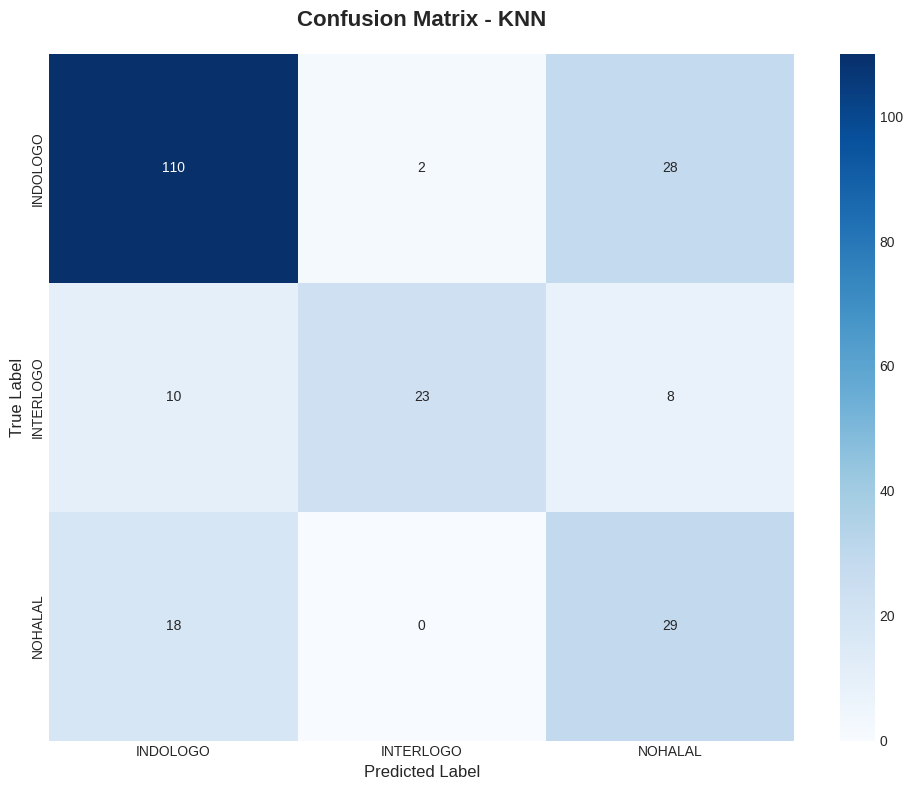

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/KNN/confusion_matrix_knn.png


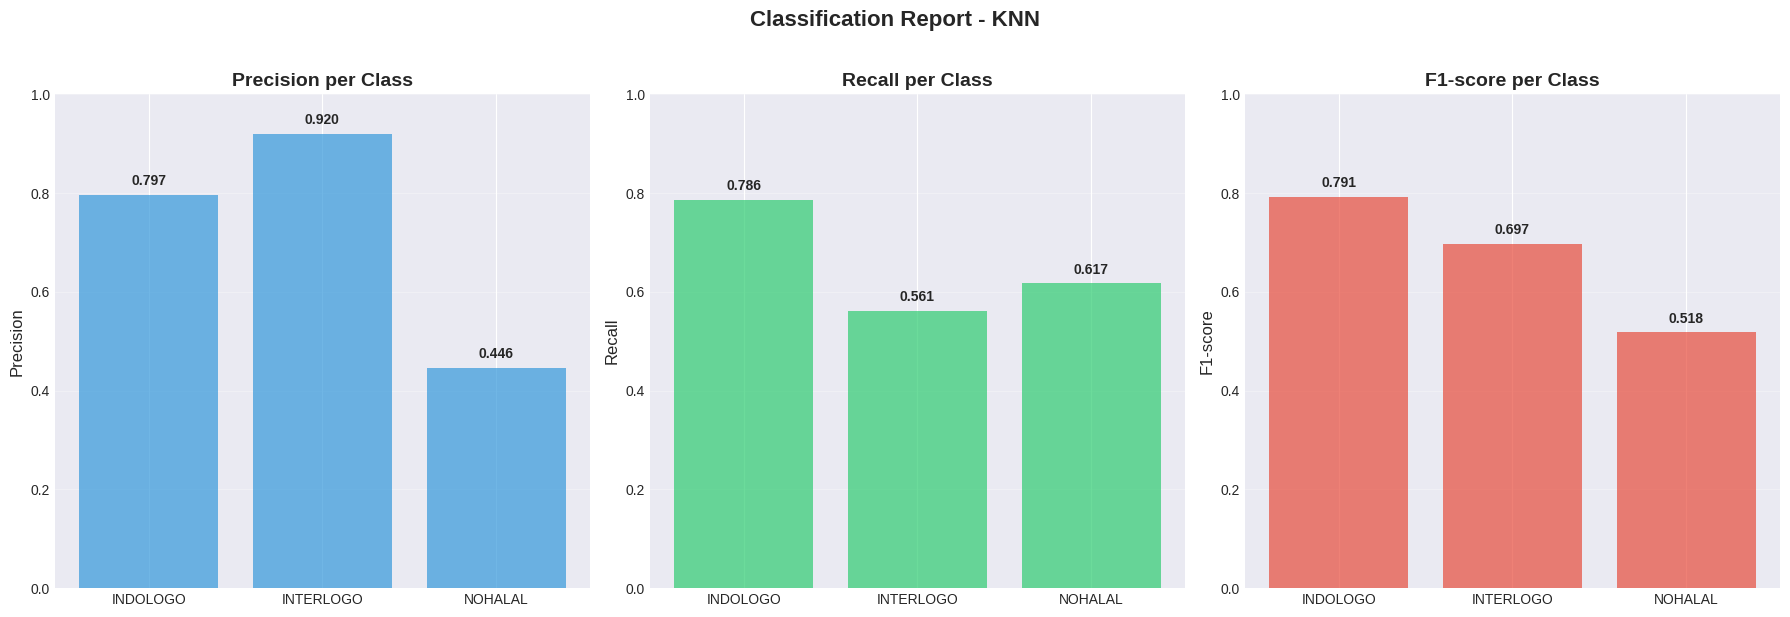

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/KNN/classification_report_knn.png

🔍 ERROR ANALYSIS - KNN
----------------------------------------------------------------------
Total misclassified: 66 / 228 (28.95%)

Top misclassification patterns:
   1. INDOLOGO → NOHALAL: 28 times
   2. NOHALAL → INDOLOGO: 18 times
   3. INTERLOGO → INDOLOGO: 10 times
   4. INTERLOGO → NOHALAL: 8 times
   5. INDOLOGO → INTERLOGO: 2 times


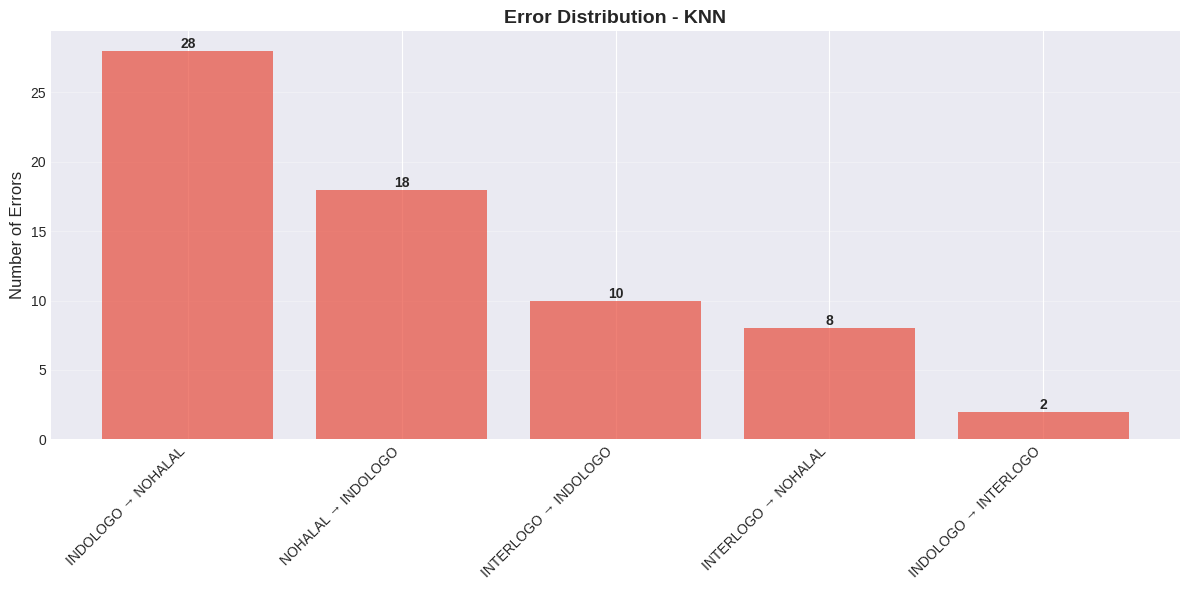

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/KNN/error_analysis_knn.png

💾 Model saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/KNN/best_knn_model.pkl
✅ KNN Training Complete!



In [ ]:
# ========================================
# 🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)
# ========================================

print("\n" + "="*70)
print("🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)")
print("="*70)

model_dir_knn = os.path.join(CLASSIC_FEATURES_DIR, 'KNN')

# Convert class_names dict to list (FIX)
class_names_list = [class_names_dict[i] for i in sorted(class_names_dict.keys())]

print("\n⏳ Training KNN dengan parameter optimal...")
print("   ├─ Neighbors: 5 (classic choice)")
print("   ├─ Weights: distance (closer neighbors = more weight)")
print("   ├─ Algorithm: auto (let sklearn choose)")
print("   └─ Parallel processing: All CPU cores")

start_time = time.time()

# Model KNN dengan parameter optimal
knn_model = KNeighborsClassifier(
    n_neighbors=5,      # Classic k=5
    weights='distance', # Weight by distance
    algorithm='auto',   # Let sklearn choose best
    n_jobs=-1          # Gunakan semua CPU cores
)

# Training (KNN tidak ada training sebenarnya, hanya menyimpan data)
print("\n🔄 Training in progress...")
knn_model.fit(X_train, y_train)

training_time_knn = time.time() - start_time
print(f"✅ Training completed in {training_time_knn:.2f} seconds ({training_time_knn/60:.2f} minutes)")

# Prediksi
print("\n🔮 Making predictions...")
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# Evaluasi
print("\n📊 EVALUATION RESULTS:")
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"   🎯 Accuracy:  {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")
print(f"   🎯 Precision: {precision_knn:.4f} ({precision_knn*100:.2f}%)")
print(f"   🎯 Recall:    {recall_knn:.4f} ({recall_knn*100:.2f}%)")
print(f"   🎯 F1-Score:  {f1_knn:.4f} ({f1_knn*100:.2f}%)")

# Classification Report Detail
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-" * 70)
report_knn = classification_report(y_test, y_pred_knn, target_names=class_names_list,
                                  digits=4, zero_division=0)
print(report_knn)

# Confusion Matrix
cm_knn = plot_confusion_matrix(y_test, y_pred_knn, class_names_list, 'KNN',
                               os.path.join(model_dir_knn, 'confusion_matrix_knn.png'))

# Classification Report dengan Plot
report_dict_knn = generate_classification_report_with_plot(y_test, y_pred_knn, class_names_list,
                                                           'KNN', model_dir_knn)

# Error Analysis
error_analysis_knn = perform_error_analysis(knn_model, X_test, y_test, y_pred_knn,
                                           class_names_list, 'KNN', model_dir_knn)

# Simpan model
model_path_knn = os.path.join(model_dir_knn, 'best_knn_model.pkl')
with open(model_path_knn, 'wb') as f:
    pickle.dump(knn_model, f)
print(f"\n💾 Model saved: {model_path_knn}")

# Simpan hasil
all_results['KNN'] = {
    'model': knn_model,
    'accuracy': accuracy_knn,
    'precision': precision_knn,
    'recall': recall_knn,
    'f1_score': f1_knn,
    'training_time': training_time_knn,
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn,
    'confusion_matrix': cm_knn,
    'classification_report': report_dict_knn,
    'error_analysis': error_analysis_knn
}

print("✅ KNN Training Complete!\n")

## 5: Perbandingan Komprehensif (Untuk Analisis Ulang)

In [ ]:
# ========================================
# 🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN) - FIXED
# ========================================

print("\n" + "="*70)
print("🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)")
print("="*70)

model_dir_knn = os.path.join(CLASSIC_FEATURES_DIR, 'KNN')

print("\n⏳ Training KNN dengan parameter optimal...")
print("   ├─ Neighbors: 5 (classic choice)")
print("   ├─ Weights: distance (closer neighbors = more weight)")
print("   ├─ Algorithm: auto (let sklearn choose)")
print("   └─ Parallel processing: All CPU cores")

start_time = time.time()

# Model KNN dengan parameter optimal
knn_model = KNeighborsClassifier(
    n_neighbors=5,      # Classic k=5
    weights='distance', # Weight by distance
    algorithm='auto',   # Let sklearn choose best
    n_jobs=-1          # Gunakan semua CPU cores
)

# Training (KNN tidak ada training sebenarnya, hanya menyimpan data)
print("\n🔄 Training in progress...")
knn_model.fit(X_train, y_train)

training_time_knn = time.time() - start_time
print(f"✅ Training completed in {training_time_knn:.2f} seconds ({training_time_knn/60:.2f} minutes)")

# Prediksi
print("\n🔮 Making predictions...")
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# Evaluasi
print("\n📊 EVALUATION RESULTS:")
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"   🎯 Accuracy:  {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")
print(f"   🎯 Precision: {precision_knn:.4f} ({precision_knn*100:.2f}%)")
print(f"   🎯 Recall:    {recall_knn:.4f} ({recall_knn*100:.2f}%)")
print(f"   🎯 F1-Score:  {f1_knn:.4f} ({f1_knn*100:.2f}%)")

# Classification Report Detail - FIXED
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-" * 70)
report_knn = classification_report(y_test, y_pred_knn, target_names=class_names_str,
                                  digits=4, zero_division=0)
print(report_knn)

# Confusion Matrix - FIXED
print("\n📊 Generating Confusion Matrix...")
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names_str,
            yticklabels=class_names_str)
plt.title(f'Confusion Matrix - KNN', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_path_knn = os.path.join(model_dir_knn, 'confusion_matrix_knn.png')
plt.savefig(cm_path_knn, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Confusion matrix saved: {cm_path_knn}")

# Classification Report dengan Plot - FIXED
print("\n📊 Generating Classification Report Plot...")
report_dict_knn = classification_report(y_test, y_pred_knn,
                                        target_names=class_names_str,
                                        output_dict=True,
                                        zero_division=0)

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['precision', 'recall', 'f1-score', 'support']
colors = ['#e67e22', '#f39c12', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    if metric == 'support':
        values = [report_dict_knn[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylabel('Count')
    else:
        values = [report_dict_knn[cls][metric] for cls in class_names_str]
        ax.bar(class_names_str, values, color=colors[idx], alpha=0.7)
        ax.set_ylim([0, 1])
        ax.set_ylabel('Score')
        ax.axhline(y=report_dict_knn['weighted avg'][metric],
                   color='red', linestyle='--', linewidth=2,
                   label=f"Weighted Avg: {report_dict_knn['weighted avg'][metric]:.4f}")
        ax.legend()

    ax.set_title(f'{metric.capitalize()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Class')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('KNN - Classification Report per Class',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

report_plot_path_knn = os.path.join(model_dir_knn, 'classification_report_knn.png')
plt.savefig(report_plot_path_knn, dpi=300, bbox_inches='tight')
plt.close()
print(f"   💾 Classification report plot saved: {report_plot_path_knn}")

# Error Analysis - FIXED
print("\n🔍 Performing Error Analysis...")
error_indices = np.where(y_test != y_pred_knn)[0]
correct_indices = np.where(y_test == y_pred_knn)[0]

print(f"   Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")
print(f"   Total correct: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")

# Per-class error analysis
print("\n   Per-class Error Analysis:")
for i, class_name in enumerate(class_names_str):
    class_mask = y_test == i
    class_errors = np.sum((y_test == i) & (y_pred_knn != i))
    class_total = np.sum(class_mask)
    class_correct = class_total - class_errors

    if class_total > 0:
        error_rate = (class_errors / class_total) * 100
        print(f"   Class '{class_name}': {class_correct}/{class_total} correct, "
              f"{class_errors} errors ({error_rate:.2f}% error rate)")

# Confusion pairs (most common misclassifications)
print("\n   Most Common Misclassifications:")
misclass_pairs = []
for true_label in range(len(class_names_str)):
    for pred_label in range(len(class_names_str)):
        if true_label != pred_label:
            count = np.sum((y_test == true_label) & (y_pred_knn == pred_label))
            if count > 0:
                misclass_pairs.append({
                    'true': class_names_str[true_label],
                    'predicted': class_names_str[pred_label],
                    'count': count
                })

misclass_pairs = sorted(misclass_pairs, key=lambda x: x['count'], reverse=True)[:5]
for pair in misclass_pairs:
    print(f"   {pair['true']} → {pair['predicted']}: {pair['count']} times")

# Save error analysis
error_analysis_knn = {
    'total_errors': len(error_indices),
    'total_correct': len(correct_indices),
    'error_rate': len(error_indices) / len(y_test),
    'misclassification_pairs': misclass_pairs
}

# Simpan model
model_path_knn = os.path.join(model_dir_knn, 'best_knn_model.pkl')
with open(model_path_knn, 'wb') as f:
    pickle.dump(knn_model, f)
print(f"\n💾 Model saved: {model_path_knn}")

# Simpan hasil
all_results['KNN'] = {
    'model': knn_model,
    'accuracy': accuracy_knn,
    'precision': precision_knn,
    'recall': recall_knn,
    'f1_score': f1_knn,
    'training_time': training_time_knn,
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn,
    'confusion_matrix': cm_knn,
    'classification_report': report_dict_knn,
    'error_analysis': error_analysis_knn
}

print("✅ KNN Training Complete!\n")
print("="*70)


🎯 MODEL 4: K-NEAREST NEIGHBORS (KNN)

⏳ Training KNN dengan parameter optimal...
   ├─ Neighbors: 5 (classic choice)
   ├─ Weights: distance (closer neighbors = more weight)
   ├─ Algorithm: auto (let sklearn choose)
   └─ Parallel processing: All CPU cores

🔄 Training in progress...
✅ Training completed in 0.03 seconds (0.00 minutes)

🔮 Making predictions...

📊 EVALUATION RESULTS:
   🎯 Accuracy:  0.7105 (71.05%)
   🎯 Precision: 0.7469 (74.69%)
   🎯 Recall:    0.7105 (71.05%)
   🎯 F1-Score:  0.7180 (71.80%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7971    0.7857    0.7914       140
           1     0.9200    0.5610    0.6970        41
           2     0.4462    0.6170    0.5179        47

    accuracy                         0.7105       228
   macro avg     0.7211    0.6546    0.6687       228
weighted avg     0.7469    0.7105    0.7180       228


## 6: Notebook untuk Analisis Ulang (Tanpa Training)


📂 Loading extracted features...
✅ Features loaded successfully!
   Total samples: 1139
   Features: 8304
   Classes: 3
   Class names: ['INDOLOGO', 'INTERLOGO', 'NOHALAL']

✅ Data split successfully!
   Training samples: 911
   Testing samples: 228
   Train distribution: [560 163 188]
   Test distribution: [140  41  47]

📂 Loading individual models...
   ✅ SVM loaded
   ✅ RandomForest loaded
   ✅ XGBoost loaded
   ✅ KNN loaded

✅ Loaded 4 models: ['SVM', 'RandomForest', 'XGBoost', 'KNN']

📊 Evaluating all models...

🔍 Evaluating SVM...
   Accuracy: 0.8114
   Precision: 0.8355
   Recall: 0.8114
   F1-Score: 0.7955

🔍 Evaluating RandomForest...
   Accuracy: 0.7675
   Precision: 0.8191
   Recall: 0.7675
   F1-Score: 0.7344

🔍 Evaluating XGBoost...
   Accuracy: 0.8202
   Precision: 0.8484
   Recall: 0.8202
   F1-Score: 0.7974

🔍 Evaluating KNN...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


   Accuracy: 0.7105
   Precision: 0.7469
   Recall: 0.7105
   F1-Score: 0.7180

✅ All models evaluated!

📊 Creating comparison table...

📋 MODEL PERFORMANCE COMPARISON
       Model  Accuracy  Precision   Recall  F1-Score
     XGBoost  0.820175   0.848392 0.820175  0.797353
         SVM  0.811404   0.835467 0.811404  0.795487
RandomForest  0.767544   0.819085 0.767544  0.734403
         KNN  0.710526   0.746857 0.710526  0.718011

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/model_comparison.csv

📊 Creating comparison visualizations...


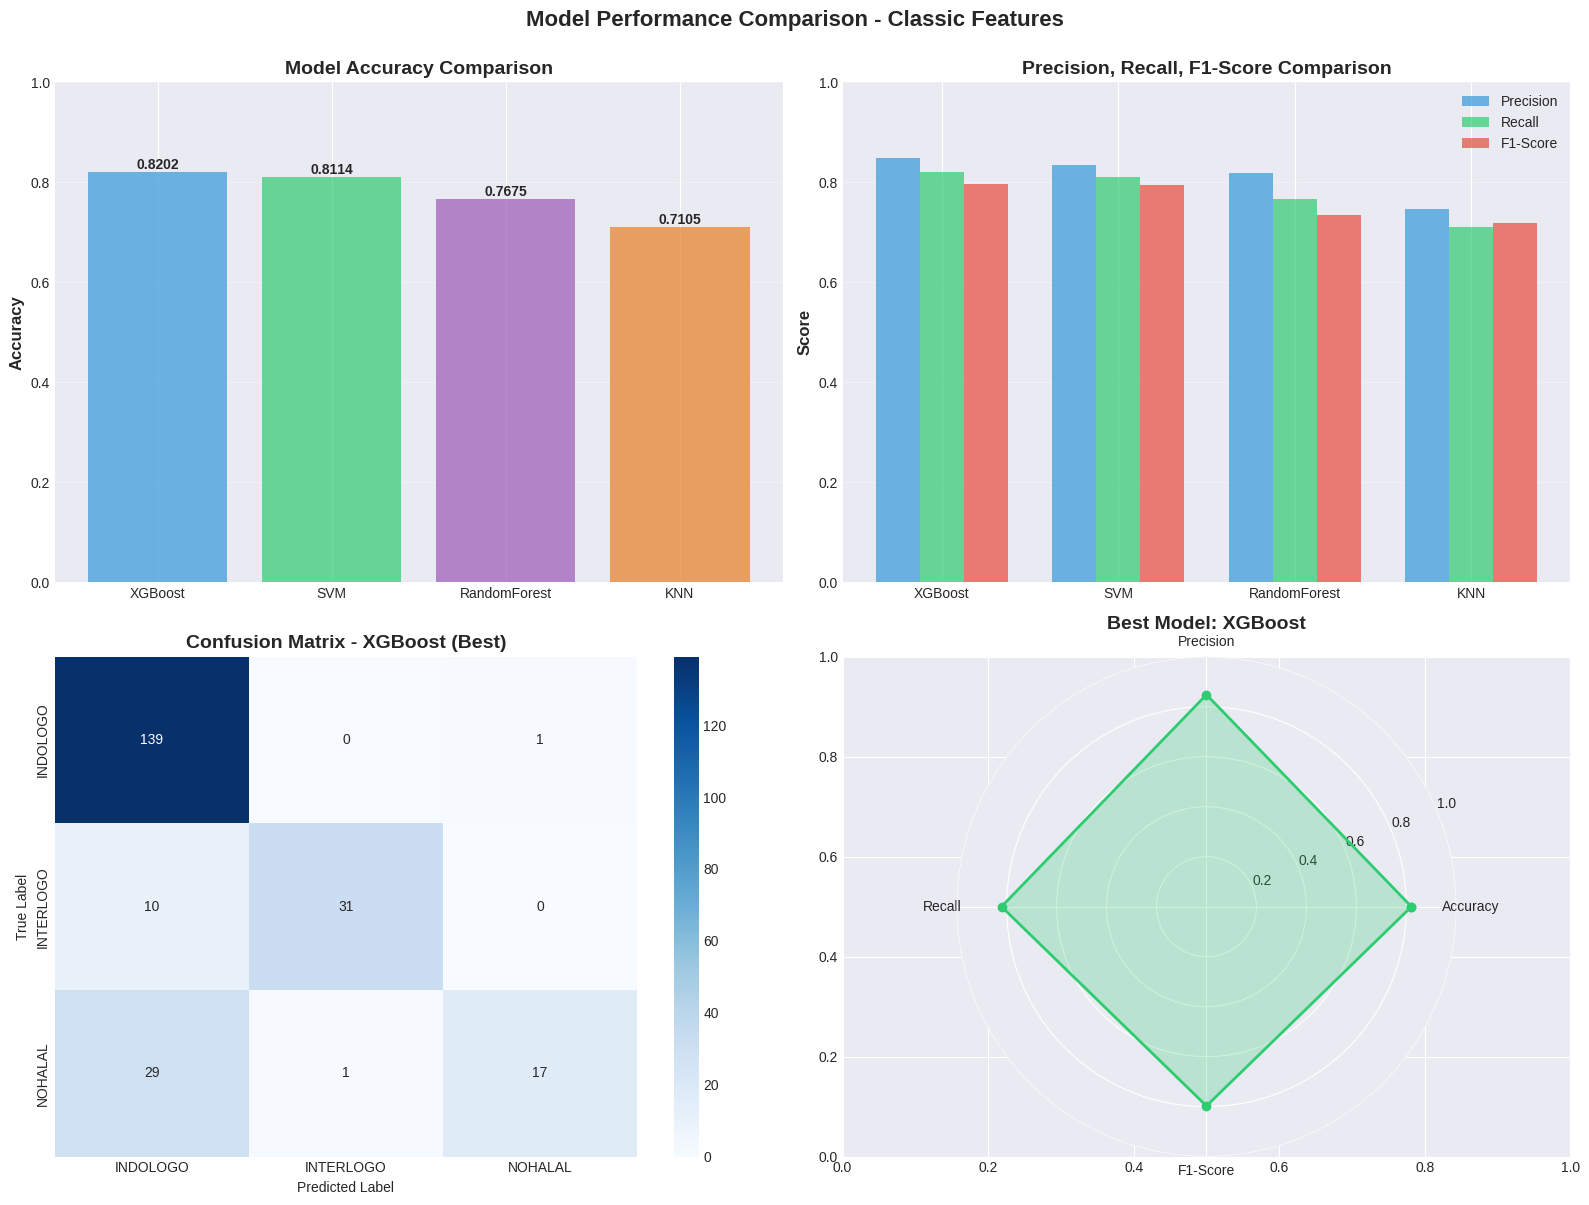

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/model_comparison_overview.png

🎯 Creating Ensemble Prediction (Majority Voting)...

🎯 ENSEMBLE RESULTS (Majority Voting)
Accuracy:  0.7851 (78.51%)
Precision: 0.8303 (83.03%)
Recall:    0.7851 (78.51%)
F1-Score:  0.7579 (75.79%)


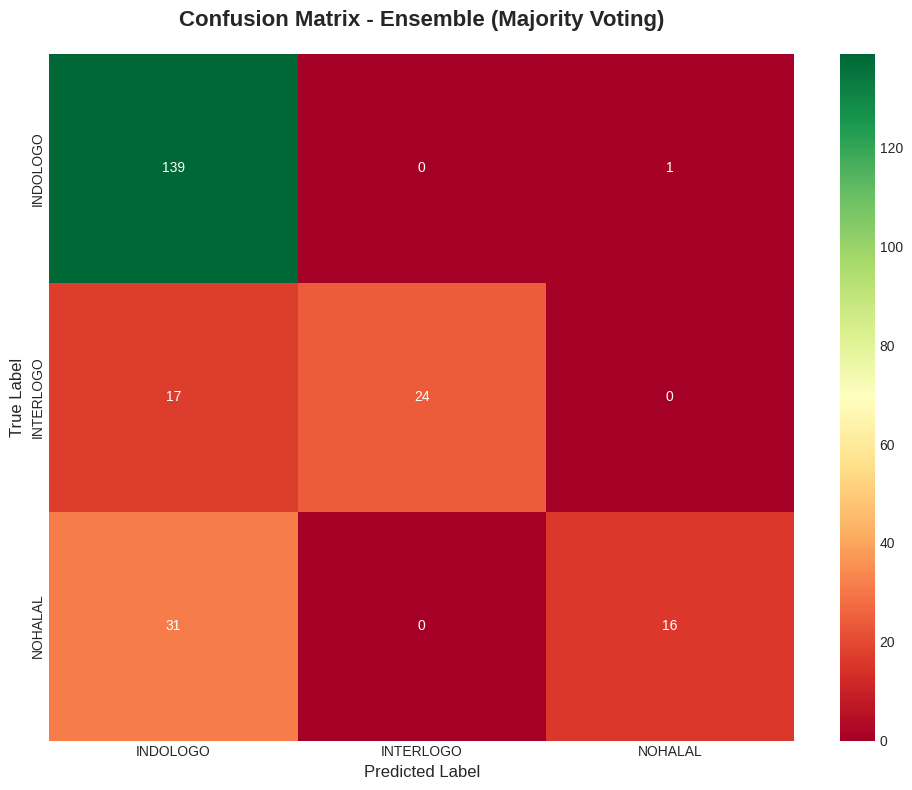

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/confusion_matrix_ensemble.png

📊 Creating per-class performance benchmark...


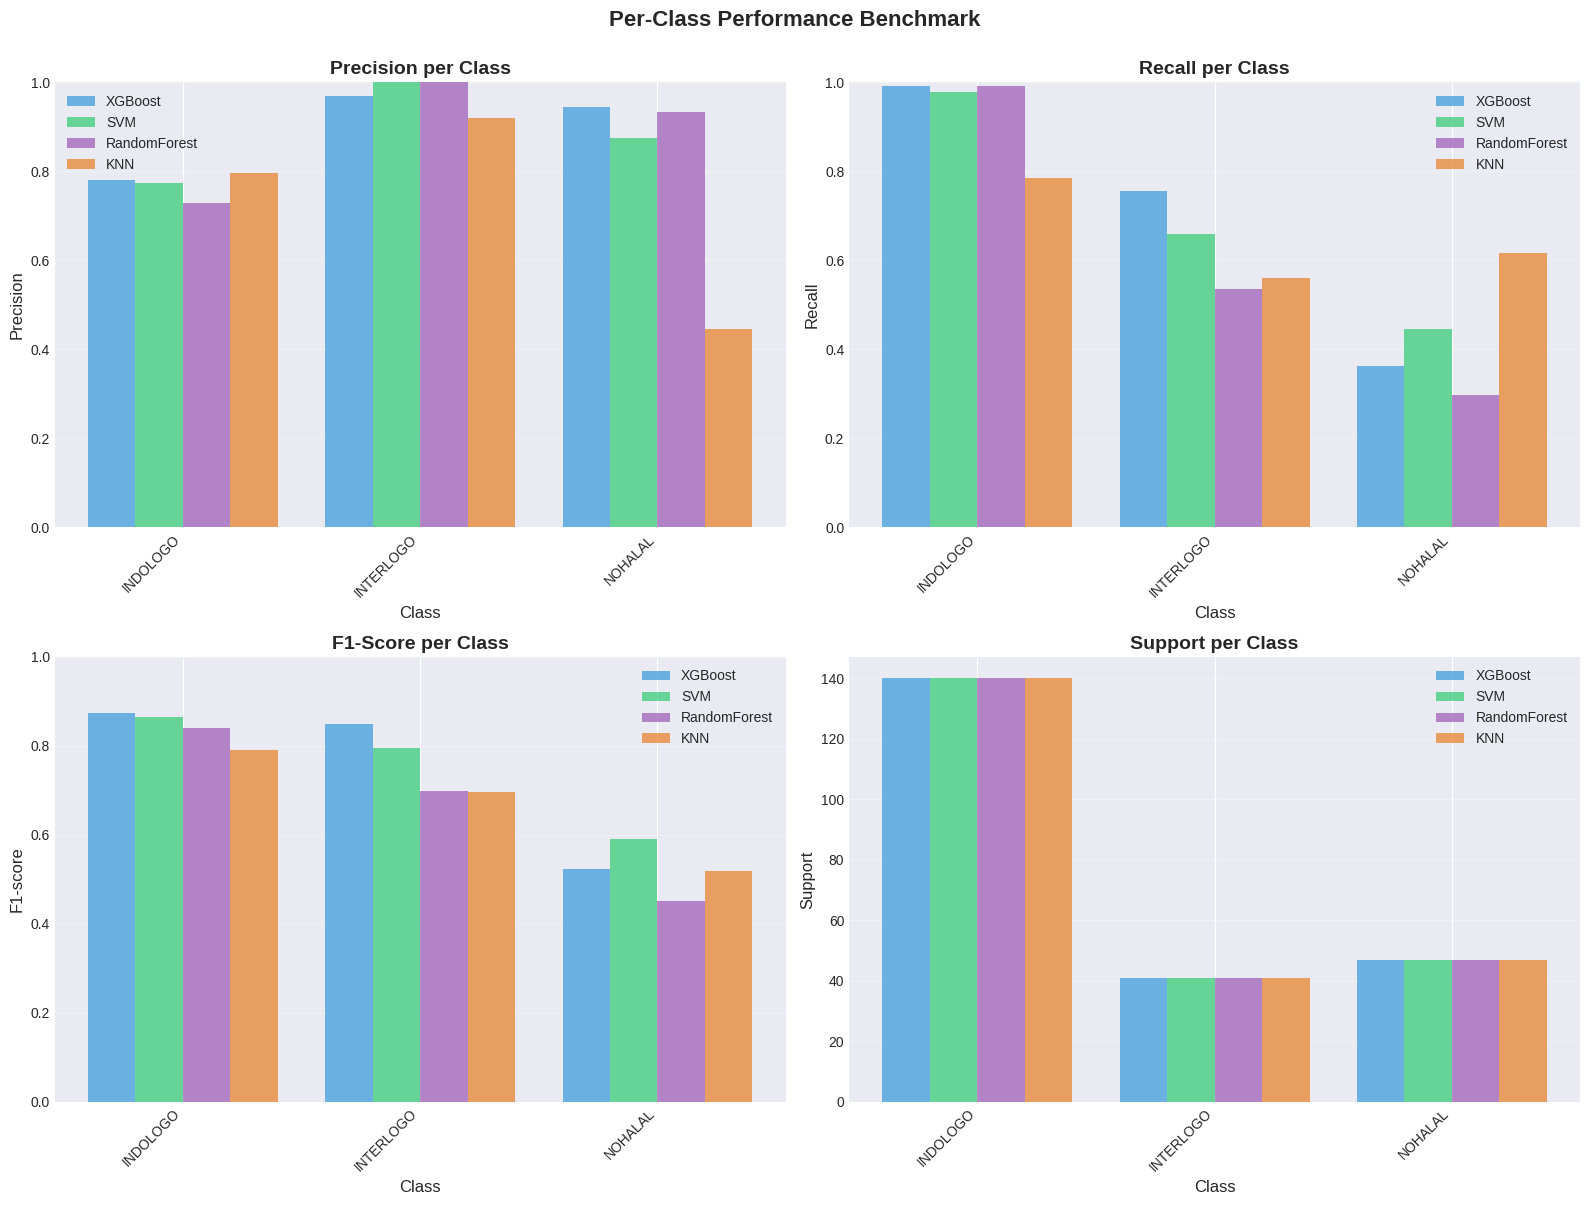

💾 Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/benchmark_performance_per_label.png

💾 Saving final results...
✅ Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/all_models_results.pkl

📄 Generating final analysis report...
✅ Saved: /content/drive/MyDrive/Machine-Learning-Experiment/results/4_Ekstraksi_Fitur_Klasik/final_analysis_report.txt

✅ ANALYSIS COMPLETE!

Generated files:
   • all_models_results.pkl
   • model_comparison.csv
   • model_comparison_overview.png
   • confusion_matrix_ensemble.png
   • benchmark_performance_per_label.png
   • final_analysis_report.txt


In [ ]:
# CELL 2 (FINAL): Load & Split Extracted Features
print("\n📂 Loading extracted features...")

feature_data_path = os.path.join(CLASSIC_FEATURES_DIR, 'extracted_features.pkl')
with open(feature_data_path, 'rb') as f:
    feature_data = pickle.load(f)

# Extract data
X = feature_data['X_normalized']  # Gunakan normalized features
y = feature_data['y']
class_names_dict = feature_data['class_names']
scaler = feature_data['scaler']

# Convert class_names dict to list
class_names_str = [class_names_dict[i] for i in sorted(class_names_dict.keys())]

print(f"✅ Features loaded successfully!")
print(f"   Total samples: {X.shape[0]}")
print(f"   Features: {X.shape[1]}")
print(f"   Classes: {len(class_names_str)}")
print(f"   Class names: {class_names_str}")

# Split data (80% train, 20% test) - SAMA SEPERTI SAAT TRAINING
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data split successfully!")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Train distribution: {np.bincount(y_train)}")
print(f"   Test distribution: {np.bincount(y_test)}")

# CELL 3: Load Individual Models (SAMA SEPERTI SEBELUMNYA)
print("\n📂 Loading individual models...")

models = {}
model_names = ['SVM', 'RandomForest', 'XGBoost', 'KNN']

for model_name in model_names:
    model_dir = os.path.join(CLASSIC_FEATURES_DIR, model_name)

    # Cari file model
    model_files = {
        'SVM': 'best_svm_model.pkl',
        'RandomForest': 'best_rf_model.pkl',
        'XGBoost': 'best_xgb_model.pkl',
        'KNN': 'best_knn_model.pkl'
    }

    model_path = os.path.join(model_dir, model_files[model_name])

    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            models[model_name] = pickle.load(f)
        print(f"   ✅ {model_name} loaded")
    else:
        print(f"   ❌ {model_name} not found at {model_path}")

print(f"\n✅ Loaded {len(models)} models: {list(models.keys())}")

# CELL 4: Evaluate All Models
print("\n📊 Evaluating all models...")

all_results = {}

for model_name, model in models.items():
    print(f"\n🔍 Evaluating {model_name}...")

    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung metrik
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names_str,
                                  output_dict=True, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    all_results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': cm
    }

    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")

print("\n✅ All models evaluated!")

# CELL 5: Create Comparison Table
print("\n📊 Creating comparison table...")

comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("📋 MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Save comparison table
comparison_path = os.path.join(CLASSIC_FEATURES_DIR, 'model_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"\n💾 Saved: {comparison_path}")

# CELL 6: Visualisasi Perbandingan Model
print("\n📊 Creating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.7)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Precision, Recall, F1-Score
ax2 = axes[0, 1]
x = np.arange(len(comparison_df))
width = 0.25
ax2.bar(x - width, comparison_df['Precision'], width, label='Precision', color='#3498db', alpha=0.7)
ax2.bar(x, comparison_df['Recall'], width, label='Recall', color='#2ecc71', alpha=0.7)
ax2.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.7)
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Precision, Recall, F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'])
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Confusion Matrix Heatmap (Best Model)
ax3 = axes[1, 0]
best_model_name = comparison_df.iloc[0]['Model']
best_cm = all_results[best_model_name]['confusion_matrix']
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=class_names_str, yticklabels=class_names_str)
ax3.set_title(f'Confusion Matrix - {best_model_name} (Best)', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# Plot 4: Overall Performance Radar (Best Model)
ax4 = plt.subplot(2, 2, 4, projection='polar')
best_model = all_results[best_model_name]
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [
    best_model['accuracy'],
    best_model['precision'],
    best_model['recall'],
    best_model['f1_score']
]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
ax4.plot(angles, values, 'o-', linewidth=2, color='#2ecc71')
ax4.fill(angles, values, alpha=0.25, color='#2ecc71')
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_ylim(0, 1)
ax4.set_title(f'Best Model: {best_model_name}', fontsize=14, fontweight='bold', pad=20)
ax4.grid(True)

plt.suptitle('Model Performance Comparison - Classic Features',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

comparison_plot_path = os.path.join(CLASSIC_FEATURES_DIR, 'model_comparison_overview.png')
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {comparison_plot_path}")

# CELL 7: Ensemble Prediction (Majority Voting)
print("\n🎯 Creating Ensemble Prediction (Majority Voting)...")

# Collect all predictions
all_predictions = np.array([results['y_pred'] for results in all_results.values()])

# Majority voting
ensemble_pred = stats.mode(all_predictions, axis=0, keepdims=False)[0]

# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_precision = precision_score(y_test, ensemble_pred, average='weighted', zero_division=0)
ensemble_recall = recall_score(y_test, ensemble_pred, average='weighted', zero_division=0)
ensemble_f1 = f1_score(y_test, ensemble_pred, average='weighted', zero_division=0)

print("\n" + "="*70)
print("🎯 ENSEMBLE RESULTS (Majority Voting)")
print("="*70)
print(f"Accuracy:  {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print(f"Precision: {ensemble_precision:.4f} ({ensemble_precision*100:.2f}%)")
print(f"Recall:    {ensemble_recall:.4f} ({ensemble_recall*100:.2f}%)")
print(f"F1-Score:  {ensemble_f1:.4f} ({ensemble_f1*100:.2f}%)")
print("="*70)

# Ensemble Confusion Matrix
cm_ensemble = confusion_matrix(y_test, ensemble_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=class_names_str,
            yticklabels=class_names_str)
plt.title('Confusion Matrix - Ensemble (Majority Voting)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_ensemble_path = os.path.join(CLASSIC_FEATURES_DIR, 'confusion_matrix_ensemble.png')
plt.savefig(cm_ensemble_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {cm_ensemble_path}")

# CELL 8: Per-Class Performance Benchmark
print("\n📊 Creating per-class performance benchmark...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['precision', 'recall', 'f1-score', 'support']
metric_titles = ['Precision per Class', 'Recall per Class', 'F1-Score per Class', 'Support per Class']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx // 2, idx % 2]

    # Collect data for each model
    model_data = {}
    for model_name in comparison_df['Model']:
        report = all_results[model_name]['classification_report']
        model_data[model_name] = [report[cls][metric] for cls in class_names_str]

    # Plot
    x = np.arange(len(class_names_str))
    width = 0.2

    for i, (model_name, color) in enumerate(zip(comparison_df['Model'], colors)):
        offset = width * (i - 1.5)
        ax.bar(x + offset, model_data[model_name], width, label=model_name, color=color, alpha=0.7)

    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names_str, rotation=45, ha='right')
    if metric != 'support':
        ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Per-Class Performance Benchmark', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

benchmark_path = os.path.join(CLASSIC_FEATURES_DIR, 'benchmark_performance_per_label.png')
plt.savefig(benchmark_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {benchmark_path}")

# CELL 9: Save Final Results
print("\n💾 Saving final results...")

final_results = {
    'individual_models': all_results,
    'comparison_df': comparison_df,
    'ensemble_accuracy': ensemble_accuracy,
    'ensemble_precision': ensemble_precision,
    'ensemble_recall': ensemble_recall,
    'ensemble_f1': ensemble_f1,
    'ensemble_pred': ensemble_pred,
    'ensemble_confusion_matrix': cm_ensemble,
    'best_model': comparison_df.iloc[0]['Model'],
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'class_names': class_names_str
}

final_results_path = os.path.join(CLASSIC_FEATURES_DIR, 'all_models_results.pkl')
with open(final_results_path, 'wb') as f:
    pickle.dump(final_results, f)
print(f"✅ Saved: {final_results_path}")

# CELL 10: Generate Final Report
print("\n📄 Generating final analysis report...")

report_lines = []
report_lines.append("="*80)
report_lines.append("FINAL ANALYSIS REPORT - CLASSIC FEATURES EXTRACTION")
report_lines.append("="*80)
report_lines.append("")
report_lines.append("1. DATASET INFORMATION")
report_lines.append("-" * 80)
report_lines.append(f"   Total samples:    {X.shape[0]}")
report_lines.append(f"   Training samples: {X_train.shape[0]}")
report_lines.append(f"   Testing samples:  {X_test.shape[0]}")
report_lines.append(f"   Features:         {X_train.shape[1]}")
report_lines.append(f"   Classes:          {len(class_names_str)}")
report_lines.append(f"   Class names:      {', '.join(class_names_str)}")
report_lines.append("")

report_lines.append("2. MODEL PERFORMANCE COMPARISON")
report_lines.append("-" * 80)
report_lines.append(comparison_df.to_string(index=False))
report_lines.append("")

best_model_name = comparison_df.iloc[0]['Model']
best_model = all_results[best_model_name]

report_lines.append("3. BEST MODEL")
report_lines.append("-" * 80)
report_lines.append(f"   Model: {best_model_name}")
report_lines.append(f"   Accuracy:  {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.2f}%)")
report_lines.append(f"   Precision: {best_model['precision']:.4f} ({best_model['precision']*100:.2f}%)")
report_lines.append(f"   Recall:    {best_model['recall']:.4f} ({best_model['recall']*100:.2f}%)")
report_lines.append(f"   F1-Score:  {best_model['f1_score']:.4f} ({best_model['f1_score']*100:.2f}%)")
report_lines.append("")

report_lines.append("4. ENSEMBLE PERFORMANCE (Majority Voting)")
report_lines.append("-" * 80)
report_lines.append(f"   Accuracy:  {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
report_lines.append(f"   Precision: {ensemble_precision:.4f} ({ensemble_precision*100:.2f}%)")
report_lines.append(f"   Recall:    {ensemble_recall:.4f} ({ensemble_recall*100:.2f}%)")
report_lines.append(f"   F1-Score:  {ensemble_f1:.4f} ({ensemble_f1*100:.2f}%)")
report_lines.append("")

report_lines.append("5. KEY FINDINGS")
report_lines.append("-" * 80)
best_acc = comparison_df.iloc[0]['Accuracy']
worst_acc = comparison_df.iloc[-1]['Accuracy']
report_lines.append(f"   • Best performing model: {best_model_name} ({best_acc:.4f})")
report_lines.append(f"   • Lowest performing model: {comparison_df.iloc[-1]['Model']} ({worst_acc:.4f})")
report_lines.append(f"   • Performance gap: {(best_acc - worst_acc):.4f}")
improvement = ensemble_accuracy - best_acc
report_lines.append(f"   • Ensemble vs best: {improvement:+.4f} ({'improvement' if improvement > 0 else 'decline'})")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("END OF REPORT")
report_lines.append("="*80)

report_content = "\n".join(report_lines)
report_path = os.path.join(CLASSIC_FEATURES_DIR, 'final_analysis_report.txt')
with open(report_path, 'w') as f:
    f.write(report_content)
print(f"✅ Saved: {report_path}")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)
print("\nGenerated files:")
print("   • all_models_results.pkl")
print("   • model_comparison.csv")
print("   • model_comparison_overview.png")
print("   • confusion_matrix_ensemble.png")
print("   • benchmark_performance_per_label.png")
print("   • final_analysis_report.txt")
print("="*70)

In [ ]:
# CELL 2 (REVISED): Check & Load Extracted Features
print("\n📂 Checking extracted features structure...")

feature_data_path = os.path.join(CLASSIC_FEATURES_DIR, 'extracted_features.pkl')
with open(feature_data_path, 'rb') as f:
    feature_data = pickle.load(f)

print("\n🔍 Keys in extracted_features.pkl:")
print(list(feature_data.keys()))

print("\n📊 Data structure:")
for key, value in feature_data.items():
    if isinstance(value, np.ndarray):
        print(f"   {key}: shape {value.shape}, dtype {value.dtype}")
    elif isinstance(value, list):
        print(f"   {key}: list with {len(value)} items")
    else:
        print(f"   {key}: {type(value)}")

# Coba ekstrak data berdasarkan struktur yang ada
if 'features' in feature_data and 'labels' in feature_data:
    print("\n✅ Found 'features' and 'labels' keys!")

    from sklearn.model_selection import train_test_split

    X = feature_data['features']
    y = feature_data['labels']

    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Get class names
    if 'class_names' in feature_data:
        class_names_str = feature_data['class_names']
    else:
        # Buat class names dari unique labels
        unique_labels = np.unique(y)
        class_names_str = [f"Class_{i}" for i in unique_labels]

    print(f"\n✅ Data loaded and split successfully!")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Testing samples: {X_test.shape[0]}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Classes: {len(class_names_str)}")
    print(f"   Class names: {class_names_str}")

elif 'X_train' in feature_data:
    print("\n✅ Found train/test split keys!")
    X_train = feature_data['X_train']
    X_test = feature_data['X_test']
    y_train = feature_data['y_train']
    y_test = feature_data['y_test']
    class_names_str = feature_data.get('class_names', [f"Class_{i}" for i in np.unique(y_train)])

    print(f"\n✅ Data loaded successfully!")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Testing samples: {X_test.shape[0]}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Classes: {len(class_names_str)}")
    print(f"   Class names: {class_names_str}")

else:
    print("\n❌ Unknown data structure!")
    print("Please check the file manually.")


📂 Checking extracted features structure...

🔍 Keys in extracted_features.pkl:
['X', 'X_normalized', 'y', 'image_paths', 'class_names', 'scaler']

📊 Data structure:
   X: shape (1139, 8304), dtype float64
   X_normalized: shape (1139, 8304), dtype float64
   y: shape (1139,), dtype int64
   image_paths: list with 1139 items
   class_names: <class 'dict'>
   scaler: <class 'sklearn.preprocessing._data.StandardScaler'>

❌ Unknown data structure!
Please check the file manually.


# Sistem Pengujian Komprehensif dengan 4 Model Machine Learning

> Berdasarkan karakteristik dataset logo halal (gambar dengan pola geometris, tekstur, dan warna dominan), saya merekomendasikan 4 model berikut untuk pengujian komprehensif.

---

### 1. SVM (Support Vector Machine)
* **Status:** `Sudah ada` (akan digunakan sebagai **baseline** perbandingan).
* **Karakteristik:** Efektif di ruang berdimensi tinggi dan baik ketika jumlah dimensi lebih besar dari jumlah sampel.

### 2. Random Forest
* **Alasan Pemilihan:** Sangat baik untuk menangani fitur-fitur kompleks dan *robust* (kuat) terhadap *overfitting*. Model ini juga mudah diinterpretasi untuk melihat fitur apa yang paling penting.

### 3. XGBoost (Extreme Gradient Boosting)
* **Alasan Pemilihan:** Dianggap sebagai model *state-of-the-art* untuk data tabular (seperti vektor fitur Anda). Sering memberikan performa akurasi tertinggi dan sangat efisien.

### 4. KNN (K-Nearest Neighbors)
* **Alasan Pemilihan:** Model yang sederhana namun bisa sangat efektif untuk *pattern matching* visual. Model ini bekerja dengan asumsi bahwa gambar yang mirip akan memiliki fitur yang berdekatan.

---

Mari kita buat program terstruktur untuk melatih dan mengevaluasi setiap model ini secara berurutan.

# DEEP LEARNING USING Convusional Neural Network (CNN)

# **Deep Learning Implementation: CNN & CNN with LoRA Fine-Tuning**

Baik, pada bagian ini kita akan membuat dua jenis program Deep Learning yang disesuaikan dengan dataset Anda (1139 gambar), yaitu:

1. **CNN (Training From Scratch / CNN Normal)**
2. **CNN with LoRA Fine-Tuning (Low-Rank Adaptation)**

Kedua model akan disimpan pada struktur folder berikut:



# **1. ORIGINAL CNN (CNN KLASIK)**

# CELL 1: Setup & Import Libraries

In [6]:
# ========================================
# CELL 1: Setup & Import Libraries
# ========================================

from google.colab import drive
import os
import sys
import shutil
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Setup base directories
BASE_DIR = '/content/drive/MyDrive/Machine-Learning-Experiment'
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

CLASSIC_FEATURES_DIR = os.path.join(RESULTS_DIR, '4_Ekstraksi_Fitur_Klasik')
DEEP_LEARNING_DIR = os.path.join(RESULTS_DIR, '5_Deep_Learning')
CLASSIFICATION_DATASET_DIR = os.path.join(DEEP_LEARNING_DIR, 'classification_dataset')

CNN_CLASSIC_DIR = os.path.join(DEEP_LEARNING_DIR, 'CNN_Klasik')
CNN_AUG_DIR = os.path.join(DEEP_LEARNING_DIR, 'CNN_Augmentasi')

# Buat folder yang dibutuhkan
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CLASSIC_FEATURES_DIR, exist_ok=True)
os.makedirs(DEEP_LEARNING_DIR, exist_ok=True)
os.makedirs(CLASSIFICATION_DATASET_DIR, exist_ok=True)
os.makedirs(CNN_CLASSIC_DIR, exist_ok=True)
os.makedirs(os.path.join(CNN_CLASSIC_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(CNN_CLASSIC_DIR, 'history'), exist_ok=True)
os.makedirs(os.path.join(CNN_CLASSIC_DIR, 'plots'), exist_ok=True)
os.makedirs(CNN_AUG_DIR, exist_ok=True)
os.makedirs(os.path.join(CNN_AUG_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(CNN_AUG_DIR, 'history'), exist_ok=True)
os.makedirs(os.path.join(CNN_AUG_DIR, 'plots'), exist_ok=True)

# Tambahan folder untuk eksperimen LoRA
CNN_CLASSIC_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'CNN_Klasik_LoRA')
CNN_AUG_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'CNN_Augmentasi_LoRA')

os.makedirs(os.path.join(CNN_CLASSIC_LORA_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(CNN_CLASSIC_LORA_DIR, 'history'), exist_ok=True)
os.makedirs(os.path.join(CNN_CLASSIC_LORA_DIR, 'plots'), exist_ok=True)
# Tambahan folder untuk XAI di CNN_Klasik_LoRA
os.makedirs(os.path.join(CNN_CLASSIC_LORA_DIR, 'xai'), exist_ok=True)

os.makedirs(os.path.join(CNN_AUG_LORA_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(CNN_AUG_LORA_DIR, 'history'), exist_ok=True)
os.makedirs(os.path.join(CNN_AUG_LORA_DIR, 'plots'), exist_ok=True)

# Folder untuk eksperimen ViT + LoRA
VIT_MANUAL_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'ViT_Manual_LoRA')
VIT_PRETRAINED_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'ViT_Pretrained_LoRA')

for d in [VIT_MANUAL_LORA_DIR, VIT_PRETRAINED_LORA_DIR]:
    os.makedirs(os.path.join(d, 'models'), exist_ok=True)
    os.makedirs(os.path.join(d, 'history'), exist_ok=True)
    os.makedirs(os.path.join(d, 'plots'), exist_ok=True)

EffNET_PRETRAINED_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'EffNet_Pretrained_LoRA')
os.makedirs(os.path.join(EffNET_PRETRAINED_LORA_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(EffNET_PRETRAINED_LORA_DIR, 'history'), exist_ok=True)
os.makedirs(os.path.join(EffNET_PRETRAINED_LORA_DIR, 'plots'), exist_ok=True)

print("✅ Google Drive berhasil di-mount!")
print(f"📁 Base Directory: {BASE_DIR}")
print(f"📁 Dataset Directory: {DATASET_DIR}")
print(f"📁 Results Directory: {RESULTS_DIR}")
print(f"📁 Deep Learning Directory: {DEEP_LEARNING_DIR}")
print("📁 LoRA dirs:")
print("   CNN Klasik + LoRA       :", CNN_CLASSIC_LORA_DIR)
print("   CNN Augmentasi + LoRA   :", CNN_AUG_LORA_DIR)
print("📁 ViT Manual + LoRA:", VIT_MANUAL_LORA_DIR)
print("📁 ViT Pretrained + LoRA:", VIT_PRETRAINED_LORA_DIR)
print("📁 EffNet Pretrained + LoRA:", EffNET_PRETRAINED_LORA_DIR)
print("📁 XAI dir for CNN Klasik + LoRA:", os.path.join(CNN_CLASSIC_LORA_DIR, 'xai'))

# 3. Tentukan path dataset YOLO (hasil dari program kamu sebelumnya)
DATASET_PATH = os.path.join(DATASET_DIR, 'namaikna-2')
DATA_YAML_PATH = os.path.join(DATASET_PATH, 'data.yaml')

assert os.path.exists(DATASET_PATH), f"Dataset path tidak ditemukan: {DATASET_PATH}"
assert os.path.exists(DATA_YAML_PATH), f"data.yaml tidak ditemukan di: {DATA_YAML_PATH}"

# 4. Load informasi kelas dari data.yaml
with open(DATA_YAML_PATH, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']  # dict: {0: 'INDOLOGO', 1: 'INTERLOGO', 2: 'NOHALAL'}

print("\n🏷️  Classes:")
for idx, name in class_names.items():
    print(f"   {idx}: {name}")

# Set ukuran input gambar untuk CNN
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

print("\n✅ Setup selesai!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive berhasil di-mount!
📁 Base Directory: /content/drive/MyDrive/Machine-Learning-Experiment
📁 Dataset Directory: /content/drive/MyDrive/Machine-Learning-Experiment/datasets
📁 Results Directory: /content/drive/MyDrive/Machine-Learning-Experiment/results
📁 Deep Learning Directory: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning
📁 LoRA dirs:
   CNN Klasik + LoRA       : /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA
   CNN Augmentasi + LoRA   : /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA
📁 ViT Manual + LoRA: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA
📁 ViT Pretrained + LoRA: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Pretrained_LoRA
📁 EffNet Pretrai

# CELL 2: Load & Explore Dataset (EDA) – Konversi YOLO → Klasifikasi

> Di sini kita:

Membaca setiap gambar + file label (YOLO OBB)
Mengambil bounding box pertama (simplifikasi; kalau ada banyak objek, bisa di-loop)
Men-crop objek menjadi gambar kecil
Menyimpan ke struktur klasifikasi: classification_dataset/train/INDOLOGO, dst.
Sekaligus melakukan EDA sederhana: jumlah gambar per kelas.

In [7]:
# ========================================
# CELL 2: Konversi YOLO OBB → Dataset Klasifikasi
# Hanya gunakan split 'train' dan 'test'
# ========================================

def yolo_obb_to_xyxy(line, img_width, img_height):
    """
    Parse satu baris anotasi YOLO OBB dan ubah menjadi bbox axis-aligned sederhana.
    Format umum YOLO OBB: class x_center y_center w h angle (0-1 normalized).
    Di sini kita abaikan angle dan pakai bbox axis-aligned (approx).
    """
    parts = line.strip().split()
    if len(parts) < 5:
        return None, None

    try:
        cls_id = int(float(parts[0]))
        x_c = float(parts[1]) * img_width
        y_c = float(parts[2]) * img_height
        w = float(parts[3]) * img_width
        h = float(parts[4]) * img_height
    except Exception:
        return None, None

    if w <= 0 or h <= 0:
        return None, None

    x1 = int(x_c - w / 2)
    y1 = int(y_c - h / 2)
    x2 = int(x_c + w / 2)
    y2 = int(y_c + h / 2)

    x1 = max(0, min(x1, img_width - 1))
    y1 = max(0, min(y1, img_height - 1))
    x2 = max(0, min(x2, img_width))
    y2 = max(0, min(y2, img_height))

    if x2 <= x1 or y2 <= y1:
        return None, None

    return cls_id, (x1, y1, x2, y2)


def prepare_classification_dataset(split_name, min_width=5, min_height=5):
    """
    split_name: 'train' atau 'test'
    Membaca YOLO dataset dan menyimpan crop objek ke folder klasifikasi:
    classification_dataset/{split}/{class_name}/image_xxx.jpg
    """
    print(f"\n🔧 Menyiapkan dataset klasifikasi untuk split: {split_name}")

    images_dir = os.path.join(DATASET_PATH, split_name, 'images')
    labels_dir = os.path.join(DATASET_PATH, split_name, 'labels')

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Folder images tidak ditemukan: {images_dir}")
    if not os.path.exists(labels_dir):
        raise FileNotFoundError(f"Folder labels tidak ditemukan: {labels_dir}")

    target_base = os.path.join(CLASSIFICATION_DATASET_DIR, split_name)
    if os.path.exists(target_base):
        shutil.rmtree(target_base)
    os.makedirs(target_base, exist_ok=True)

    # Buat folder per kelas
    for cls_name in class_names.values():
        os.makedirs(os.path.join(target_base, cls_name), exist_ok=True)

    image_files = [f for f in os.listdir(images_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    count_per_class = {name: 0 for name in class_names.values()}
    skipped_empty = 0

    for img_file in tqdm(image_files, desc=f"Processing {split_name} images"):
        img_path = os.path.join(images_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.exists(label_path):
            continue

        try:
            img = Image.open(img_path).convert('RGB')
        except Exception:
            continue

        w, h = img.size

        with open(label_path, 'r') as f:
            lines = f.readlines()

        for idx_obj, line in enumerate(lines):
            cls_id, bbox = yolo_obb_to_xyxy(line, w, h)
            if bbox is None:
                skipped_empty += 1
                continue

            x1, y1, x2, y2 = bbox
            bw = x2 - x1
            bh = y2 - y1

            if bw < min_width or bh < min_height:
                skipped_empty += 1
                continue

            crop = img.crop((x1, y1, x2, y2))
            if crop.width == 0 or crop.height == 0:
                skipped_empty += 1
                continue

            cls_name = class_names.get(cls_id, f"class_{cls_id}")
            save_dir = os.path.join(target_base, cls_name)
            os.makedirs(save_dir, exist_ok=True)

            save_name = f"{os.path.splitext(img_file)[0]}_{idx_obj}.jpg"
            save_path = os.path.join(save_dir, save_name)

            try:
                crop.save(save_path)
                count_per_class[cls_name] += 1
            except ValueError:
                skipped_empty += 1
                continue

    print(f"\n📊 Ringkasan jumlah sample per kelas untuk split {split_name}:")
    for cls_name, cnt in count_per_class.items():
        print(f"   {cls_name}: {cnt} images")

    print(f"⚠️  Total bbox/crop yang di-skip: {skipped_empty}")
    return count_per_class


# HANYA train & test
train_counts = prepare_classification_dataset('train')
test_counts  = prepare_classification_dataset('test')

print("\n✅ Dataset klasifikasi siap di:", CLASSIFICATION_DATASET_DIR)


🔧 Menyiapkan dataset klasifikasi untuk split: train


Processing train images: 100%|██████████| 798/798 [04:56<00:00,  2.69it/s]



📊 Ringkasan jumlah sample per kelas untuk split train:
   INDOLOGO: 640 images
   INTERLOGO: 152 images
   NOHALAL: 314 images
⚠️  Total bbox/crop yang di-skip: 61

🔧 Menyiapkan dataset klasifikasi untuk split: test


Processing test images: 100%|██████████| 113/113 [00:39<00:00,  2.84it/s]


📊 Ringkasan jumlah sample per kelas untuk split test:
   INDOLOGO: 94 images
   INTERLOGO: 17 images
   NOHALAL: 36 images
⚠️  Total bbox/crop yang di-skip: 10

✅ Dataset klasifikasi siap di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/classification_dataset


> Bagi train ke valid Karena kita butuh validasi untuk training CNN, kita buat folder valid/ dengan memindahkan sebagian gambar dari train/:

In [8]:
# ========================================
# CELL 2b: Split train → train + valid
# ========================================

import random
from glob import glob

VALID_RATIO = 0.2  # 20% dari train jadi valid

train_base = os.path.join(CLASSIFICATION_DATASET_DIR, 'train')
valid_base = os.path.join(CLASSIFICATION_DATASET_DIR, 'valid')
os.makedirs(valid_base, exist_ok=True)

# Untuk setiap kelas, pindahkan sebagian file ke valid
for cls_name in class_names.values():
    cls_train_dir = os.path.join(train_base, cls_name)
    cls_valid_dir = os.path.join(valid_base, cls_name)
    os.makedirs(cls_valid_dir, exist_ok=True)

    files = glob(os.path.join(cls_train_dir, '*.*'))
    if len(files) == 0:
        continue

    n_valid = int(len(files) * VALID_RATIO)
    valid_files = random.sample(files, n_valid)

    print(f"Kelas {cls_name}: total {len(files)}, dipindah ke valid: {n_valid}")

    for fpath in valid_files:
        fname = os.path.basename(fpath)
        new_path = os.path.join(cls_valid_dir, fname)
        shutil.move(fpath, new_path)

print("\n✅ Split train → train + valid selesai.")

Kelas INDOLOGO: total 640, dipindah ke valid: 128
Kelas INTERLOGO: total 152, dipindah ke valid: 30
Kelas NOHALAL: total 314, dipindah ke valid: 62

✅ Split train → train + valid selesai.


> (Opsional) Visualisasi beberapa contoh

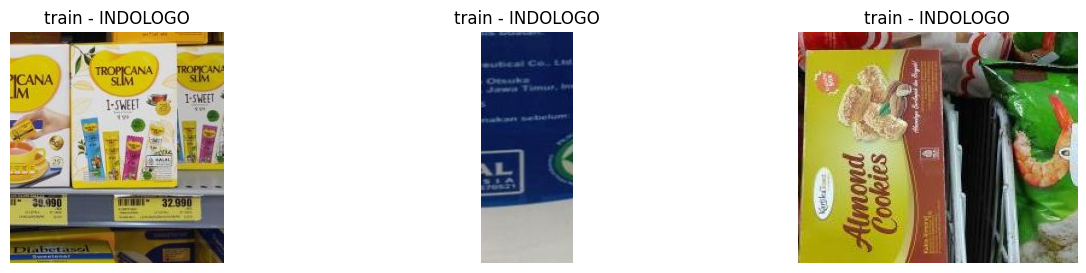

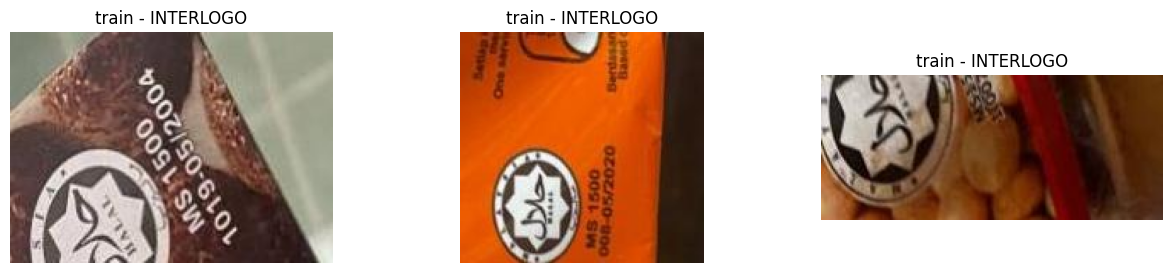

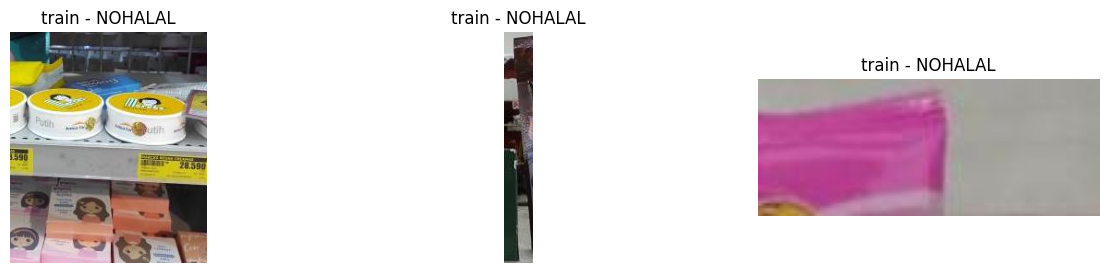

In [9]:
# ========================================
# CELL 2b: Visualisasi Beberapa Contoh
# ========================================

import random

def show_sample_images(split_name, class_name, num_images=5):
    folder = os.path.join(CLASSIFICATION_DATASET_DIR, split_name, class_name)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = random.sample(files, min(num_images, len(files)))

    plt.figure(figsize=(15, 3))
    for i, f in enumerate(sample_files):
        img = Image.open(os.path.join(folder, f))
        plt.subplot(1, len(sample_files), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{split_name} - {class_name}")
    plt.show()

for cls in class_names.values():
    show_sample_images('train', cls, num_images=3)

# CELL 3: Data Preprocessing & Augmentation

> Di sini kita buat dua ImageDataGenerator:

datagen_simple (tanpa augmentasi) – untuk CNN Klasik
datagen_aug (dengan augmentasi) – untuk CNN Augmentasi

In [10]:
# ========================================
# CELL 3: Data Preprocessing & Augmentation
# ========================================

# 1. Generator tanpa augmentasi (CNN Klasik)
datagen_simple_train = ImageDataGenerator(
    rescale=1./255
)

datagen_simple_val = ImageDataGenerator(
    rescale=1./255
)

# 2. Generator dengan augmentasi (CNN + Augmentasi)
datagen_aug_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_aug_val = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory – SIMPLE
train_dir = os.path.join(CLASSIFICATION_DATASET_DIR, 'train')
valid_dir = os.path.join(CLASSIFICATION_DATASET_DIR, 'valid')
test_dir  = os.path.join(CLASSIFICATION_DATASET_DIR, 'test')

train_simple_gen = datagen_simple_train.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

valid_simple_gen = datagen_simple_val.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_simple_gen = datagen_simple_val.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Flow from directory – AUGMENTED
train_aug_gen = datagen_aug_train.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

valid_aug_gen = datagen_aug_val.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

print("\n✅ Data generator (simple & augmented) siap digunakan.")
print("Mapping class indices:", train_simple_gen.class_indices)

Found 886 images belonging to 3 classes.
Found 537 images belonging to 3 classes.
Found 147 images belonging to 3 classes.
Found 886 images belonging to 3 classes.
Found 537 images belonging to 3 classes.

✅ Data generator (simple & augmented) siap digunakan.
Mapping class indices: {'INDOLOGO': 0, 'INTERLOGO': 1, 'NOHALAL': 2}


# CELL 4: Build CNN Model (Simple Architecture)

> Kita buat satu fungsi build_cnn_model() yang akan dipakai baik untuk eksperimen Klasik maupun Augmentasi, supaya arsitekturnya sama (perbedaan hanya pada augmentasi).

In [11]:
# ========================================
# CELL 4: Build CNN Model (Simple Architecture)
# ========================================

num_classes = len(class_names)

def build_cnn_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential(name="Simple_CNN")

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully Connected
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    return model

# Cek summary model
model_test = build_cnn_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)
model_test.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,529,059 (32.54 MB)

 Trainable params: 8,529,059 (32.54 MB)

 Non-trainable params: 0 (0.00 B)

# CELL 5: Train Model

## 5A. CNN Klasik (tanpa augmentasi)

In [12]:
# ========================================
# CELL 5A: Train Model - CNN Klasik (Tanpa Augmentasi)
# ========================================

EPOCHS = 25

cnn_classic_model = build_cnn_model(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes
)

checkpoint_path_classic = os.path.join(CNN_CLASSIC_DIR, 'models', 'cnn_classic_best.h5')
log_path_classic = os.path.join(CNN_CLASSIC_DIR, 'history', 'cnn_classic_history.npy')

cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cb_checkpoint = callbacks.ModelCheckpoint(
    checkpoint_path_classic,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_classic = cnn_classic_model.fit(
    train_simple_gen,
    epochs=EPOCHS,
    validation_data=valid_simple_gen,
    callbacks=[cb_earlystop, cb_checkpoint]
)

# Simpan history
np.save(log_path_classic, history_classic.history)
print(f"\n💾 History CNN Klasik disimpan di: {log_path_classic}")
print(f"💾 Model terbaik CNN Klasik disimpan di: {checkpoint_path_classic}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4983 - loss: 1.4554
Epoch 1: val_loss improved from inf to 0.98408, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.4997 - loss: 1.4446 - val_accuracy: 0.5847 - val_loss: 0.9841
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6000 - loss: 0.9325
Epoch 2: val_loss did not improve from 0.98408
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.5992 - loss: 0.9333 - val_accuracy: 0.5847 - val_loss: 1.0120
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5614 - loss: 0.9661
Epoch 3: val_loss improved from 0.98408 to 0.92544, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.5620 - loss: 0.9653 - val_accuracy: 0.5847 - val_loss: 0.9254
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5665 - loss: 0.9174
Epoch 4: val_loss did not improve from 0.92544
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.5670 - loss: 0.9169 - val_accuracy: 0.6015 - val_loss: 0.9513
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6419 - loss: 0.8624
Epoch 5: val_loss improved from 0.92544 to 0.78432, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.6417 - loss: 0.8615 - val_accuracy: 0.6760 - val_loss: 0.7843
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6672 - loss: 0.7629
Epoch 6: val_loss improved from 0.78432 to 0.74294, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.6673 - loss: 0.7633 - val_accuracy: 0.6909 - val_loss: 0.7429
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6929 - loss: 0.7180
Epoch 7: val_loss improved from 0.74294 to 0.70861, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.6938 - loss: 0.7176 - val_accuracy: 0.6927 - val_loss: 0.7086
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6896 - loss: 0.6836
Epoch 8: val_loss did not improve from 0.70861
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.6899 - loss: 0.6842 - val_accuracy: 0.6425 - val_loss: 0.7636
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7100 - loss: 0.6578
Epoch 9: val_loss improved from 0.70861 to 0.63308, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.7111 - loss: 0.6566 - val_accuracy: 0.7374 - val_loss: 0.6331
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7251 - loss: 0.6139
Epoch 10: val_loss improved from 0.63308 to 0.61806, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7264 - loss: 0.6117 - val_accuracy: 0.7337 - val_loss: 0.6181
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7717 - loss: 0.5301
Epoch 11: val_loss improved from 0.61806 to 0.59059, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7718 - loss: 0.5298 - val_accuracy: 0.7728 - val_loss: 0.5906
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8343 - loss: 0.4301
Epoch 12: val_loss improved from 0.59059 to 0.55021, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.8340 - loss: 0.4307 - val_accuracy: 0.7765 - val_loss: 0.5502
Epoch 13/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8472 - loss: 0.4040
Epoch 13: val_loss did not improve from 0.55021
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8468 - loss: 0.4041 - val_accuracy: 0.7840 - val_loss: 0.5881
Epoch 14/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8609 - loss: 0.3713
Epoch 14: val_loss did not improve from 0.55021
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.8604 - loss: 0.3718 - val_accuracy: 0.7598 - val_loss: 0.6895
Epoch 15/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8601 - loss: 0.3492
Epoch 15: val_loss did not improve from 0.55021
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8604 - loss: 0.3486 - val_accuracy: 0.8305 - val_loss: 0.5525
Epoch 16/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8985 - loss: 0.2744
Epoch 16: val_loss improved from 0.55021

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.8985 - loss: 0.2740 - val_accuracy: 0.8696 - val_loss: 0.4772
Epoch 17/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9072 - loss: 0.2412
Epoch 17: val_loss improved from 0.47718 to 0.46714, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9067 - loss: 0.2425 - val_accuracy: 0.8566 - val_loss: 0.4671
Epoch 18/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9289 - loss: 0.2061
Epoch 18: val_loss improved from 0.46714 to 0.45992, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.9288 - loss: 0.2058 - val_accuracy: 0.8864 - val_loss: 0.4599
Epoch 19/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9459 - loss: 0.1549
Epoch 19: val_loss did not improve from 0.45992
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9461 - loss: 0.1547 - val_accuracy: 0.8790 - val_loss: 0.4604
Epoch 20/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9516 - loss: 0.1316
Epoch 20: val_loss did not improve from 0.45992
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - accuracy: 0.9516 - loss: 0.1317 - val_accuracy: 0.8920 - val_loss: 0.4948
Epoch 21/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9466 - loss: 0.1512
Epoch 21: val_loss did not improve from 0.45992
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9470 - loss: 0.1508 - val_accuracy: 0.8883 - val_loss: 0.5150
Epoch 22/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9715 - loss: 0.0928
Epoch 22: val_loss improved from 0.45992

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.9712 - loss: 0.0935 - val_accuracy: 0.8976 - val_loss: 0.4564
Epoch 23/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9690 - loss: 0.0873
Epoch 23: val_loss did not improve from 0.45644
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9690 - loss: 0.0872 - val_accuracy: 0.8864 - val_loss: 0.5499
Epoch 24/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9520 - loss: 0.1197
Epoch 24: val_loss did not improve from 0.45644
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9522 - loss: 0.1189 - val_accuracy: 0.8976 - val_loss: 0.4920
Epoch 25/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9536 - loss: 0.1170
Epoch 25: val_loss did not improve from 0.45644
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.9539 - loss: 0.1163 - val_accuracy: 0.8901 - val_loss: 0.5519

💾 History CNN Klasik disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/histor

## 5B. CNN dengan Augmentasi

In [ ]:
# ========================================
# CELL 5B: Train Model - CNN dengan Augmentasi
# ========================================

cnn_aug_model = build_cnn_model(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes
)

checkpoint_path_aug = os.path.join(CNN_AUG_DIR, 'models', 'cnn_aug_best.h5')
log_path_aug = os.path.join(CNN_AUG_DIR, 'history', 'cnn_aug_history.npy')

cb_earlystop_aug = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cb_checkpoint_aug = callbacks.ModelCheckpoint(
    checkpoint_path_aug,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_aug = cnn_aug_model.fit(
    train_aug_gen,
    epochs=EPOCHS,
    validation_data=valid_aug_gen,
    callbacks=[cb_earlystop_aug, cb_checkpoint_aug]
)

# Simpan history
np.save(log_path_aug, history_aug.history)
print(f"\n💾 History CNN Augmentasi disimpan di: {log_path_aug}")
print(f"💾 Model terbaik CNN Augmentasi disimpan di: {checkpoint_path_aug}")

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.5289 - loss: 1.0331
Epoch 1: val_loss improved from inf to 0.99596, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 888ms/step - accuracy: 0.5298 - loss: 1.0326 - val_accuracy: 0.5823 - val_loss: 0.9960
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5730 - loss: 0.9758
Epoch 2: val_loss improved from 0.99596 to 0.93468, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.5732 - loss: 0.9753 - val_accuracy: 0.5823 - val_loss: 0.9347
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5786 - loss: 0.9584
Epoch 3: val_loss improved from 0.93468 to 0.90913, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5786 - loss: 0.9583 - val_accuracy: 0.5823 - val_loss: 0.9091
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5892 - loss: 0.9138
Epoch 4: val_loss improved from 0.90913 to 0.86737, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.5895 - loss: 0.9139 - val_accuracy: 0.6405 - val_loss: 0.8674
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6066 - loss: 0.9021
Epoch 5: val_loss improved from 0.86737 to 0.85189, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.6066 - loss: 0.9021 - val_accuracy: 0.6253 - val_loss: 0.8519
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6305 - loss: 0.8721
Epoch 6: val_loss improved from 0.85189 to 0.83256, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.6306 - loss: 0.8713 - val_accuracy: 0.6532 - val_loss: 0.8326
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6176 - loss: 0.8052
Epoch 7: val_loss improved from 0.83256 to 0.82478, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 0.6172 - loss: 0.8063 - val_accuracy: 0.6582 - val_loss: 0.8248
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6383 - loss: 0.8322
Epoch 8: val_loss improved from 0.82478 to 0.74363, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.6388 - loss: 0.8309 - val_accuracy: 0.6835 - val_loss: 0.7436
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6453 - loss: 0.7560
Epoch 9: val_loss improved from 0.74363 to 0.72270, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.6460 - loss: 0.7561 - val_accuracy: 0.6785 - val_loss: 0.7227
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6877 - loss: 0.7598
Epoch 10: val_loss did not improve from 0.72270
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - accuracy: 0.6870 - loss: 0.7596 - val_accuracy: 0.6532 - val_loss: 0.7451
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6473 - loss: 0.7504
Epoch 11: val_loss improved from 0.72270 to 0.70407, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.6475 - loss: 0.7507 - val_accuracy: 0.6937 - val_loss: 0.7041
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6994 - loss: 0.7087
Epoch 12: val_loss did not improve from 0.70407
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.6988 - loss: 0.7095 - val_accuracy: 0.6911 - val_loss: 0.7163
Epoch 13/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6722 - loss: 0.7450
Epoch 13: val_loss improved from 0.70407 to 0.67556, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 488ms/step - accuracy: 0.6725 - loss: 0.7441 - val_accuracy: 0.7215 - val_loss: 0.6756
Epoch 14/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6864 - loss: 0.7171
Epoch 14: val_loss improved from 0.67556 to 0.66094, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.6866 - loss: 0.7170 - val_accuracy: 0.7266 - val_loss: 0.6609
Epoch 15/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6840 - loss: 0.7101
Epoch 15: val_loss did not improve from 0.66094
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.6842 - loss: 0.7100 - val_accuracy: 0.6658 - val_loss: 0.7298
Epoch 16/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6789 - loss: 0.7258
Epoch 16: val_loss did not improve from 0.66094
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.6794 - loss: 0.7255 - val_accuracy: 0.7038 - val_loss: 0.6630
Epoch 17/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7177 - loss: 0.6853
Epoch 17: val_loss did not improve from 0.66094
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.7173 - loss: 0.6856 - val_accuracy: 0.6861 - val_loss: 0.6913
Epoch 18/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7190 - loss: 0.6987
Epoch 18: val_loss improved from 0.660

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.7181 - loss: 0.6992 - val_accuracy: 0.7038 - val_loss: 0.6553
Epoch 19/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6934 - loss: 0.6807
Epoch 19: val_loss improved from 0.65532 to 0.64785, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.6925 - loss: 0.6816 - val_accuracy: 0.7165 - val_loss: 0.6478
Epoch 20/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7073 - loss: 0.6648
Epoch 20: val_loss improved from 0.64785 to 0.58900, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - accuracy: 0.7080 - loss: 0.6640 - val_accuracy: 0.7494 - val_loss: 0.5890
Epoch 21/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7364 - loss: 0.6023
Epoch 21: val_loss did not improve from 0.58900
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.7358 - loss: 0.6033 - val_accuracy: 0.7114 - val_loss: 0.6433
Epoch 22/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7495 - loss: 0.6301
Epoch 22: val_loss improved from 0.58900 to 0.58029, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - accuracy: 0.7493 - loss: 0.6297 - val_accuracy: 0.7570 - val_loss: 0.5803
Epoch 23/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7812 - loss: 0.5714
Epoch 23: val_loss improved from 0.58029 to 0.56867, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.7804 - loss: 0.5729 - val_accuracy: 0.7443 - val_loss: 0.5687
Epoch 24/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7320 - loss: 0.6044
Epoch 24: val_loss did not improve from 0.56867
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.7320 - loss: 0.6044 - val_accuracy: 0.7595 - val_loss: 0.5818
Epoch 25/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7550 - loss: 0.5828
Epoch 25: val_loss improved from 0.56867 to 0.56701, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - accuracy: 0.7549 - loss: 0.5833 - val_accuracy: 0.7646 - val_loss: 0.5670

💾 History CNN Augmentasi disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/history/cnn_aug_history.npy
💾 Model terbaik CNN Augmentasi disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


# CELL 6: Evaluate & Visualize Results

> Plot training vs validation loss/accuracy
Evaluasi pada test set
Confusion matrix & classification report

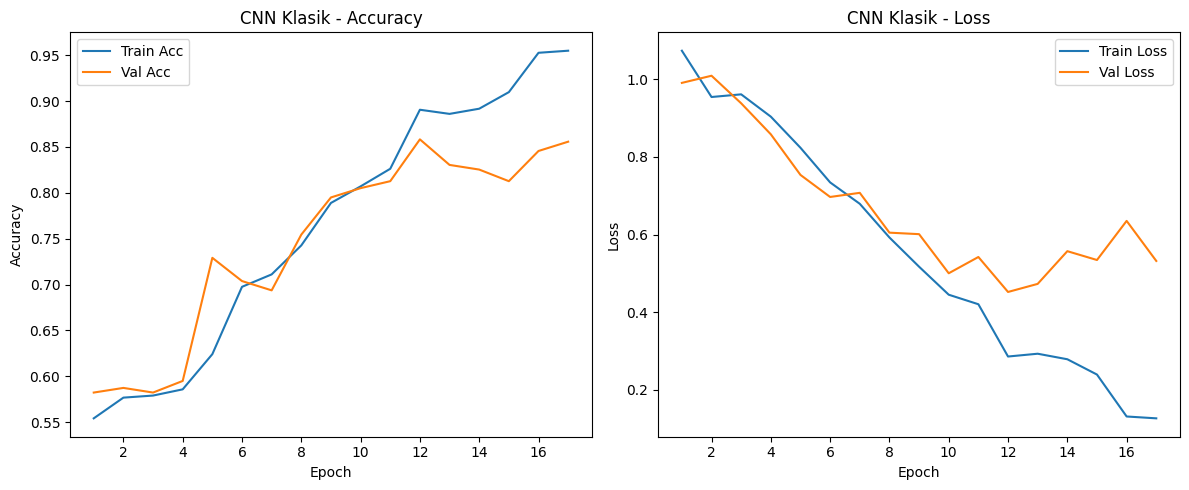

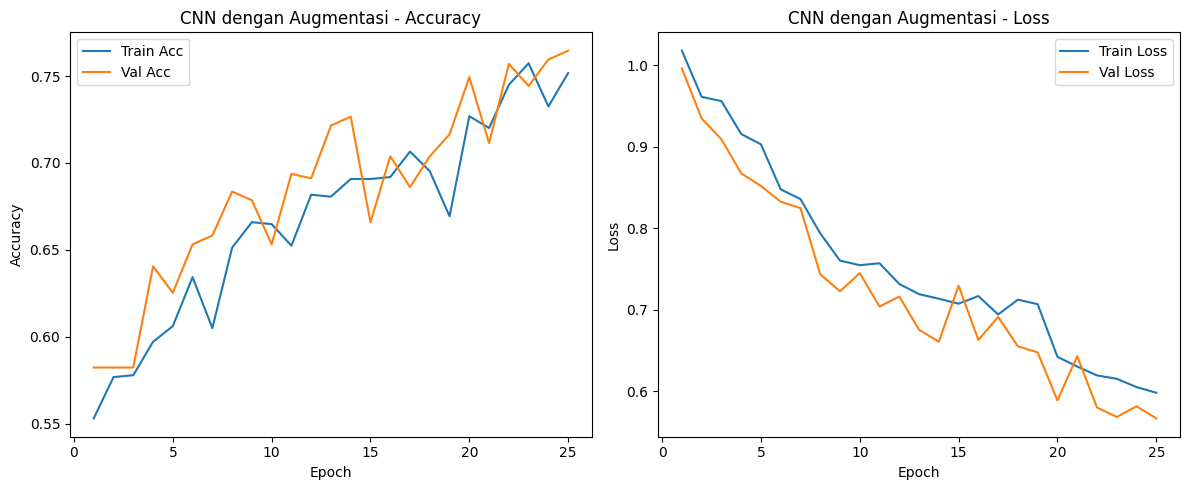


🔍 Evaluasi CNN Klasik di test set


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.7722 - loss: 0.8734
   Test Loss: 1.1378 | Test Acc: 0.7347

🔍 Evaluasi CNN Augmentasi di test set
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.7013 - loss: 0.5878
   Test Loss: 0.6785 | Test Acc: 0.6599
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step

Classification Report - CNN Klasik
              precision    recall  f1-score   support

    INDOLOGO     0.7745    0.8404    0.8061        94
   INTERLOGO     0.6875    0.6471    0.6667        17
     NOHALAL     0.6207    0.5000    0.5538        36

    accuracy                         0.7347       147
   macro avg     0.6942    0.6625    0.6755       147
weighted avg     0.7268    0.7347    0.7282       147



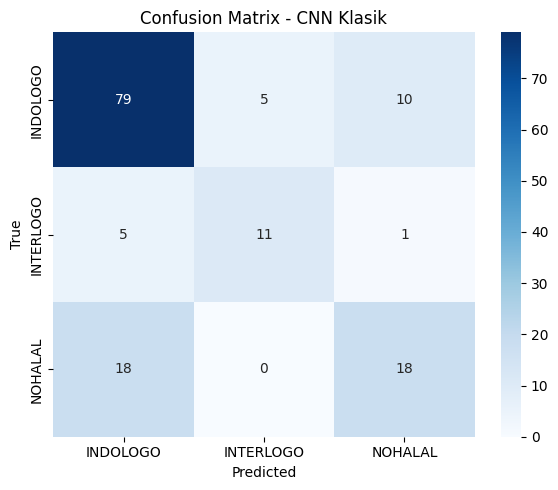

💾 Confusion Matrix disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/plots/CNN_Klasik_cm.png
💾 Classification Report disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/history/CNN_Klasik_report.txt
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

Classification Report - CNN Augmentasi
              precision    recall  f1-score   support

    INDOLOGO     0.7300    0.7766    0.7526        94
   INTERLOGO     0.5000    0.2941    0.3704        17
     NOHALAL     0.5135    0.5278    0.5205        36

    accuracy                         0.6599       147
   macro avg     0.5812    0.5328    0.5478       147
weighted avg     0.6504    0.6599    0.6516       147



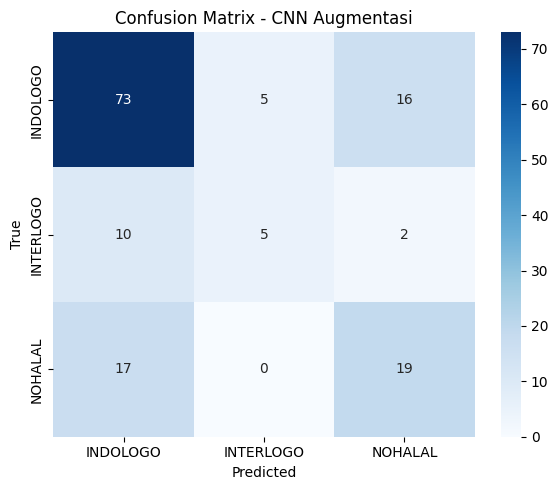

💾 Confusion Matrix disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/plots/CNN_Augmentasi_cm.png
💾 Classification Report disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/history/CNN_Augmentasi_report.txt


In [ ]:
# ========================================
# CELL 6: Evaluate & Visualize Results
# ========================================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_training_history(history_dict, title, save_path=None):
    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
    plt.show()

# 1. Load history dari file
history_classic_dict = np.load(
    os.path.join(CNN_CLASSIC_DIR, 'history', 'cnn_classic_history.npy'),
    allow_pickle=True
).item()

history_aug_dict = np.load(
    os.path.join(CNN_AUG_DIR, 'history', 'cnn_aug_history.npy'),
    allow_pickle=True
).item()

# 2. Plot
plot_training_history(
    history_classic_dict,
    title="CNN Klasik",
    save_path=os.path.join(CNN_CLASSIC_DIR, 'plots', 'cnn_classic_training.png')
)

plot_training_history(
    history_aug_dict,
    title="CNN dengan Augmentasi",
    save_path=os.path.join(CNN_AUG_DIR, 'plots', 'cnn_aug_training.png')
)

# 3. Evaluasi di test set
print("\n🔍 Evaluasi CNN Klasik di test set")
cnn_classic_model.load_weights(checkpoint_path_classic)
test_loss_c, test_acc_c = cnn_classic_model.evaluate(test_simple_gen, verbose=1)
print(f"   Test Loss: {test_loss_c:.4f} | Test Acc: {test_acc_c:.4f}")

print("\n🔍 Evaluasi CNN Augmentasi di test set")
cnn_aug_model.load_weights(checkpoint_path_aug)
test_loss_a, test_acc_a = cnn_aug_model.evaluate(test_simple_gen, verbose=1)
print(f"   Test Loss: {test_loss_a:.4f} | Test Acc: {test_acc_a:.4f}")

# 4. Confusion Matrix & Classification Report
def evaluate_model_on_test(model, generator, class_indices, title, save_prefix_dir):
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    labels = list(class_indices.keys())  # ex: ['INDOLOGO','INTERLOGO','NOHALAL']

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=labels, digits=4)

    print(f"\nClassification Report - {title}")
    print(cr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    cm_path = os.path.join(save_prefix_dir, 'plots', f'{title.replace(" ", "_")}_cm.png')
    plt.tight_layout()
    plt.savefig(cm_path, dpi=150)
    plt.show()

    # Simpan classification report sebagai txt
    cr_path = os.path.join(save_prefix_dir, 'history', f'{title.replace(" ", "_")}_report.txt')
    with open(cr_path, 'w') as f:
        f.write(cr)
    print(f"💾 Confusion Matrix disimpan di: {cm_path}")
    print(f"💾 Classification Report disimpan di: {cr_path}")

# CNN Klasik
evaluate_model_on_test(
    cnn_classic_model,
    test_simple_gen,
    train_simple_gen.class_indices,
    title='CNN Klasik',
    save_prefix_dir=CNN_CLASSIC_DIR
)

# CNN Augmentasi
evaluate_model_on_test(
    cnn_aug_model,
    test_simple_gen,
    train_simple_gen.class_indices,
    title='CNN Augmentasi',
    save_prefix_dir=CNN_AUG_DIR
)

📊 Membuat perbandingan akurasi...


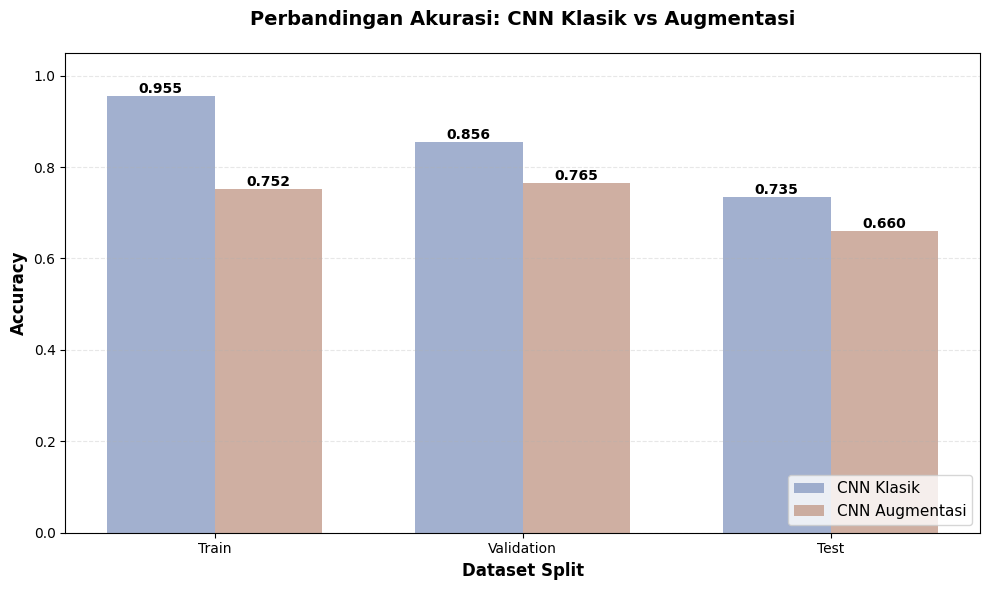

✅ Saved: comparison_accuracy.png

📊 Membuat pie chart distribusi prediksi...


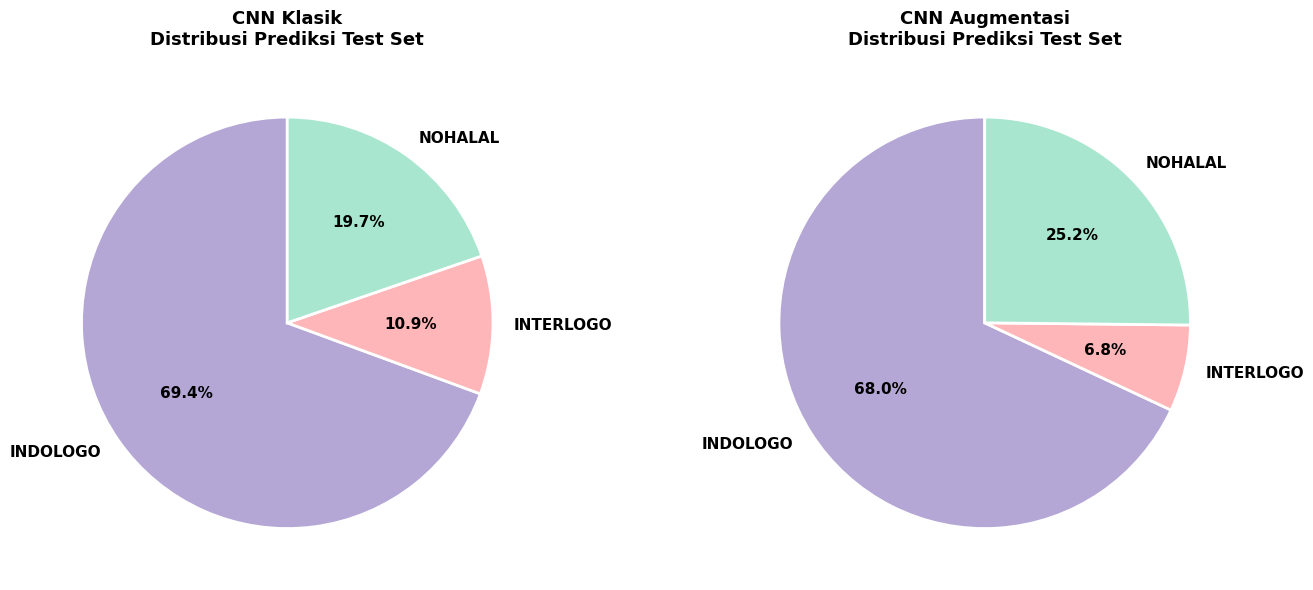

✅ Saved: comparison_prediction_distribution.png

📊 Membuat perbandingan metrik per kelas...


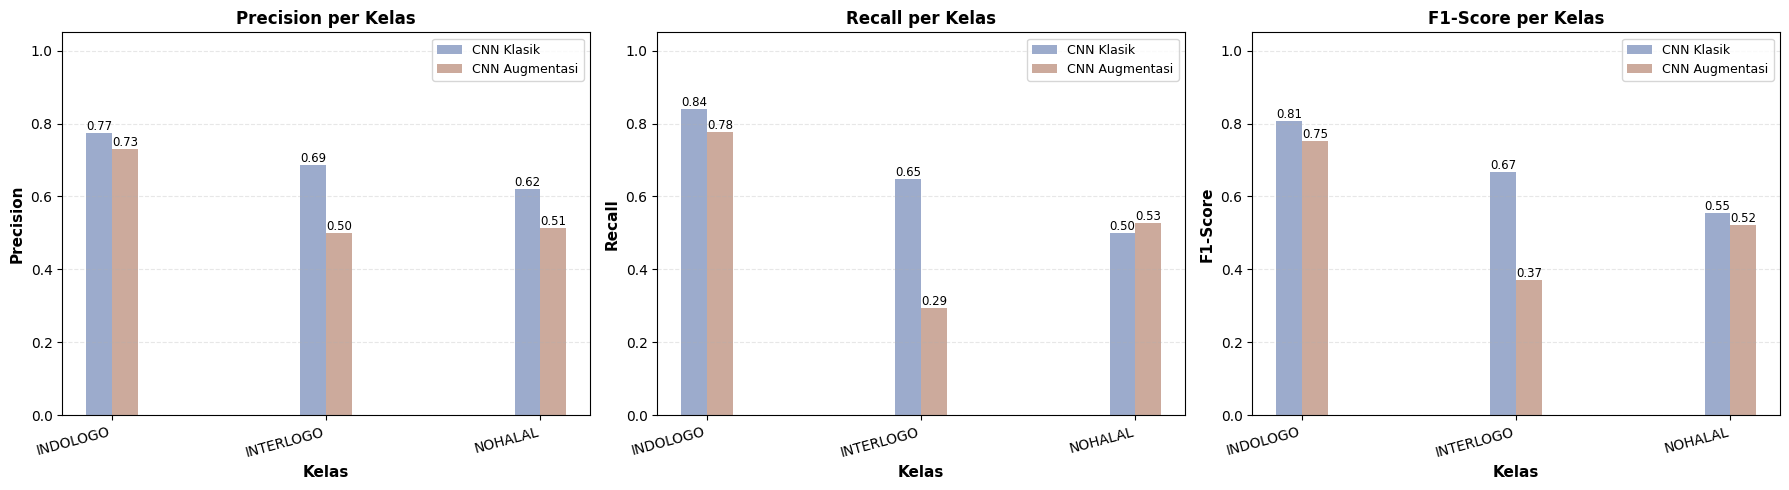

✅ Saved: comparison_metrics_per_class.png

📊 Membuat side-by-side confusion matrix...


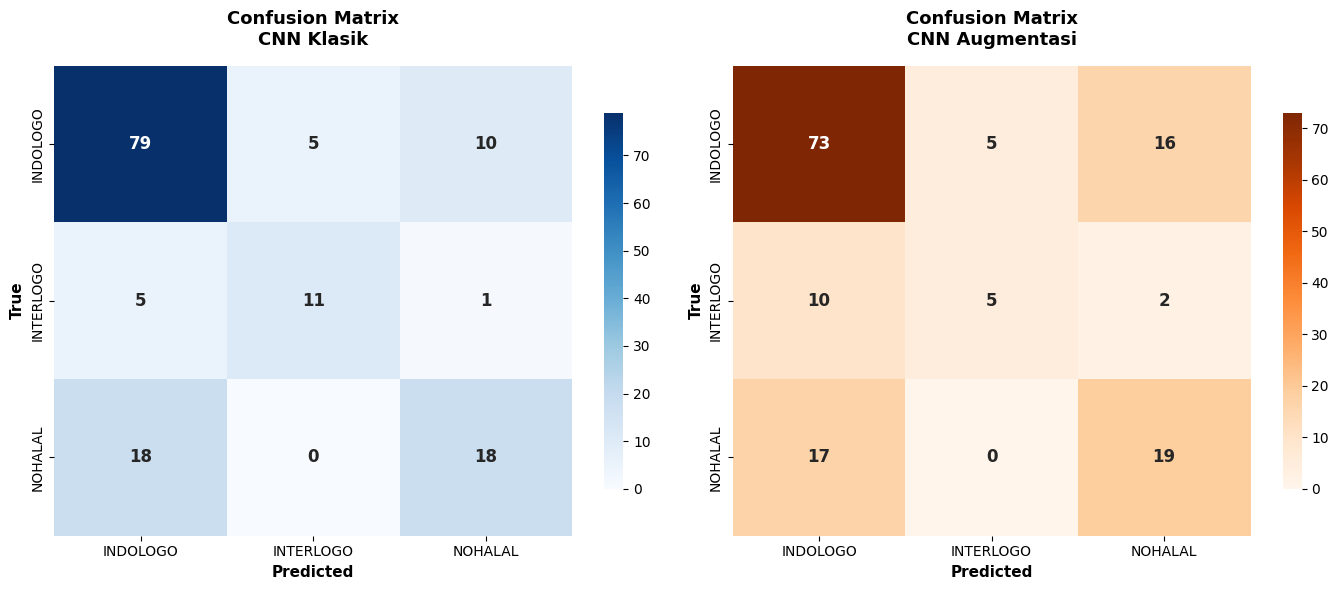

✅ Saved: comparison_confusion_matrix.png

📊 Membuat learning curves comparison...


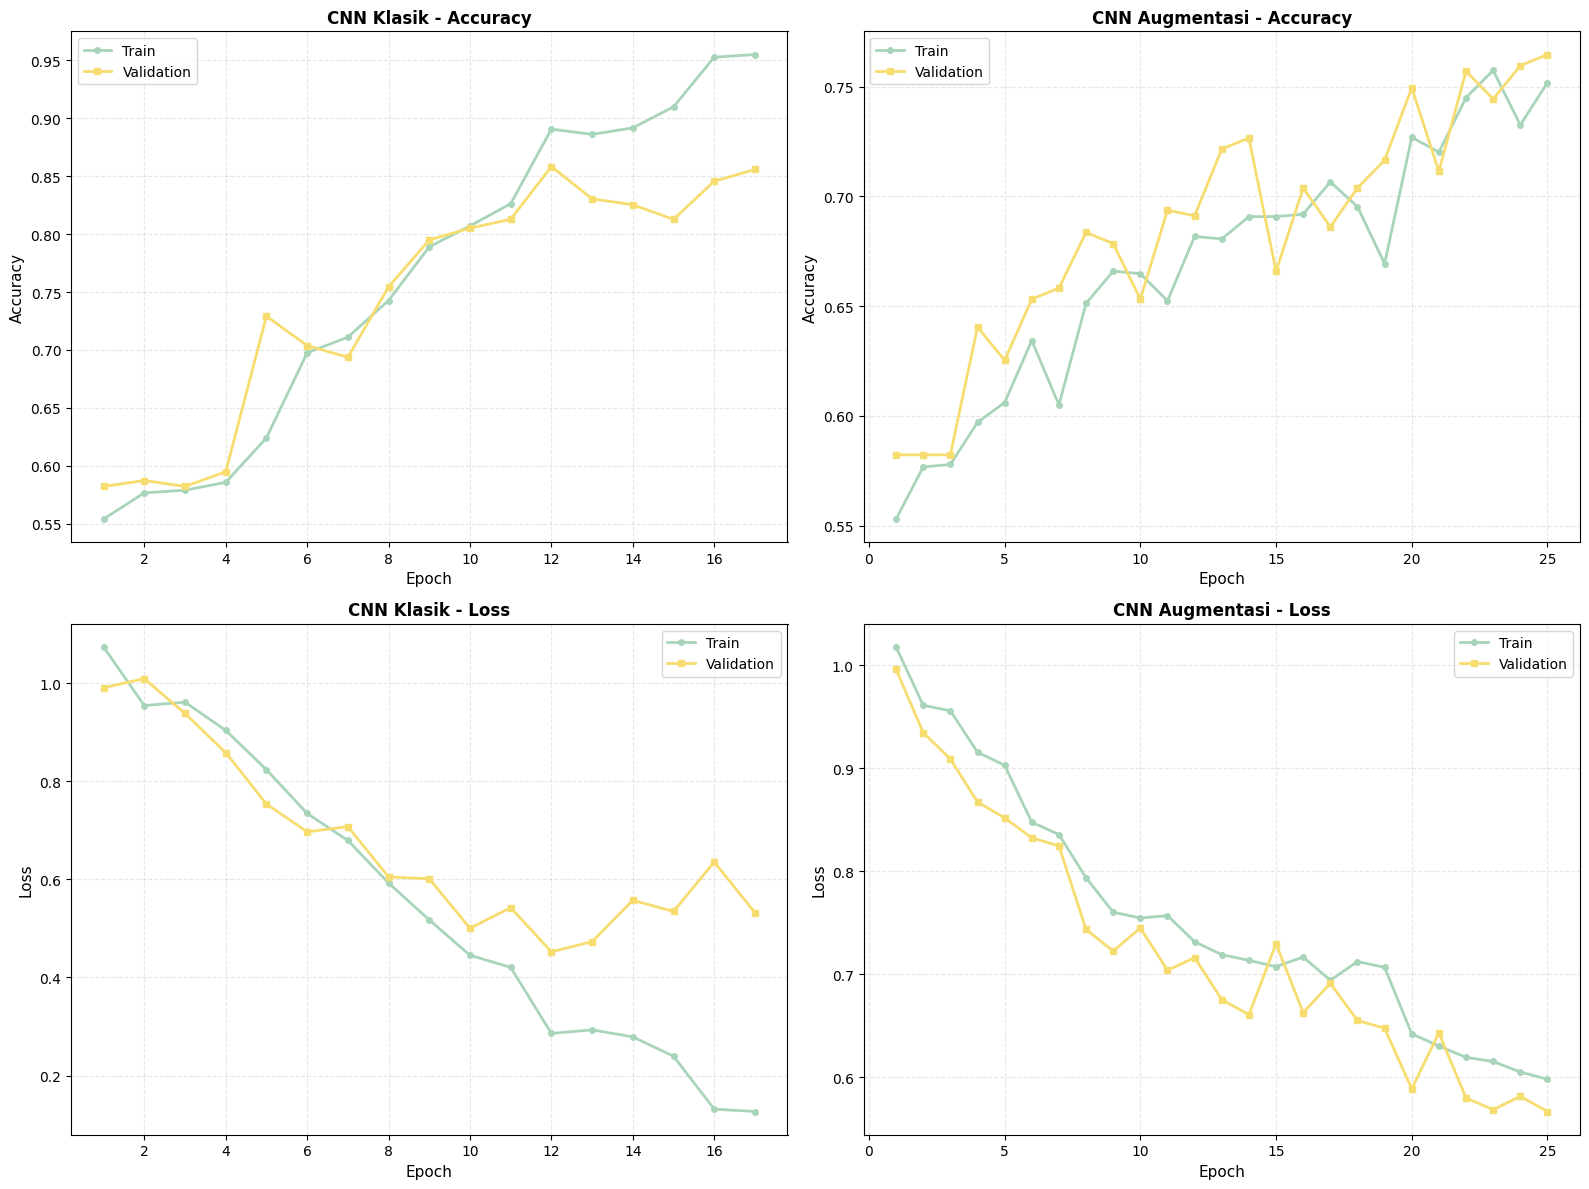

✅ Saved: comparison_learning_curves.png

📊 Membuat tabel ringkasan perbandingan...


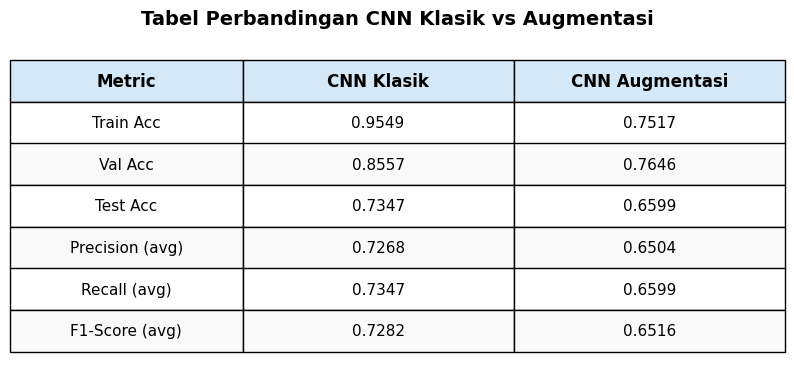

✅ Saved: comparison_summary_table.png

✅ Semua visualisasi perbandingan berhasil dibuat!
📁 Lokasi: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning


In [ ]:
# ========================================
# CELL 6b: Perbandingan Visual CNN Klasik vs Augmentasi
# ========================================

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Soft color palette
SOFT_COLORS = {
    'classic': '#8B9DC3',      # Soft blue
    'augmented': '#C39B8B',    # Soft terracotta
    'train': '#A8D5BA',        # Soft mint
    'val': '#F7DC6F',          # Soft yellow
    'test': '#E8A19C'          # Soft coral
}

CLASS_COLORS = ['#B4A7D6', '#FFB6B9', '#A8E6CF']  # Soft purple, pink, mint

# ==========================================
# 1. BAR CHART: Perbandingan Akurasi
# ==========================================
print("📊 Membuat perbandingan akurasi...")

# Load history
history_classic = np.load(
    os.path.join(CNN_CLASSIC_DIR, 'history', 'cnn_classic_history.npy'),
    allow_pickle=True
).item()

history_aug = np.load(
    os.path.join(CNN_AUG_DIR, 'history', 'cnn_aug_history.npy'),
    allow_pickle=True
).item()

# Get final train & val accuracy
classic_train_acc = history_classic['accuracy'][-1]
classic_val_acc = history_classic['val_accuracy'][-1]

aug_train_acc = history_aug['accuracy'][-1]
aug_val_acc = history_aug['val_accuracy'][-1]

# Load models dan evaluate test
cnn_classic_model.load_weights(
    os.path.join(CNN_CLASSIC_DIR, 'models', 'cnn_classic_best.h5')
)
cnn_aug_model.load_weights(
    os.path.join(CNN_AUG_DIR, 'models', 'cnn_aug_best.h5')
)

_, classic_test_acc = cnn_classic_model.evaluate(test_simple_gen, verbose=0)
_, aug_test_acc = cnn_aug_model.evaluate(test_simple_gen, verbose=0)

# Create comparison bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(3)
width = 0.35

classic_scores = [classic_train_acc, classic_val_acc, classic_test_acc]
aug_scores = [aug_train_acc, aug_val_acc, aug_test_acc]

bars1 = ax.bar(x - width/2, classic_scores, width,
               label='CNN Klasik', color=SOFT_COLORS['classic'], alpha=0.8)
bars2 = ax.bar(x + width/2, aug_scores, width,
               label='CNN Augmentasi', color=SOFT_COLORS['augmented'], alpha=0.8)

ax.set_xlabel('Dataset Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Akurasi: CNN Klasik vs Augmentasi',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Train', 'Validation', 'Test'])
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_accuracy.png")

# ==========================================
# 2. PIE CHARTS: Distribusi Prediksi per Kelas
# ==========================================
print("\n📊 Membuat pie chart distribusi prediksi...")

# Get predictions
test_simple_gen.reset()
y_true = test_simple_gen.classes
y_pred_classic = np.argmax(cnn_classic_model.predict(test_simple_gen, verbose=0), axis=1)
y_pred_aug = np.argmax(cnn_aug_model.predict(test_simple_gen, verbose=0), axis=1)

labels = list(train_simple_gen.class_indices.keys())

# Count predictions
classic_counts = [np.sum(y_pred_classic == i) for i in range(len(labels))]
aug_counts = [np.sum(y_pred_aug == i) for i in range(len(labels))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# CNN Klasik
wedges1, texts1, autotexts1 = ax1.pie(classic_counts, labels=labels, autopct='%1.1f%%',
                                        colors=CLASS_COLORS, startangle=90,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'},
                                        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax1.set_title('CNN Klasik\nDistribusi Prediksi Test Set',
              fontsize=13, fontweight='bold', pad=15)

# CNN Augmentasi
wedges2, texts2, autotexts2 = ax2.pie(aug_counts, labels=labels, autopct='%1.1f%%',
                                        colors=CLASS_COLORS, startangle=90,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'},
                                        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax2.set_title('CNN Augmentasi\nDistribusi Prediksi Test Set',
              fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_prediction_distribution.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_prediction_distribution.png")

# ==========================================
# 3. BAR CHART: Precision, Recall, F1 per Kelas
# ==========================================
print("\n📊 Membuat perbandingan metrik per kelas...")

# Calculate metrics
precision_c, recall_c, f1_c, _ = precision_recall_fscore_support(y_true, y_pred_classic, average=None)
precision_a, recall_a, f1_a, _ = precision_recall_fscore_support(y_true, y_pred_aug, average=None)

x = np.arange(len(labels))
width = 0.12

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = [
    ('Precision', precision_c, precision_a),
    ('Recall', recall_c, recall_a),
    ('F1-Score', f1_c, f1_a)
]

for idx, (metric_name, classic_vals, aug_vals) in enumerate(metrics):
    ax = axes[idx]

    bars1 = ax.bar(x - width/2, classic_vals, width,
                   label='CNN Klasik', color=SOFT_COLORS['classic'], alpha=0.85)
    bars2 = ax.bar(x + width/2, aug_vals, width,
                   label='CNN Augmentasi', color=SOFT_COLORS['augmented'], alpha=0.85)

    ax.set_xlabel('Kelas', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} per Kelas', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, ha='right')
    ax.legend(fontsize=9)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=8.5)

plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_metrics_per_class.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_metrics_per_class.png")

# ==========================================
# 4. SIDE-BY-SIDE CONFUSION MATRIX (Soft Colors)
# ==========================================
print("\n📊 Membuat side-by-side confusion matrix...")

from sklearn.metrics import confusion_matrix

cm_classic = confusion_matrix(y_true, y_pred_classic)
cm_aug = confusion_matrix(y_true, y_pred_aug)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# CNN Klasik
sns.heatmap(cm_classic, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=ax1,
            cbar_kws={'shrink': 0.8}, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Confusion Matrix\nCNN Klasik', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_ylabel('True', fontsize=11, fontweight='bold')

# CNN Augmentasi
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels, ax=ax2,
            cbar_kws={'shrink': 0.8}, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Confusion Matrix\nCNN Augmentasi', fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('True', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_confusion_matrix.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_confusion_matrix.png")

# ==========================================
# 5. LEARNING CURVES COMPARISON
# ==========================================
print("\n📊 Membuat learning curves comparison...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_c = range(1, len(history_classic['accuracy']) + 1)
epochs_a = range(1, len(history_aug['accuracy']) + 1)

# Accuracy - CNN Klasik
axes[0, 0].plot(epochs_c, history_classic['accuracy'],
                color=SOFT_COLORS['train'], linewidth=2, label='Train', marker='o', markersize=4)
axes[0, 0].plot(epochs_c, history_classic['val_accuracy'],
                color=SOFT_COLORS['val'], linewidth=2, label='Validation', marker='s', markersize=4)
axes[0, 0].set_title('CNN Klasik - Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Loss - CNN Klasik
axes[1, 0].plot(epochs_c, history_classic['loss'],
                color=SOFT_COLORS['train'], linewidth=2, label='Train', marker='o', markersize=4)
axes[1, 0].plot(epochs_c, history_classic['val_loss'],
                color=SOFT_COLORS['val'], linewidth=2, label='Validation', marker='s', markersize=4)
axes[1, 0].set_title('CNN Klasik - Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Loss', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Accuracy - CNN Augmentasi
axes[0, 1].plot(epochs_a, history_aug['accuracy'],
                color=SOFT_COLORS['train'], linewidth=2, label='Train', marker='o', markersize=4)
axes[0, 1].plot(epochs_a, history_aug['val_accuracy'],
                color=SOFT_COLORS['val'], linewidth=2, label='Validation', marker='s', markersize=4)
axes[0, 1].set_title('CNN Augmentasi - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, linestyle='--')

# Loss - CNN Augmentasi
axes[1, 1].plot(epochs_a, history_aug['loss'],
                color=SOFT_COLORS['train'], linewidth=2, label='Train', marker='o', markersize=4)
axes[1, 1].plot(epochs_a, history_aug['val_loss'],
                color=SOFT_COLORS['val'], linewidth=2, label='Validation', marker='s', markersize=4)
axes[1, 1].set_title('CNN Augmentasi - Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_learning_curves.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_learning_curves.png")

# ==========================================
# 6. SUMMARY TABLE
# ==========================================
print("\n📊 Membuat tabel ringkasan perbandingan...")

# Calculate average metrics
precision_c_avg, recall_c_avg, f1_c_avg, _ = precision_recall_fscore_support(
    y_true, y_pred_classic, average='weighted'
)
precision_a_avg, recall_a_avg, f1_a_avg, _ = precision_recall_fscore_support(
    y_true, y_pred_aug, average='weighted'
)

summary_data = {
    'Metric': ['Train Acc', 'Val Acc', 'Test Acc', 'Precision (avg)', 'Recall (avg)', 'F1-Score (avg)'],
    'CNN Klasik': [
        f'{classic_train_acc:.4f}',
        f'{classic_val_acc:.4f}',
        f'{classic_test_acc:.4f}',
        f'{precision_c_avg:.4f}',
        f'{recall_c_avg:.4f}',
        f'{f1_c_avg:.4f}'
    ],
    'CNN Augmentasi': [
        f'{aug_train_acc:.4f}',
        f'{aug_val_acc:.4f}',
        f'{aug_test_acc:.4f}',
        f'{precision_a_avg:.4f}',
        f'{recall_a_avg:.4f}',
        f'{f1_a_avg:.4f}'
    ]
}

import pandas as pd
df_summary = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns,
                 cellLoc='center', loc='center',
                 colWidths=[0.3, 0.35, 0.35])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(len(df_summary.columns)):
    table[(0, i)].set_facecolor('#D5E8F7')
    table[(0, i)].set_text_props(weight='bold', fontsize=12)

# Alternate row colors
for i in range(1, len(df_summary) + 1):
    for j in range(len(df_summary.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F9F9F9')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

plt.title('Tabel Perbandingan CNN Klasik vs Augmentasi',
          fontsize=14, fontweight='bold', pad=20)
plt.savefig(os.path.join(DEEP_LEARNING_DIR, 'comparison_summary_table.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: comparison_summary_table.png")

print("\n" + "="*60)
print("✅ Semua visualisasi perbandingan berhasil dibuat!")
print(f"📁 Lokasi: {DEEP_LEARNING_DIR}")
print("="*60)

# CELL 7: Detailed Report & Analysis
> Cell ini fokus ke penjelasan dan analisis (lebih ke text / markdown di notebook). Bisa seperti ini:

In [ ]:
# ========================================
# CELL 7: Detailed Report & Analysis
# ========================================

print("Silakan tambahkan analisis tertulis di cell markdown berikut, contoh poin:\n")
print("""
1. Deskripsi arsitektur CNN Klasik:
   - 3 blok convolution + maxpooling + dropout
   - 1 dense hidden layer (256 neuron) + dropout
   - Output layer softmax 3 kelas: INDOLOGO, INTERLOGO, NOHALAL

2. Perbandingan performa:
   - Test Accuracy CNN Klasik:   {:.4f}
   - Test Accuracy CNN Augmentasi: {:.4f}
   - Analisis apakah augmentasi membantu generalisasi (overfitting vs underfitting).

3. Interpretasi Confusion Matrix:
   - Kelas mana yang paling sering salah prediksi?
   - Apakah ada kelas yang imbalance?

4. Keterbatasan:
   - Crop objek sederhana (tanpa memperhatikan rotasi OBB secara penuh).
   - Resolusi input 128x128 (bisa ditingkatkan jika resource cukup).

5. Saran pengembangan:
   - Coba arsitektur yang lebih dalam / menggunakan transfer learning (ResNet, EfficientNet).
   - Coba tuning hyperparameter (learning rate, batch size, jumlah epoch).
""".format(test_acc_c, test_acc_a))

Silakan tambahkan analisis tertulis di cell markdown berikut, contoh poin:


1. Deskripsi arsitektur CNN Klasik:
   - 3 blok convolution + maxpooling + dropout
   - 1 dense hidden layer (256 neuron) + dropout
   - Output layer softmax 3 kelas: INDOLOGO, INTERLOGO, NOHALAL

2. Perbandingan performa:
   - Test Accuracy CNN Klasik:   0.7347
   - Test Accuracy CNN Augmentasi: 0.6599
   - Analisis apakah augmentasi membantu generalisasi (overfitting vs underfitting).

3. Interpretasi Confusion Matrix:
   - Kelas mana yang paling sering salah prediksi?
   - Apakah ada kelas yang imbalance?

4. Keterbatasan:
   - Crop objek sederhana (tanpa memperhatikan rotasi OBB secara penuh).
   - Resolusi input 128x128 (bisa ditingkatkan jika resource cukup).

5. Saran pengembangan:
   - Coba arsitektur yang lebih dalam / menggunakan transfer learning (ResNet, EfficientNet).
   - Coba tuning hyperparameter (learning rate, batch size, jumlah epoch).



# 2.CNN KLASIK + LoRA & CNN AUG + LoRA

> Perlu diingatkan bahwa sebelum menjalankan program ini, jalankan cell 1 terlebih dahulu.

## 2.Fungsi Utilitas: Build CNN Baseline Sebagai Backbone
> Kalau di kode kamu sudah ada build_cnn_model(...), kita pakai lagi.
Kalau tidak, pastikan fungsi ini ada (bisa di CELL 4 atau cell baru):

In [13]:
def build_cnn_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential(name="Simple_CNN")

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape, name='conv1_1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            name='conv1_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='drop1'))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            name='conv2_1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            name='conv2_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='drop2'))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            name='conv3_1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.25, name='drop3'))

    # Fully Connected
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', name='fc1'))
    model.add(layers.Dropout(0.5, name='drop4'))
    model.add(layers.Dense(num_classes, activation='softmax', name='predictions'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

## 3.Fungsi LoRA Adapter di atas CNN Klasik
>  Kita akan buat model baru menggunakan API fungsional:

Bangun backbone CNN klasik.
Load weight baseline (hasil training pertama).
Bekukan semua layer backbone.
Tambahkan beberapa LoRA adapter setelah beberapa conv block.

In [14]:
# ========================================
# CELL: Build CNN + LoRA (Fine-tuned)
# ========================================

from tensorflow.keras import Model

def lora_conv_block(x, filters, rank=8, name_prefix="lora"):
    """
    LoRA-style adapter:
    - Proyeksi ke rank kecil (1x1 conv)
    - Aktivasi ReLU
    - Proyeksi balik ke dimensi semula (1x1 conv)
    """
    # Down projection
    down = layers.Conv2D(rank, (1, 1), padding='same',
                         activation='relu',
                         name=f"{name_prefix}_down")(x)
    # Up projection
    up = layers.Conv2D(filters, (1, 1), padding='same',
                       activation=None,
                       name=f"{name_prefix}_up")(down)
    # Residual add
    out = layers.Add(name=f"{name_prefix}_add")([x, up])
    return out


def build_cnn_lora_model(
    base_weights_path,
    input_shape=(128, 128, 3),
    num_classes=3,
    rank=8,
    train_backbone=False,
    model_name="CNN_LoRA"
):
    """
    base_weights_path : path ke model CNN klasik yang sudah dilatih (best.h5)
    rank              : ukuran bottleneck LoRA
    train_backbone    : jika False → backbone dibekukan, hanya LoRA + FC baru yang dilatih
    """
    # 1. Bangun backbone dan load weight baseline
    backbone = build_cnn_model(input_shape=input_shape, num_classes=num_classes)
    backbone.load_weights(base_weights_path)
    print(f"✅ Loaded backbone weights from: {base_weights_path}")

    # 2. Bekukan backbone kalau tidak ingin melatih ulang semua
    for layer in backbone.layers:
        layer.trainable = train_backbone

    # 3. Bentuk ulang menjadi API fungsional
    inp = layers.Input(shape=input_shape, name='input_image')
    x = inp

    # Block 1 (copy dari backbone)
    x = backbone.get_layer('conv1_1')(x)
    x = backbone.get_layer('conv1_2')(x)
    x = backbone.get_layer('pool1')(x)
    x = backbone.get_layer('drop1')(x)

    # Tambah LoRA di akhir Block 1
    x = lora_conv_block(x, filters=32, rank=rank, name_prefix="lora_block1")

    # Block 2
    x = backbone.get_layer('conv2_1')(x)
    x = backbone.get_layer('conv2_2')(x)
    x = backbone.get_layer('pool2')(x)
    x = backbone.get_layer('drop2')(x)

    # Tambah LoRA di akhir Block 2
    x = lora_conv_block(x, filters=64, rank=rank, name_prefix="lora_block2")

    # Block 3
    x = backbone.get_layer('conv3_1')(x)
    x = backbone.get_layer('pool3')(x)
    x = backbone.get_layer('drop3')(x)

    # Tambah LoRA di akhir Block 3
    x = lora_conv_block(x, filters=128, rank=rank, name_prefix="lora_block3")

    # Fully connected baru (boleh sama persis, tapi ini akan dilatih ulang)
    x = layers.Flatten(name='flatten_lora')(x)
    x = layers.Dense(256, activation='relu', name='fc1_lora')(x)
    x = layers.Dropout(0.5, name='drop4_lora')(x)
    out = layers.Dense(num_classes, activation='softmax', name='predictions_lora')(x)

    model = Model(inputs=inp, outputs=out, name=model_name)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=5e-4),
        metrics=['accuracy']
    )

    print(model.summary())
    return model

## 4.Training CNN Klasik + LoRA
> Ini mirip CELL 5A, tapi: Input generator: train_simple_gen dan valid_simple_gen (tanpa augmentasi). Base weight: cnn_classic_best.h5 yang sudah kamu simpan.

In [15]:
# ========================================
# CELL: Train CNN Klasik + LoRA
# ========================================

EPOCHS_LORA = 15  # fine-tuning biasanya cukup sedikit epoch

base_classic_weights = os.path.join(CNN_CLASSIC_DIR, 'models', 'cnn_classic_best.h5')

cnn_classic_lora = build_cnn_lora_model(
    base_weights_path=base_classic_weights,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(class_names),
    rank=8,                 # rank LoRA, bisa kamu coba 4, 8, 16
    train_backbone=False,   # hanya adapter + head yang dilatih
    model_name="CNN_Klasik_LoRA"
)

checkpoint_path_classic_lora = os.path.join(
    CNN_CLASSIC_LORA_DIR, 'models', 'cnn_classic_lora_best.h5'
)
log_path_classic_lora = os.path.join(
    CNN_CLASSIC_LORA_DIR, 'history', 'cnn_classic_lora_history.npy'
)

cb_earlystop_lora = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cb_checkpoint_lora = callbacks.ModelCheckpoint(
    checkpoint_path_classic_lora,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_classic_lora = cnn_classic_lora.fit(
    train_simple_gen,
    epochs=EPOCHS_LORA,
    validation_data=valid_simple_gen,
    callbacks=[cb_earlystop_lora, cb_checkpoint_lora]
)

np.save(log_path_classic_lora, history_classic_lora.history)
print(f"💾 History CNN Klasik + LoRA disimpan di: {log_path_classic_lora}")
print(f"💾 Model terbaik CNN Klasik + LoRA disimpan di: {checkpoint_path_classic_lora}")

✅ Loaded backbone weights from: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/models/cnn_classic_best.h5


Model: "CNN_Klasik_LoRA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 128, 128,  │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 128, 128,  │      9,248 │ conv1_1[15][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ conv1_2[14][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 64, 64,    │          0 │ pool1[13][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_down    │ (None, 64, 64, 8) │        264 │ drop1[12][0]      │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_up      │ (None, 64, 64,    │        288 │ lora_block1_down… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_add     │ (None, 64, 64,    │          0 │ drop1[12][0],     │
│ (Add)               │ 32)               │            │ lora_block1_up[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 64, 64,    │     18,496 │ lora_block1_add[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 64, 64,    │     36,928 │ conv2_1[11][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 32,    │          0 │ conv2_2[10][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 32, 32,    │          0 │ pool2[9][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_down    │ (None, 32, 32, 8) │        520 │ drop2[8][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_up      │ (None, 32, 32,    │        576 │ lora_block2_down… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_add     │ (None, 32, 32,    │          0 │ drop2[8][0],      │
│ (Add)               │ 64)               │            │ lora_block2_up[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1 (Conv2D)    │ (None, 32, 32,    │     73,856 │ lora_block2_add[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 16, 16,    │          0 │ conv3_1[7][0]   

 Total params: 8,532,891 (32.55 MB)

 Trainable params: 8,393,467 (32.02 MB)

 Non-trainable params: 139,424 (544.62 KB)

None
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6173 - loss: 0.9922
Epoch 1: val_loss improved from inf to 0.54787, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 639ms/step - accuracy: 0.6188 - loss: 0.9863 - val_accuracy: 0.7709 - val_loss: 0.5479
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8253 - loss: 0.4266
Epoch 2: val_loss improved from 0.54787 to 0.43802, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.8252 - loss: 0.4265 - val_accuracy: 0.8380 - val_loss: 0.4380
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8999 - loss: 0.2794
Epoch 3: val_loss improved from 0.43802 to 0.37512, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8997 - loss: 0.2793 - val_accuracy: 0.8790 - val_loss: 0.3751
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9270 - loss: 0.2277
Epoch 4: val_loss improved from 0.37512 to 0.36640, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.9267 - loss: 0.2276 - val_accuracy: 0.8752 - val_loss: 0.3664
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9396 - loss: 0.1764
Epoch 5: val_loss improved from 0.36640 to 0.33670, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.9400 - loss: 0.1756 - val_accuracy: 0.8939 - val_loss: 0.3367
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9743 - loss: 0.0945
Epoch 6: val_loss improved from 0.33670 to 0.32960, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.9743 - loss: 0.0945 - val_accuracy: 0.9069 - val_loss: 0.3296
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9749 - loss: 0.0774
Epoch 7: val_loss did not improve from 0.32960
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9750 - loss: 0.0771 - val_accuracy: 0.8976 - val_loss: 0.3603
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9917 - loss: 0.0438
Epoch 8: val_loss did not improve from 0.32960
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9917 - loss: 0.0439 - val_accuracy: 0.8976 - val_loss: 0.3894
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9856 - loss: 0.0356
Epoch 9: val_loss did not improve from 0.32960
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9857 - loss: 0.0358 - val_accuracy: 0.9032 - val_loss: 0.3993
Epoch 10/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9989 - loss: 0.0279
Epoch 10: val_loss did not improve from 0.3296

## 5.Training CNN Augmentasi + LoRA
> Mirip, tapi: Input generator: train_aug_gen dan valid_aug_gen. Base weight: cnn_aug_best.h5.

In [ ]:
# ========================================
# CELL: Train CNN Augmentasi + LoRA
# ========================================

base_aug_weights = os.path.join(CNN_AUG_DIR, 'models', 'cnn_aug_best.h5')

cnn_aug_lora = build_cnn_lora_model(
    base_weights_path=base_aug_weights,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(class_names),
    rank=8,
    train_backbone=False,
    model_name="CNN_Augmentasi_LoRA"
)

checkpoint_path_aug_lora = os.path.join(
    CNN_AUG_LORA_DIR, 'models', 'cnn_aug_lora_best.h5'
)
log_path_aug_lora = os.path.join(
    CNN_AUG_LORA_DIR, 'history', 'cnn_aug_lora_history.npy'
)

cb_earlystop_aug_lora = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cb_checkpoint_aug_lora = callbacks.ModelCheckpoint(
    checkpoint_path_aug_lora,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_aug_lora = cnn_aug_lora.fit(
    train_aug_gen,
    epochs=EPOCHS_LORA,
    validation_data=valid_aug_gen,
    callbacks=[cb_earlystop_aug_lora, cb_checkpoint_aug_lora]
)

np.save(log_path_aug_lora, history_aug_lora.history)
print(f"💾 History CNN Augmentasi + LoRA disimpan di: {log_path_aug_lora}")
print(f"💾 Model terbaik CNN Augmentasi + LoRA disimpan di: {checkpoint_path_aug_lora}")

✅ Loaded backbone weights from: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/models/cnn_aug_best.h5


Model: "CNN_Augmentasi_LoRA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 128, 128,  │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 128, 128,  │      9,248 │ conv1_1[15][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ conv1_2[14][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 64, 64,    │          0 │ pool1[13][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_down    │ (None, 64, 64, 8) │        264 │ drop1[12][0]      │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_up      │ (None, 64, 64,    │        288 │ lora_block1_down… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block1_add     │ (None, 64, 64,    │          0 │ drop1[12][0],     │
│ (Add)               │ 32)               │            │ lora_block1_up[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 64, 64,    │     18,496 │ lora_block1_add[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 64, 64,    │     36,928 │ conv2_1[11][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 32,    │          0 │ conv2_2[10][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 32, 32,    │          0 │ pool2[9][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_down    │ (None, 32, 32, 8) │        520 │ drop2[8][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_up      │ (None, 32, 32,    │        576 │ lora_block2_down… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_block2_add     │ (None, 32, 32,    │          0 │ drop2[8][0],      │
│ (Add)               │ 64)               │            │ lora_block2_up[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1 (Conv2D)    │ (None, 32, 32,    │     73,856 │ lora_block2_add[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 16, 16,    │          0 │ conv3_1[7][0]   

 Total params: 8,532,891 (32.55 MB)

 Trainable params: 8,393,467 (32.02 MB)

 Non-trainable params: 139,424 (544.62 KB)

None
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5782 - loss: 0.8662
Epoch 1: val_loss improved from inf to 0.59202, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/step - accuracy: 0.5808 - loss: 0.8620 - val_accuracy: 0.7241 - val_loss: 0.5920
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7377 - loss: 0.6359
Epoch 2: val_loss improved from 0.59202 to 0.57503, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.7377 - loss: 0.6353 - val_accuracy: 0.7392 - val_loss: 0.5750
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7610 - loss: 0.5908
Epoch 3: val_loss improved from 0.57503 to 0.55044, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.7607 - loss: 0.5913 - val_accuracy: 0.7722 - val_loss: 0.5504
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7563 - loss: 0.5616
Epoch 4: val_loss improved from 0.55044 to 0.53864, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - accuracy: 0.7560 - loss: 0.5620 - val_accuracy: 0.7646 - val_loss: 0.5386
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7678 - loss: 0.5877
Epoch 5: val_loss did not improve from 0.53864
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.7676 - loss: 0.5869 - val_accuracy: 0.7722 - val_loss: 0.5424
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7496 - loss: 0.5732
Epoch 6: val_loss did not improve from 0.53864
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.7505 - loss: 0.5725 - val_accuracy: 0.7544 - val_loss: 0.5536
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7484 - loss: 0.5546
Epoch 7: val_loss did not improve from 0.53864
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.7482 - loss: 0.5552 - val_accuracy: 0.7570 - val_loss: 0.5412
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7708 - loss: 0.5141
Epoch 8: val_loss improved from 0.53864 to 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.7709 - loss: 0.5145 - val_accuracy: 0.7772 - val_loss: 0.5192
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7749 - loss: 0.5189
Epoch 9: val_loss did not improve from 0.51923
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - accuracy: 0.7749 - loss: 0.5189 - val_accuracy: 0.7722 - val_loss: 0.5342
Epoch 10/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7828 - loss: 0.5023
Epoch 10: val_loss did not improve from 0.51923
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.7821 - loss: 0.5023 - val_accuracy: 0.7772 - val_loss: 0.5255
Epoch 11/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7675 - loss: 0.5036
Epoch 11: val_loss improved from 0.51923 to 0.50899, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.7675 - loss: 0.5040 - val_accuracy: 0.7899 - val_loss: 0.5090
Epoch 12/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7866 - loss: 0.5235
Epoch 12: val_loss improved from 0.50899 to 0.49650, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.7872 - loss: 0.5226 - val_accuracy: 0.7823 - val_loss: 0.4965
Epoch 13/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7997 - loss: 0.4739
Epoch 13: val_loss improved from 0.49650 to 0.48575, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - accuracy: 0.7999 - loss: 0.4741 - val_accuracy: 0.7949 - val_loss: 0.4858
Epoch 14/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7848 - loss: 0.4999
Epoch 14: val_loss improved from 0.48575 to 0.48087, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.7852 - loss: 0.4995 - val_accuracy: 0.8000 - val_loss: 0.4809
Epoch 15/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7769 - loss: 0.5058
Epoch 15: val_loss did not improve from 0.48087
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 413ms/step - accuracy: 0.7775 - loss: 0.5053 - val_accuracy: 0.7468 - val_loss: 0.5170
💾 History CNN Augmentasi + LoRA disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/history/cnn_aug_lora_history.npy
💾 Model terbaik CNN Augmentasi + LoRA disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/models/cnn_aug_lora_best.h5


## 6.Evaluasi & Perbandingan Cepat (Opsional, Cell tambahan)
> Untuk membandingkan CNN Klasik vs CNN Klasik + LoRA dan CNN Augmentasi vs CNN Augmentasi + LoRA, kamu bisa buat cell evaluasi singkat:

📊 Training Curves CNN & LoRA


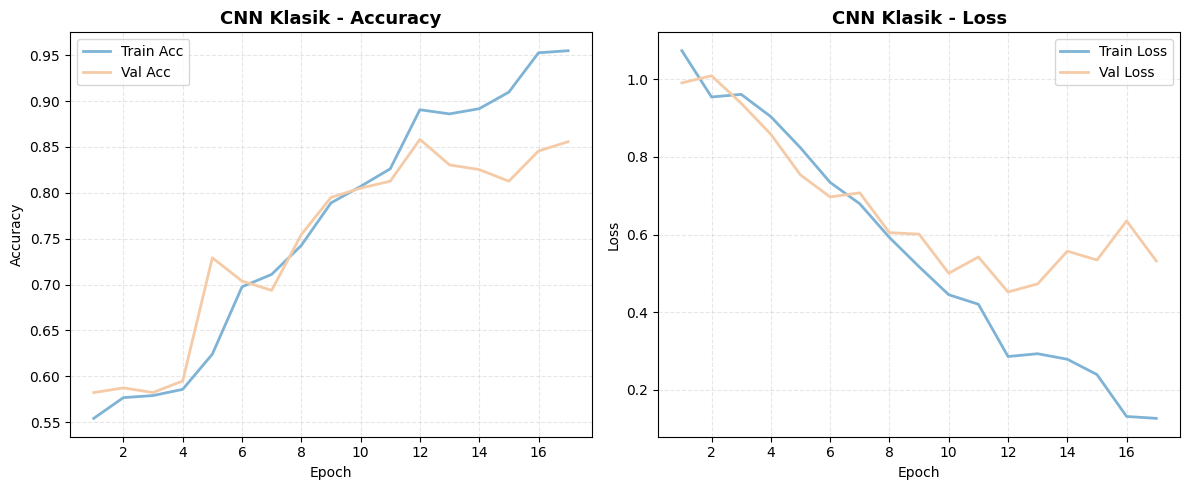

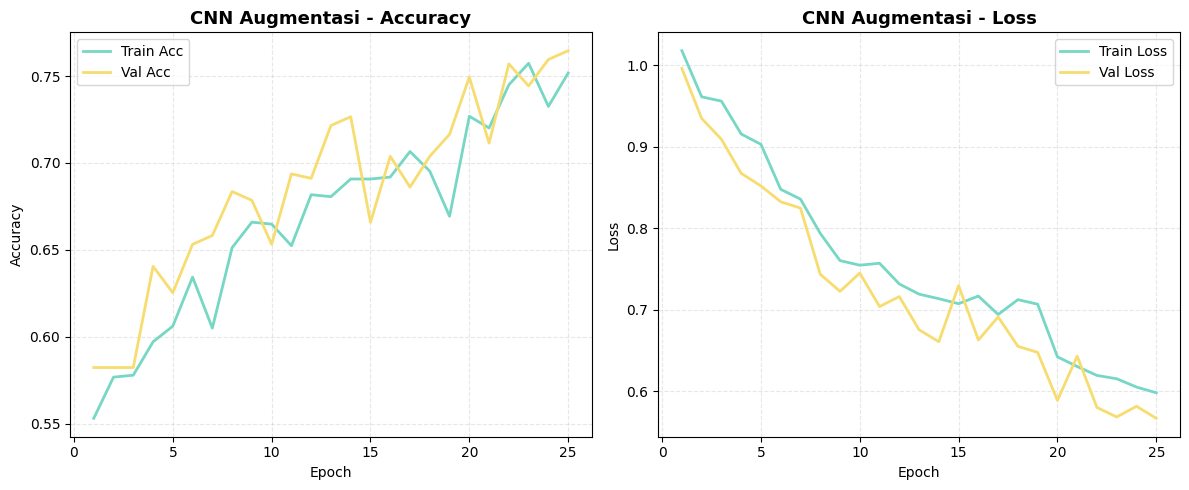

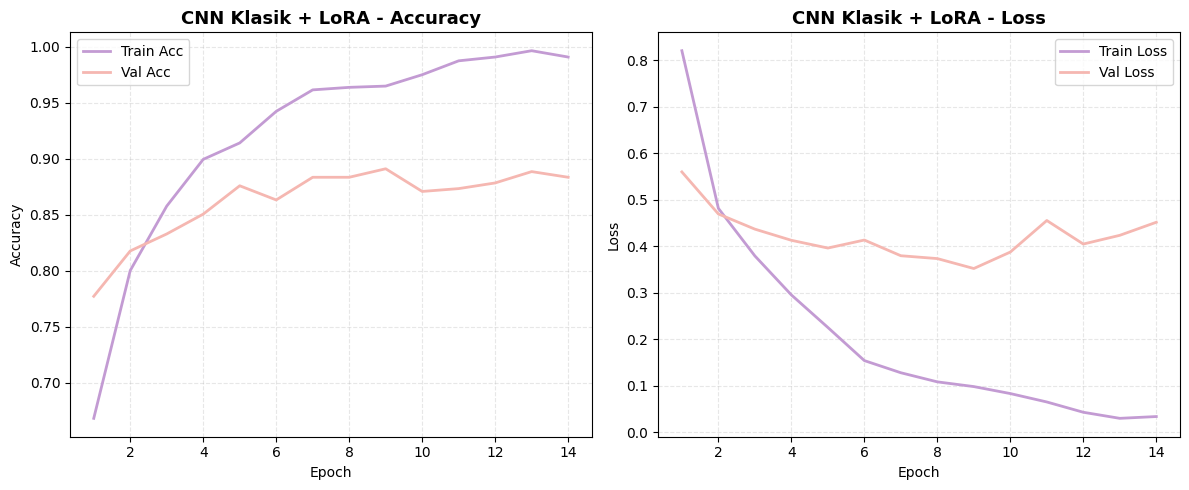

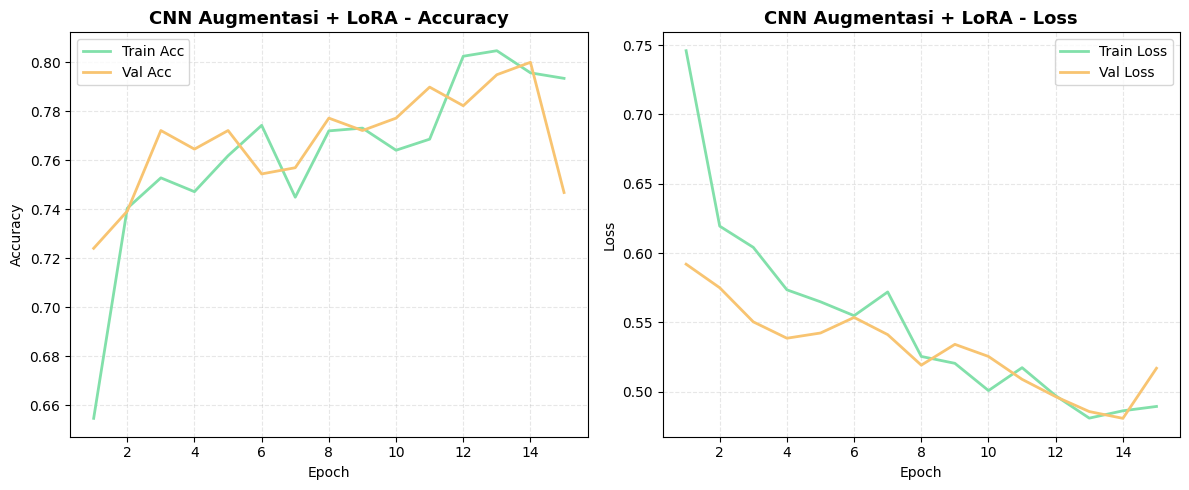


================= EVALUASI DETIL PER MODEL (TEST SET) =================

📄 Classification Report - CNN_Klasik
              precision    recall  f1-score   support

    INDOLOGO     0.7745    0.8404    0.8061        94
   INTERLOGO     0.6875    0.6471    0.6667        17
     NOHALAL     0.6207    0.5000    0.5538        36

    accuracy                         0.7347       147
   macro avg     0.6942    0.6625    0.6755       147
weighted avg     0.7268    0.7347    0.7282       147

💾 Classification report tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/history/CNN_Klasik_classification_report.txt


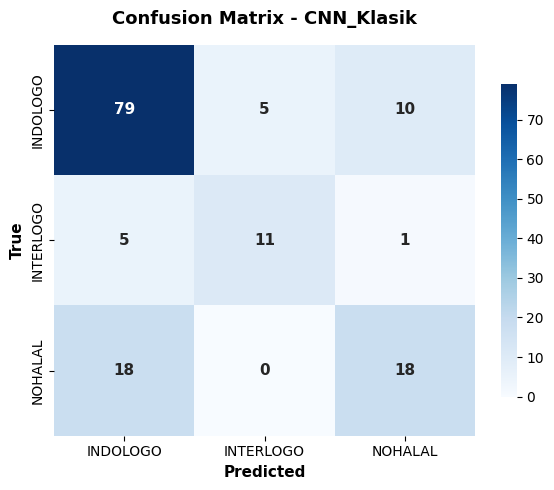

💾 Confusion matrix tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik/plots/CNN_Klasik_cm.png

📄 Classification Report - CNN_Augmentasi
              precision    recall  f1-score   support

    INDOLOGO     0.7300    0.7766    0.7526        94
   INTERLOGO     0.5000    0.2941    0.3704        17
     NOHALAL     0.5135    0.5278    0.5205        36

    accuracy                         0.6599       147
   macro avg     0.5812    0.5328    0.5478       147
weighted avg     0.6504    0.6599    0.6516       147

💾 Classification report tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/history/CNN_Augmentasi_classification_report.txt


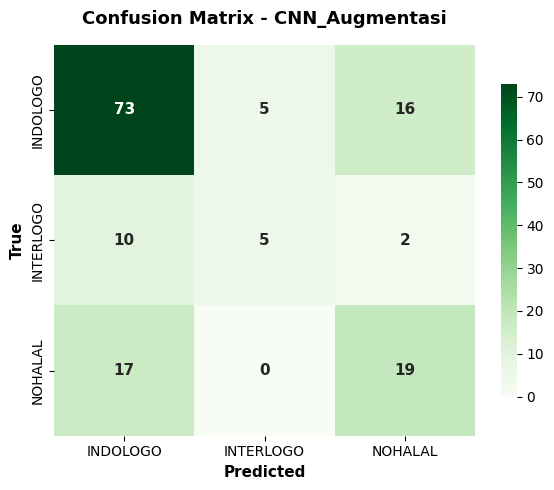

💾 Confusion matrix tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi/plots/CNN_Augmentasi_cm.png

📄 Classification Report - CNN_Klasik_LoRA
              precision    recall  f1-score   support

    INDOLOGO     0.8137    0.8830    0.8469        94
   INTERLOGO     0.7059    0.7059    0.7059        17
     NOHALAL     0.7143    0.5556    0.6250        36

    accuracy                         0.7823       147
   macro avg     0.7446    0.7148    0.7259       147
weighted avg     0.7769    0.7823    0.7763       147

💾 Classification report tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/history/CNN_Klasik_LoRA_classification_report.txt


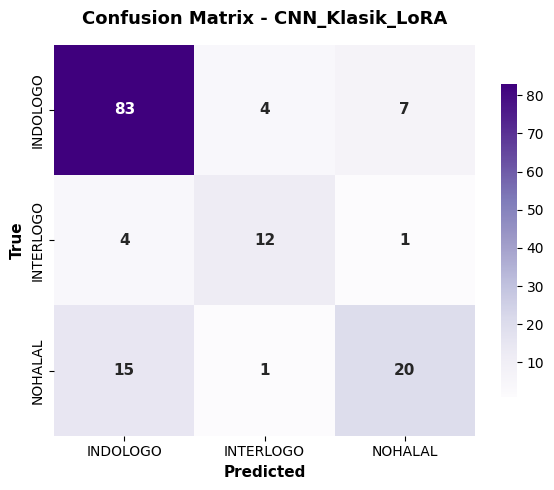

💾 Confusion matrix tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/plots/CNN_Klasik_LoRA_cm.png



📄 Classification Report - CNN_Augmentasi_LoRA
              precision    recall  f1-score   support

    INDOLOGO     0.8000    0.8511    0.8247        94
   INTERLOGO     0.5714    0.4706    0.5161        17
     NOHALAL     0.6364    0.5833    0.6087        36

    accuracy                         0.7415       147
   macro avg     0.6693    0.6350    0.6499       147
weighted avg     0.7335    0.7415    0.7361       147

💾 Classification report tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/history/CNN_Augmentasi_LoRA_classification_report.txt


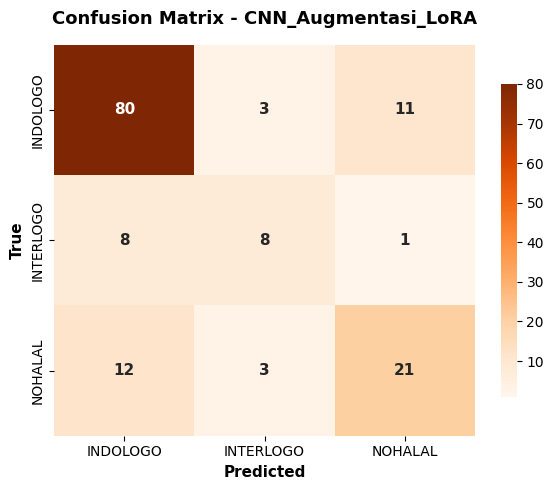

💾 Confusion matrix tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Augmentasi_LoRA/plots/CNN_Augmentasi_LoRA_cm.png

📌 Ringkasan Akurasi & Loss di Test Set (CNN vs LoRA)

                   Model  Test Accuracy  Test Loss
0             CNN Klasik         0.7347     1.1378
1      CNN Klasik + LoRA         0.7823     1.0632
2         CNN Augmentasi         0.6599     0.6785
3  CNN Augmentasi + LoRA         0.7415     0.6144

💾 Tabel ringkasan disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/cnn_lora_test_summary.csv


/tmp/ipython-input-4237799654.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


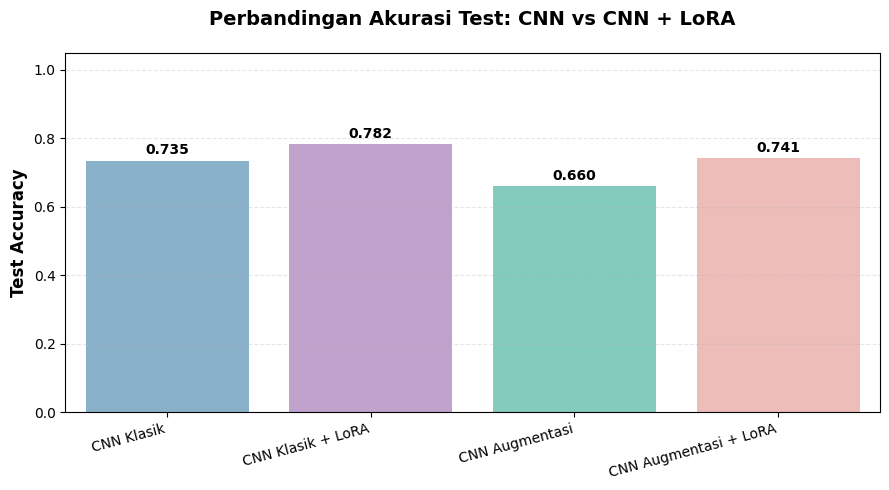

💾 Plot akurasi test tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/cnn_lora_test_accuracy_comparison.png


In [ ]:
# ========================================
# CELL: Evaluasi Lengkap CNN + LoRA (FIXED)
# ========================================

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 0. Pastikan history dalam bentuk dict
def ensure_history_dict(h):
    # Kalau masih objek History Keras
    if hasattr(h, "history"):
        return h.history
    # Kalau sudah dict (hasil np.load)
    return h

history_classic_dict       = ensure_history_dict(history_classic)
history_aug_dict           = ensure_history_dict(history_aug)
history_classic_lora_dict  = ensure_history_dict(history_classic_lora)
history_aug_lora_dict      = ensure_history_dict(history_aug_lora)

# 1. Helper plotting training curves
def plot_training_history(history_dict, title, color_train, color_val, save_path=None):
    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc', color=color_train, linewidth=2)
    plt.plot(epochs_range, val_acc, label='Val Acc', color=color_val, linewidth=2)
    plt.title(f'{title} - Accuracy', fontsize=13, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3, linestyle='--')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color=color_train, linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss', color=color_val, linewidth=2)
    plt.title(f'{title} - Loss', fontsize=13, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3, linestyle='--')
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()


# 2. Helper classification report + confusion matrix
def evaluate_and_visualize(model, name, generator, base_dir, cmap='Blues'):
    generator.reset()
    y_true = generator.classes
    y_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    class_indices = generator.class_indices
    labels = list(class_indices.keys())

    # Classification report
    cr = classification_report(y_true, y_pred, target_names=labels, digits=4)
    print(f"\n📄 Classification Report - {name}")
    print(cr)

    report_path = os.path.join(base_dir, 'history', f'{name.replace(" ", "_")}_classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(cr)
    print(f"💾 Classification report tersimpan di: {report_path}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'shrink': 0.8},
        annot_kws={'fontsize': 11, 'fontweight': 'bold'}
    )
    plt.title(f'Confusion Matrix - {name}', fontsize=13, fontweight='bold', pad=15)
    plt.xlabel('Predicted', fontsize=11, fontweight='bold')
    plt.ylabel('True', fontsize=11, fontweight='bold')
    plt.tight_layout()

    cm_path = os.path.join(base_dir, 'plots', f'{name.replace(" ", "_")}_cm.png')
    plt.savefig(cm_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Confusion matrix tersimpan di: {cm_path}")

    return cr, cm


# 3. Plot training curves untuk 4 model
print("📊 Training Curves CNN & LoRA")

plot_training_history(
    history_classic_dict,
    title="CNN Klasik",
    color_train="#7FB3D5",
    color_val="#F5CBA7",
    save_path=os.path.join(CNN_CLASSIC_DIR, 'plots', 'cnn_classic_training_curves.png')
)

plot_training_history(
    history_aug_dict,
    title="CNN Augmentasi",
    color_train="#76D7C4",
    color_val="#F7DC6F",
    save_path=os.path.join(CNN_AUG_DIR, 'plots', 'cnn_aug_training_curves.png')
)

plot_training_history(
    history_classic_lora_dict,
    title="CNN Klasik + LoRA",
    color_train="#C39BD3",
    color_val="#F5B7B1",
    save_path=os.path.join(CNN_CLASSIC_LORA_DIR, 'plots', 'cnn_classic_lora_training_curves.png')
)

plot_training_history(
    history_aug_lora_dict,
    title="CNN Augmentasi + LoRA",
    color_train="#82E0AA",
    color_val="#F8C471",
    save_path=os.path.join(CNN_AUG_LORA_DIR, 'plots', 'cnn_aug_lora_training_curves.png')
)


# 4. Classification Report + Confusion Matrix

print("\n================= EVALUASI DETIL PER MODEL (TEST SET) =================")

cnn_classic_model.load_weights(checkpoint_path_classic)
cnn_aug_model.load_weights(checkpoint_path_aug)
cnn_classic_lora.load_weights(checkpoint_path_classic_lora)
cnn_aug_lora.load_weights(checkpoint_path_aug_lora)

cr_c, cm_c = evaluate_and_visualize(
    cnn_classic_model,
    name="CNN_Klasik",
    generator=test_simple_gen,
    base_dir=CNN_CLASSIC_DIR,
    cmap="Blues"
)

cr_a, cm_a = evaluate_and_visualize(
    cnn_aug_model,
    name="CNN_Augmentasi",
    generator=test_simple_gen,
    base_dir=CNN_AUG_DIR,
    cmap="Greens"
)

cr_cl, cm_cl = evaluate_and_visualize(
    cnn_classic_lora,
    name="CNN_Klasik_LoRA",
    generator=test_simple_gen,
    base_dir=CNN_CLASSIC_LORA_DIR,
    cmap="Purples"
)

cr_al, cm_al = evaluate_and_visualize(
    cnn_aug_lora,
    name="CNN_Augmentasi_LoRA",
    generator=test_simple_gen,
    base_dir=CNN_AUG_LORA_DIR,
    cmap="Oranges"
)


# 5. Ringkasan Akurasi & Loss dalam Tabel + Bar Plot

print("\n📌 Ringkasan Akurasi & Loss di Test Set (CNN vs LoRA)\n")

test_simple_gen.reset()
test_loss_c, test_acc_c = cnn_classic_model.evaluate(test_simple_gen, verbose=0)

test_simple_gen.reset()
test_loss_a, test_acc_a = cnn_aug_model.evaluate(test_simple_gen, verbose=0)

test_simple_gen.reset()
test_loss_cl, test_acc_cl = cnn_classic_lora.evaluate(test_simple_gen, verbose=0)

test_simple_gen.reset()
test_loss_al, test_acc_al = cnn_aug_lora.evaluate(test_simple_gen, verbose=0)

summary_dict = {
    "Model": [
        "CNN Klasik",
        "CNN Klasik + LoRA",
        "CNN Augmentasi",
        "CNN Augmentasi + LoRA"
    ],
    "Test Accuracy": [
        test_acc_c,
        test_acc_cl,
        test_acc_a,
        test_acc_al
    ],
    "Test Loss": [
        test_loss_c,
        test_loss_cl,
        test_loss_a,
        test_loss_al
    ]
}

df_summary = pd.DataFrame(summary_dict)
print(df_summary.round(4))

summary_csv_path = os.path.join(DEEP_LEARNING_DIR, "cnn_lora_test_summary.csv")
df_summary.to_csv(summary_csv_path, index=False)
print(f"\n💾 Tabel ringkasan disimpan di: {summary_csv_path}")

plt.figure(figsize=(9, 5))
palette = ["#7FB3D5", "#C39BD3", "#76D7C4", "#F5B7B1"]

sns.barplot(
    data=df_summary,
    x="Model",
    y="Test Accuracy",
    palette=palette
)
plt.ylim(0, 1.05)
plt.title("Perbandingan Akurasi Test: CNN vs CNN + LoRA", fontsize=14, fontweight="bold", pad=20)
plt.xlabel("")
plt.ylabel("Test Accuracy", fontsize=12, fontweight="bold")
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", alpha=0.3, linestyle="--")

for idx, v in enumerate(df_summary["Test Accuracy"]):
    plt.text(idx, v + 0.01, f"{v:.3f}", ha="center", va="bottom",
             fontsize=10, fontweight="bold")

acc_plot_path = os.path.join(DEEP_LEARNING_DIR, "cnn_lora_test_accuracy_comparison.png")
plt.tight_layout()
plt.savefig(acc_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"💾 Plot akurasi test tersimpan di: {acc_plot_path}")

# 3.VIT MANUAL + LoRA & VIT Default + LoRA

> Sebelum menjalankan program ini, pastikan untuk jalakan CELL 1 diatas.

## 2.ViT Manual + LoRA
> Kita buat ViT sederhana (patch embedding + encoder blocks) lalu tambahkan LoRA di Attention projection.

- 2.1. Utility: Patch & ViT Block + LoRA
Tambahkan di cell baru (setelah fungsi CNN):

In [ ]:
# ========================================
# ViT Manual + LoRA Building Blocks
# ========================================
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras import Model

# 1. Patch Embedding layer
class PatchEmbedding(Layer):
    def __init__(self, patch_size=16, embed_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = layers.Conv2D(filters=embed_dim,
                                  kernel_size=patch_size,
                                  strides=patch_size,
                                  padding='valid')
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        x = self.proj(x)          # (B, H/ps, W/ps, D)
        x = self.flatten(x)       # (B, N_patches, D)
        return x

# 2. LoRA for Dense projector (for Q,K,V or output projection)
class LoRADense(Layer):
    def __init__(self, units, rank=8, alpha=1.0, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.alpha = alpha
        self.use_bias = use_bias

    def build(self, input_shape):
        last_dim = int(input_shape[-1])  # D_in
        # Base dense (frozen ketika fine-tuning, kita akan atur diluar)
        self.base_dense = Dense(self.units, use_bias=self.use_bias, name=self.name + "_base")

        # LoRA low-rank adapters
        self.lora_A = self.add_weight(
            shape=(last_dim, self.rank),
            initializer="random_normal",
            trainable=True,
            name=self.name + "_A"
        )
        self.lora_B = self.add_weight(
            shape=(self.rank, self.units),
            initializer="zeros",
            trainable=True,
            name=self.name + "_B"
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.units,),
                initializer="zeros",
                trainable=True,
                name=self.name + "_bias"
            )
        else:
            self.bias = None

    def call(self, inputs):
        base_out = self.base_dense(inputs)
        lora_out = tf.matmul(inputs, self.lora_A)
        lora_out = tf.matmul(lora_out, self.lora_B) * (self.alpha / self.rank)
        out = base_out + lora_out
        if self.bias is not None:
            out = out + self.bias
        return out

# 3. Multi-head Self Attention dengan LoRA di Q,K,V,Out
class MultiHeadSelfAttentionLoRA(Layer):
    def __init__(self, dim, num_heads=4, rank=8, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        assert dim % num_heads == 0
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.rank = rank
        self.dropout = dropout

        self.q_proj = LoRADense(dim, rank=rank, name=self.name + "_q")
        self.k_proj = LoRADense(dim, rank=rank, name=self.name + "_k")
        self.v_proj = LoRADense(dim, rank=rank, name=self.name + "_v")
        self.out_proj = LoRADense(dim, rank=rank, name=self.name + "_o")

        self.drop = Dropout(dropout)

    def _reshape_heads(self, x, batch_size):
        # (B, N, D) -> (B, num_heads, N, head_dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def _merge_heads(self, x, batch_size):
        # (B, num_heads, N, head_dim) -> (B, N, D)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.dim))

    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self._reshape_heads(q, batch_size)
        k = self._reshape_heads(k, batch_size)
        v = self._reshape_heads(v, batch_size)

        scale = tf.math.rsqrt(tf.cast(self.head_dim, tf.float32))
        attn_scores = tf.matmul(q, k, transpose_b=True) * scale
        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attn_weights = self.drop(attn_weights, training=training)

        context = tf.matmul(attn_weights, v)
        context = self._merge_heads(context, batch_size)

        out = self.out_proj(context)
        out = self.drop(out, training=training)
        return out

# 4. ViT Encoder Block dengan LoRA di Attention
def vit_encoder_block_lora(x, dim, num_heads=4, mlp_ratio=4.0,
                           dropout=0.1, rank=8, name_prefix="encoder"):
    # LayerNorm + Attention
    x_norm1 = LayerNormalization(epsilon=1e-6, name=name_prefix + "_ln1")(x)
    attn_out = MultiHeadSelfAttentionLoRA(
        dim=dim, num_heads=num_heads, rank=rank, dropout=dropout,
        name=name_prefix + "_attn"
    )(x_norm1)
    x = layers.Add(name=name_prefix + "_add1")([x, attn_out])

    # LayerNorm + MLP
    x_norm2 = LayerNormalization(epsilon=1e-6, name=name_prefix + "_ln2")(x)
    mlp_hidden = int(dim * mlp_ratio)
    mlp = Dense(mlp_hidden, activation='gelu', name=name_prefix + "_mlp1")(x_norm2)
    mlp = Dropout(dropout, name=name_prefix + "_mlp_drop")(mlp)
    mlp = Dense(dim, name=name_prefix + "_mlp2")(mlp)
    mlp = Dropout(dropout, name=name_prefix + "_mlp_drop2")(mlp)

    x = layers.Add(name=name_prefix + "_add2")([x, mlp])
    return x

- 2.2. Bangun ViT Manual + LoRA

In [ ]:
# ========================================
# Build ViT Manual + LoRA (Fine-tuned)
# ========================================

def build_vit_manual_lora(
    input_shape=(128, 128, 3),
    num_classes=3,
    patch_size=16,
    embed_dim=64,
    depth=4,
    num_heads=4,
    mlp_ratio=4.0,
    rank=8,
    dropout=0.1
):
    inputs = layers.Input(shape=input_shape, name="vit_input")

    # Patch Embedding
    x = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim, name="patch_embedding")(inputs)

    # Positional embedding
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    pos_embed = self_pos_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=embed_dim, name="pos_embedding"
    )

    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_encoding = pos_embed(positions)  # (N_patches, D)
    x = x + pos_encoding

    # Encoder blocks with LoRA
    for i in range(depth):
        x = vit_encoder_block_lora(
            x,
            dim=embed_dim,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout,
            rank=rank,
            name_prefix=f"encoder_{i+1}"
        )

    # Classification head (CLS by global average)
    x = layers.GlobalAveragePooling1D(name="global_pool")(x)
    x = layers.Dropout(dropout, name="head_drop")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="head")(x)

    model = Model(inputs=inputs, outputs=outputs, name="ViT_Manual_LoRA")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model

> Catatan: di sini kita langsung melatih ViT Manual + LoRA dari awal (karena “pretrained manual” di konteks tugas biasanya maksudnya arsitektur dibuat sendiri, bukan benar‑benar pretrain besar). Jika dosen benar‑benar ingin pretraining dulu di dataset lain, itu akan jadi eksperimen tambahan.

- 2.3. Train ViT Manual + LoRA

In [ ]:
# ========================================
# Train ViT Manual + LoRA
# ========================================

EPOCHS_VIT = 25

vit_manual_lora = build_vit_manual_lora(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(class_names),
    patch_size=16,
    embed_dim=64,
    depth=4,
    num_heads=4,
    mlp_ratio=4.0,
    rank=8,
    dropout=0.1
)

checkpoint_path_vit_manual = os.path.join(
    VIT_MANUAL_LORA_DIR, 'models', 'vit_manual_lora_best.h5'
)
log_path_vit_manual = os.path.join(
    VIT_MANUAL_LORA_DIR, 'history', 'vit_manual_lora_history.npy'
)

cb_es_vit_manual = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

cb_ckpt_vit_manual = callbacks.ModelCheckpoint(
    checkpoint_path_vit_manual,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_vit_manual = vit_manual_lora.fit(
    train_simple_gen,                # bisa juga train_aug_gen kalau mau augmentasi
    epochs=EPOCHS_VIT,
    validation_data=valid_simple_gen,
    callbacks=[cb_es_vit_manual, cb_ckpt_vit_manual]
)

np.save(log_path_vit_manual, history_vit_manual.history)

print(f"💾 History ViT Manual + LoRA disimpan di: {log_path_vit_manual}")
print(f"💾 Model terbaik ViT Manual + LoRA disimpan di: {checkpoint_path_vit_manual}")

Model: "ViT_Manual_LoRA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vit_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 64, 64)    │     49,216 │ vit_input[0][0]   │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_ln1       │ (None, 64, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_attn      │ (None, None, 64)  │     20,992 │ encoder_1_ln1[0]… │
│ (MultiHeadSelfAtte… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_add1      │ (None, None, 64)  │          0 │ add[0][0],        │
│ (Add)               │                   │            │ encoder_1_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_ln2       │ (None, None, 64)  │        128 │ encoder_1_add1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_mlp1      │ (None, None, 256) │     16,640 │ encoder_1_ln2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_mlp_drop  │ (None, None, 256) │          0 │ encoder_1_mlp1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_mlp2      │ (None, None, 64)  │     16,448 │ encoder_1_mlp_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_mlp_drop2 │ (None, None, 64)  │          0 │ encoder_1_mlp2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_add2      │ (None, None, 64)  │          0 │ encoder_1_add1[0… │
│ (Add)               │                   │            │ encoder_1_mlp_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_ln1       │ (None, None, 64)  │        128 │ encoder_1_add2[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_attn      │ (None, None, 64)  │     20,992 │ encoder_2_ln1[0]… │
│ (MultiHeadSelfAtte… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_add1      │ (None, None, 64)  │          0 │ encoder_1_add2[0… │
│ (Add)               │                   │            │ encoder_2_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_ln2       │ (None, None, 64)  │        128 │ encoder_2_add1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_mlp1      │ (None, None, 256) │     16,640 │ encoder_2_ln2[0]… │
│ (Dense)             │                   │            │                 

 Total params: 266,755 (1.02 MB)

 Trainable params: 266,755 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.4234 - loss: 2.4407
Epoch 1: val_loss improved from inf to 1.07170, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4243 - loss: 2.4222 - val_accuracy: 0.6025 - val_loss: 1.0717
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4741 - loss: 1.2431
Epoch 2: val_loss did not improve from 1.07170
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.4745 - loss: 1.2425 - val_accuracy: 0.5848 - val_loss: 1.3054
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5586 - loss: 1.0624
Epoch 3: val_loss did not improve from 1.07170
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.5573 - loss: 1.0644 - val_accuracy: 0.2987 - val_loss: 1.1479
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4675 - loss: 1.1240
Epoch 4: val_loss improved from 1.07170 to 0.95477, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.4688 - loss: 1.1226 - val_accuracy: 0.5949 - val_loss: 0.9548
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5893 - loss: 0.9889
Epoch 5: val_loss improved from 0.95477 to 0.90282, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.5881 - loss: 0.9893 - val_accuracy: 0.5975 - val_loss: 0.9028
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5654 - loss: 0.9923
Epoch 6: val_loss improved from 0.90282 to 0.90056, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5649 - loss: 0.9933 - val_accuracy: 0.6380 - val_loss: 0.9006
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5934 - loss: 0.9650
Epoch 7: val_loss did not improve from 0.90056
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5922 - loss: 0.9662 - val_accuracy: 0.6405 - val_loss: 0.9592
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6017 - loss: 0.9548
Epoch 8: val_loss did not improve from 0.90056
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.6008 - loss: 0.9562 - val_accuracy: 0.5949 - val_loss: 0.9927
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6004 - loss: 0.9470
Epoch 9: val_loss improved from 0.90056 to 0.88493, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.6002 - loss: 0.9470 - val_accuracy: 0.6253 - val_loss: 0.8849
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5638 - loss: 0.9716
Epoch 10: val_loss improved from 0.88493 to 0.86187, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_Manual_LoRA/models/vit_manual_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.5645 - loss: 0.9709 - val_accuracy: 0.6329 - val_loss: 0.8619
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6080 - loss: 0.9393
Epoch 11: val_loss did not improve from 0.86187
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6077 - loss: 0.9394 - val_accuracy: 0.6228 - val_loss: 0.8674
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6407 - loss: 0.8949
Epoch 12: val_loss did not improve from 0.86187
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6394 - loss: 0.8961 - val_accuracy: 0.6532 - val_loss: 0.8743
Epoch 13/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5908 - loss: 0.9719
Epoch 13: val_loss did not improve from 0.86187
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.5914 - loss: 0.9704 - val_accuracy: 0.6000 - val_loss: 0.8942
Epoch 14/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5066 - loss: 0.9679
Epoch 14: val_loss did not improve from 

## 2.b EffiecientNet Pretrained + LoRA
> EfficientNet Pretrained + LoRA → mewakili “model vision pretrained bawaan + LoRA”.
Kalau dosen sangat keras harus “ViT pretrained”, kita bisa jelaskan di laporan: di environment Colab/TF saat ini paket ViT pretrained resmi tidak tersedia/kompatibel, sehingga kamu menggantinya dengan EfficientNet sebagai pretrained backbone, tapi pipeline LoRA tetap sama.

- 2. Build EfficientNet Pretrained + LoRA (ganti “ViT Pretrained + LoRA”)

In [ ]:
# ========================================
# Build EfficientNet Pretrained + LoRA (keras.applications)
# ========================================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

def build_effnet_pretrained_lora(
    input_shape=(128, 128, 3),
    num_classes=3,
    rank=32
):
    """
    Backbone: EfficientNetB0 pretrained ImageNet (keras.applications).
    Di atas backbone (feature map) kita pasang head dengan LoRA-style adapter (Dense low-rank).
    """

    inputs = Input(shape=input_shape, name="effnet_input")

    # Preprocess: EfficientNet biasanya input 224x224, tapi B0 bisa handle 128x128 juga.
    x = layers.Rescaling(1./255, name="effnet_rescale")(inputs)

    # Pretrained EfficientNetB0 tanpa top
    backbone = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling=None      # kita pakai GlobalAveragePooling2D sendiri
    )
    backbone.trainable = False   # freeze backbone

    features = backbone.output   # (B, H, W, C)
    x = GlobalAveragePooling2D(name="effnet_global_pool")(features)  # (B, C)

    # LoRA-style head: base Dense + low-rank adapter
    base_dense = Dense(256, activation=None, name="effnet_head_base")(x)

    # LoRA A/B
    lora_A = Dense(rank, use_bias=False, name="effnet_head_A")(x)
    lora_B = Dense(256, use_bias=False, name="effnet_head_B")(lora_A)

    head = layers.Add(name="effnet_head_add")([base_dense, lora_B])
    head = layers.Activation('relu', name="effnet_head_act")(head)
    head = Dropout(0.5, name="effnet_head_drop")(head)

    outputs = Dense(num_classes, activation="softmax", name="effnet_head_logits")(head)

    model = Model(inputs=inputs, outputs=outputs, name="EffNet_Pretrained_LoRA")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model

In [ ]:
# ========================================
# Train EfficientNet Pretrained + LoRA
# ========================================

EPOCHS_EFFNET_PRE = 20

effnet_pretrained_lora = build_effnet_pretrained_lora(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(class_names),
    rank=32   # bisa 16/32; 32 biasanya cukup
)

checkpoint_path_effnet_pre = os.path.join(
    EffNET_PRETRAINED_LORA_DIR, 'models', 'effnet_pretrained_lora_best.h5'
)
log_path_effnet_pre = os.path.join(
    EffNET_PRETRAINED_LORA_DIR, 'history', 'effnet_pretrained_lora_history.npy'
)

cb_es_effnet_pre = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cb_ckpt_effnet_pre = callbacks.ModelCheckpoint(
    filepath=checkpoint_path_effnet_pre,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_effnet_pre = effnet_pretrained_lora.fit(
    train_aug_gen,           # pakai augmentasi, karena ini backbone kuat
    epochs=EPOCHS_EFFNET_PRE,
    validation_data=valid_aug_gen,
    callbacks=[cb_es_effnet_pre, cb_ckpt_effnet_pre]
)

np.save(log_path_effnet_pre, history_effnet_pre.history)

print(f"💾 History EffNet Pretrained + LoRA disimpan di: {log_path_effnet_pre}")
print(f"💾 Model terbaik EffNet Pretrained + LoRA disimpan di: {checkpoint_path_effnet_pre}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNet_Pretrained_LoRA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ effnet_input        │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ effnet_rescale      │ (None, 128, 128,  │          0 │ effnet_input[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ effnet_rescale[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,427,430 (16.89 MB)

 Trainable params: 377,859 (1.44 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4811 - loss: 1.0290
Epoch 1: val_loss improved from inf to 0.94612, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/EffNet_Pretrained_LoRA/models/effnet_pretrained_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4831 - loss: 1.0284 - val_accuracy: 0.5823 - val_loss: 0.9461
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5205 - loss: 1.0466
Epoch 2: val_loss did not improve from 0.94612
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 285ms/step - accuracy: 0.5219 - loss: 1.0444 - val_accuracy: 0.5823 - val_loss: 0.9543
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5625 - loss: 0.9856
Epoch 3: val_loss improved from 0.94612 to 0.94377, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/EffNet_Pretrained_LoRA/models/effnet_pretrained_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.5629 - loss: 0.9850 - val_accuracy: 0.5823 - val_loss: 0.9438
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5883 - loss: 0.9550
Epoch 4: val_loss improved from 0.94377 to 0.94368, saving model to /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/EffNet_Pretrained_LoRA/models/effnet_pretrained_lora_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.5880 - loss: 0.9551 - val_accuracy: 0.5823 - val_loss: 0.9437
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5651 - loss: 0.9855
Epoch 5: val_loss did not improve from 0.94368
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.5655 - loss: 0.9851 - val_accuracy: 0.5823 - val_loss: 0.9444
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5769 - loss: 0.9551
Epoch 6: val_loss did not improve from 0.94368
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.5770 - loss: 0.9549 - val_accuracy: 0.5823 - val_loss: 0.9442
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6155 - loss: 0.9106
Epoch 7: val_loss did not improve from 0.94368
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - accuracy: 0.6140 - loss: 0.9122 - val_accuracy: 0.5823 - val_loss: 0.9497
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5783 - loss: 0.9625
Epoch 8: val_loss did not improve from 0.9436

# 4.ViT Pretrained (bawaan library) + LoRA
> Kita pakai model ViT kecil dari tensorflow.keras.applications (kalau belum tersedia, bisa pakai keras_cv atau timm via pip – tapi untuk tugas, biasanya cukup pakai yang ada).

>Di sini aku contohkan dengan keras_cv ViTClassifier` (kalau kampus tidak masalah install tambahan). Kalau tidak boleh internet/pip, nanti kita fallback ke model yang sudah kamu install.

```
/content/drive/MyDrive/Machine-Learning-Experiment/
├── results/
│   └── 5_Deep_Learning/
│       ├── ViT_LoRA/
│       │   ├── models/
│       │   │   └── best_vit_lora_model.pth
│       │   ├── history/
│       │   │   └── vit_lora_history.npz
│       │   └── plots/
│       │       ├── vit_lora_training_history.png
│       │       └── vit_lora_comprehensive_results.png
│       └── ... (folder CNN yang sudah ada)
```

## CELL 1: Setup & Import Libraries

In [ ]:
# ========================================
# CELL 1: Setup & Import Libraries
# ========================================

!pip install -q timm peft

import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Setup base directories
BASE_DIR = '/content/drive/MyDrive/Machine-Learning-Experiment'
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
DEEP_LEARNING_DIR = os.path.join(RESULTS_DIR, '5_Deep_Learning')

# Folder khusus ViT + LoRA (PyTorch)
VIT_LORA_DIR = os.path.join(DEEP_LEARNING_DIR, 'ViT_LoRA')
VIT_LORA_MODELS_DIR = os.path.join(VIT_LORA_DIR, 'models')
VIT_LORA_HISTORY_DIR = os.path.join(VIT_LORA_DIR, 'history')
VIT_LORA_PLOTS_DIR = os.path.join(VIT_LORA_DIR, 'plots')

os.makedirs(VIT_LORA_MODELS_DIR, exist_ok=True)
os.makedirs(VIT_LORA_HISTORY_DIR, exist_ok=True)
os.makedirs(VIT_LORA_PLOTS_DIR, exist_ok=True)

print("✅ Google Drive mounted")
print(f"📁 BASE_DIR     : {BASE_DIR}")
print(f"📁 DATASET_DIR  : {DATASET_DIR}")
print(f"📁 RESULTS_DIR  : {RESULTS_DIR}")
print(f"📁 VIT_LORA_DIR : {VIT_LORA_DIR}")

# 3. Import PyTorch & utilities
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import timm
from peft import LoraConfig, get_peft_model

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# 4. Global config
DATASET_PATH = os.path.join(DATASET_DIR, 'namaikna-2')
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 5e-5
NUM_CLASSES = 3
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHT_DECAY = 0.05
LABEL_SMOOTHING = 0.1
PATIENCE = 10   # early stopping

CLASS_NAMES = ['INDOLOGO', 'INTERLOGO', 'NOHALAL']

print("\n📋 Konfigurasi:")
print(f"   Dataset Path : {DATASET_PATH}")
print(f"   Batch Size   : {BATCH_SIZE}")
print(f"   Epochs       : {NUM_EPOCHS}")
print(f"   LR           : {LEARNING_RATE}")
print(f"   Weight Decay : {WEIGHT_DECAY}")
print(f"   Label Smooth : {LABEL_SMOOTHING}")
print(f"   Image Size   : {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"   Device       : {DEVICE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 BASE_DIR     : /content/drive/MyDrive/Machine-Learning-Experiment
📁 DATASET_DIR  : /content/drive/MyDrive/Machine-Learning-Experiment/datasets
📁 RESULTS_DIR  : /content/drive/MyDrive/Machine-Learning-Experiment/results
📁 VIT_LORA_DIR : /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA

📋 Konfigurasi:
   Dataset Path : /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2
   Batch Size   : 16
   Epochs       : 20
   LR           : 5e-05
   Weight Decay : 0.05
   Label Smooth : 0.1
   Image Size   : 224x224
   Device       : cuda


## CELL 2: Load & Explore Dataset (EDA)


🔍 Split: train
   images dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/train/images  -> 798 files
   labels dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/train/labels  -> 798 files

🔍 Split: valid
   images dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/valid/images  -> 0 files
   labels dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/valid/labels  -> 0 files

🔍 Split: test
   images dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images  -> 113 files
   labels dir: /content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/labels  -> 113 files

📊 Distribusi objek (berdasarkan file YOLO labels):
   train:  {'INDOLOGO': 650, 'INTERLOGO': 152, 'NOHALAL': 365}
   valid:  {'INDOLOGO': 0, 'INTERLOGO': 0, 'NOHALAL': 0}
   test:  {'INDOLOGO': 95, 'INTERLOGO': 17, 'NOHALAL': 45}


/tmp/ipython-input-4181743661.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CLASS_NAMES, y=train_counts, palette=["#7FB3D5", "#F7DC6F", "#F5B7B1"])


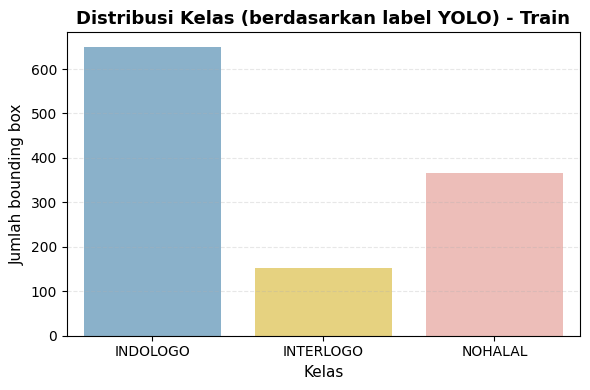


💾 Plot distribusi kelas train disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/plots/vit_lora_train_class_distribution.png


In [ ]:
# ========================================
# CELL 2: Load & Explore Dataset (EDA)
# ========================================

import glob

# Cek folder split
splits = ['train', 'valid', 'test']
for split in splits:
    img_dir = os.path.join(DATASET_PATH, split, 'images')
    lbl_dir = os.path.join(DATASET_PATH, split, 'labels')
    print(f"\n🔍 Split: {split}")
    print(f"   images dir: {img_dir}  -> {len(glob.glob(os.path.join(img_dir, '*.*')))} files")
    print(f"   labels dir: {lbl_dir}  -> {len(glob.glob(os.path.join(lbl_dir, '*.txt')))} files")

# Fungsi simple untuk menghitung distribusi class dari label YOLO
def count_labels(label_dir, num_classes=3):
    counts = [0] * num_classes
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 1:
                continue
            try:
                cls_id = int(parts[0])
                if 0 <= cls_id < num_classes:
                    counts[cls_id] += 1
            except:
                continue
    return counts

print("\n📊 Distribusi objek (berdasarkan file YOLO labels):")
for split in splits:
    lbl_dir = os.path.join(DATASET_PATH, split, 'labels')
    counts = count_labels(lbl_dir, num_classes=NUM_CLASSES)
    print(f"   {split}: ", {CLASS_NAMES[i]: counts[i] for i in range(NUM_CLASSES)})

# Visualisasi distribusi kelas di train
train_counts = count_labels(os.path.join(DATASET_PATH, 'train', 'labels'), NUM_CLASSES)

plt.figure(figsize=(6,4))
sns.barplot(x=CLASS_NAMES, y=train_counts, palette=["#7FB3D5", "#F7DC6F", "#F5B7B1"])
plt.title("Distribusi Kelas (berdasarkan label YOLO) - Train", fontsize=13, fontweight='bold')
plt.ylabel("Jumlah bounding box", fontsize=11)
plt.xlabel("Kelas", fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
eda_plot_path = os.path.join(VIT_LORA_PLOTS_DIR, "vit_lora_train_class_distribution.png")
plt.savefig(eda_plot_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot distribusi kelas train disimpan di: {eda_plot_path}")

## CELL 3: Data Preprocessing & Augmentation

In [ ]:
# ========================================
# CELL 3: Data Preprocessing & Augmentation (FIXED)
# ========================================

from torch.utils.data import Dataset, DataLoader, random_split

class RoboflowDataset(Dataset):
    """Dataset YOLO: ambil image & class id dari baris pertama file label."""
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not os.path.exists(self.label_dir):
            raise FileNotFoundError(f"Label directory not found: {self.label_dir}")

        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load label
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        label = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    label = int(lines[0].split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label


# Transform (tanpa augmentasi keras, menyesuaikan ImageNet)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # Bisa tambah augmentasi di sini kalau mau:
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

print("\n📥 Loading datasets Roboflow (YOLO)...")

# Dataset full train YOLO
full_train_dataset = RoboflowDataset(
    image_dir=os.path.join(DATASET_PATH, "train/images"),
    label_dir=os.path.join(DATASET_PATH, "train/labels"),
    transform=train_transform
)

# Split train → train + valid (misal 80/20)
val_ratio = 0.2
n_total = len(full_train_dataset)
n_val   = int(n_total * val_ratio)
n_train = n_total - n_val

train_dataset, valid_dataset = random_split(
    full_train_dataset,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

print(f"   Total train images (YOLO): {n_total}")
print(f"   -> Train set : {len(train_dataset)}")
print(f"   -> Valid set : {len(valid_dataset)}")

# Test dataset dari split YOLO 'test'
test_dataset = RoboflowDataset(
    image_dir=os.path.join(DATASET_PATH, "test/images"),
    label_dir=os.path.join(DATASET_PATH, "test/labels"),
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✅ Train samples : {len(train_dataset)}")
print(f"✅ Valid samples : {len(valid_dataset)}")
print(f"✅ Test samples  : {len(test_dataset)}")


📥 Loading datasets Roboflow (YOLO)...
   Total train images (YOLO): 798
   -> Train set : 639
   -> Valid set : 159

✅ Train samples : 639
✅ Valid samples : 159
✅ Test samples  : 113


## CELL 4: Build ViT Model (Pretrained) + LoRA

In [ ]:
# ========================================
# CELL 4: Build ViT Model (Pretrained) + LoRA
# ========================================

print("\n🤖 Loading Vision Transformer pretrained model...")
base_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=NUM_CLASSES        # langsung set output 3 kelas
)

print("\n🔧 Applying LoRA configuration...")
lora_config = LoraConfig(
    r=4,                # rank kecil → parameter hemat
    lora_alpha=8,
    target_modules=["qkv"],  # modul attention utama di ViT timm
    lora_dropout=0.2,
    bias="none",
)

vit_lora_model = get_peft_model(base_model, lora_config)
vit_lora_model = vit_lora_model.to(DEVICE)

vit_lora_model.print_trainable_parameters()

# Loss & optimizer & scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.AdamW(
    vit_lora_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS
)

print("\n✅ ViT + LoRA siap untuk training.")


🤖 Loading Vision Transformer pretrained model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🔧 Applying LoRA configuration...
trainable params: 147,456 || all params: 85,948,419 || trainable%: 0.1716

✅ ViT + LoRA siap untuk training.


## CELL 5: Train Model (dengan Early Stopping)

In [ ]:
# ========================================
# CELL 5: Train ViT + LoRA
# ========================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/len(loader):.4f}',
            'acc':  f'{100.*correct/total:.2f}%'
        })

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device, desc="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total   += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

print(f"\n🚀 Starting ViT + LoRA training for {NUM_EPOCHS} epochs...")
print(f"💻 Device: {DEVICE}")

train_losses, train_accs = [], []
val_losses, val_accs     = [], []
best_val_acc = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    tr_loss, tr_acc = train_epoch(vit_lora_model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)

    val_loss, val_acc = validate(vit_lora_model, valid_loader, criterion, DEVICE, desc="Validation")
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    print(f"📈 Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%")
    print(f"📉 Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.2f}%")
    print(f"🎯 LR        : {scheduler.get_last_lr()[0]:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_ckpt_path = os.path.join(VIT_LORA_MODELS_DIR, 'best_vit_lora_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': vit_lora_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, best_ckpt_path)
        print(f"💾 Best model saved! Val Acc: {best_val_acc:.2f}%  -> {best_ckpt_path}")
    else:
        patience_counter += 1
        print(f"⏳ No improvement for {patience_counter} epoch(s)")

    if patience_counter >= PATIENCE:
        print(f"\n⛔ Early stopping triggered after epoch {epoch+1}")
        print(f"🏆 Best Val Acc: {best_val_acc:.2f}%")
        break

# Simpan history
history_path = os.path.join(VIT_LORA_HISTORY_DIR, 'vit_lora_history.npz')
np.savez(history_path,
         train_losses=train_losses,
         val_losses=val_losses,
         train_accs=train_accs,
         val_accs=val_accs)
print(f"\n💾 History training disimpan di: {history_path}")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting ViT + LoRA training for 20 epochs...
💻 Device: cuda

📊 Epoch 1/20
--------------------------------------------------


📈 Train Loss: 1.2496 | Train Acc: 40.22%
📉 Val Loss  : 1.2782 | Val Acc  : 42.77%
🎯 LR        : 0.000050
💾 Best model saved! Val Acc: 42.77%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 2/20
--------------------------------------------------


📈 Train Loss: 1.1150 | Train Acc: 51.49%
📉 Val Loss  : 1.2143 | Val Acc  : 47.17%
🎯 LR        : 0.000049
💾 Best model saved! Val Acc: 47.17%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 3/20
--------------------------------------------------


📈 Train Loss: 1.0152 | Train Acc: 59.15%
📉 Val Loss  : 1.1353 | Val Acc  : 50.31%
🎯 LR        : 0.000047
💾 Best model saved! Val Acc: 50.31%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 4/20
--------------------------------------------------


📈 Train Loss: 0.9370 | Train Acc: 64.48%
📉 Val Loss  : 1.0469 | Val Acc  : 52.83%
🎯 LR        : 0.000045
💾 Best model saved! Val Acc: 52.83%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 5/20
--------------------------------------------------


📈 Train Loss: 0.8628 | Train Acc: 67.92%
📉 Val Loss  : 0.9616 | Val Acc  : 57.86%
🎯 LR        : 0.000043
💾 Best model saved! Val Acc: 57.86%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 6/20
--------------------------------------------------


📈 Train Loss: 0.7940 | Train Acc: 71.52%
📉 Val Loss  : 0.9000 | Val Acc  : 61.01%
🎯 LR        : 0.000040
💾 Best model saved! Val Acc: 61.01%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 7/20
--------------------------------------------------


📈 Train Loss: 0.7407 | Train Acc: 74.49%
📉 Val Loss  : 0.8495 | Val Acc  : 63.52%
🎯 LR        : 0.000036
💾 Best model saved! Val Acc: 63.52%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 8/20
--------------------------------------------------


📈 Train Loss: 0.6937 | Train Acc: 76.21%
📉 Val Loss  : 0.8108 | Val Acc  : 64.78%
🎯 LR        : 0.000033
💾 Best model saved! Val Acc: 64.78%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 9/20
--------------------------------------------------


📈 Train Loss: 0.6537 | Train Acc: 79.03%
📉 Val Loss  : 0.7830 | Val Acc  : 66.04%
🎯 LR        : 0.000029
💾 Best model saved! Val Acc: 66.04%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 10/20
--------------------------------------------------


📈 Train Loss: 0.6262 | Train Acc: 81.22%
📉 Val Loss  : 0.7625 | Val Acc  : 68.55%
🎯 LR        : 0.000025
💾 Best model saved! Val Acc: 68.55%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 11/20
--------------------------------------------------


📈 Train Loss: 0.6016 | Train Acc: 82.94%
📉 Val Loss  : 0.7455 | Val Acc  : 69.81%
🎯 LR        : 0.000021
💾 Best model saved! Val Acc: 69.81%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 12/20
--------------------------------------------------


📈 Train Loss: 0.5834 | Train Acc: 84.66%
📉 Val Loss  : 0.7345 | Val Acc  : 72.33%
🎯 LR        : 0.000017
💾 Best model saved! Val Acc: 72.33%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 13/20
--------------------------------------------------


📈 Train Loss: 0.5693 | Train Acc: 86.07%
📉 Val Loss  : 0.7267 | Val Acc  : 72.33%
🎯 LR        : 0.000014
⏳ No improvement for 1 epoch(s)

📊 Epoch 14/20
--------------------------------------------------


📈 Train Loss: 0.5572 | Train Acc: 87.17%
📉 Val Loss  : 0.7199 | Val Acc  : 73.58%
🎯 LR        : 0.000010
💾 Best model saved! Val Acc: 73.58%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 15/20
--------------------------------------------------


📈 Train Loss: 0.5497 | Train Acc: 87.64%
📉 Val Loss  : 0.7159 | Val Acc  : 75.47%
🎯 LR        : 0.000007
💾 Best model saved! Val Acc: 75.47%  -> /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth

📊 Epoch 16/20
--------------------------------------------------


📈 Train Loss: 0.5437 | Train Acc: 87.64%
📉 Val Loss  : 0.7129 | Val Acc  : 75.47%
🎯 LR        : 0.000005
⏳ No improvement for 1 epoch(s)

📊 Epoch 17/20
--------------------------------------------------


📈 Train Loss: 0.5386 | Train Acc: 88.42%
📉 Val Loss  : 0.7118 | Val Acc  : 75.47%
🎯 LR        : 0.000003
⏳ No improvement for 2 epoch(s)

📊 Epoch 18/20
--------------------------------------------------


📈 Train Loss: 0.5365 | Train Acc: 88.11%
📉 Val Loss  : 0.7105 | Val Acc  : 75.47%
🎯 LR        : 0.000001
⏳ No improvement for 3 epoch(s)

📊 Epoch 19/20
--------------------------------------------------


📈 Train Loss: 0.5337 | Train Acc: 87.95%
📉 Val Loss  : 0.7100 | Val Acc  : 75.47%
🎯 LR        : 0.000000
⏳ No improvement for 4 epoch(s)

📊 Epoch 20/20
--------------------------------------------------


📈 Train Loss: 0.5340 | Train Acc: 88.26%
📉 Val Loss  : 0.7099 | Val Acc  : 75.47%
🎯 LR        : 0.000000
⏳ No improvement for 5 epoch(s)

💾 History training disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/history/vit_lora_history.npz
🏆 Best Validation Accuracy: 75.47%


## CELL 6: Evaluate & Visualize Results

📥 Loaded best model from: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/models/best_vit_lora_model.pth



🧪 Test Loss: 0.9196 | Test Acc: 76.99%


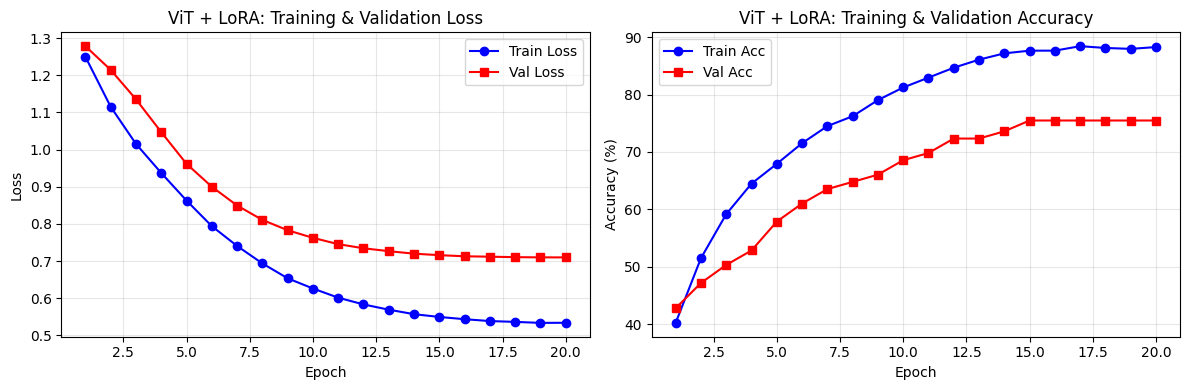

💾 Training history plot disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/plots/vit_lora_training_history.png


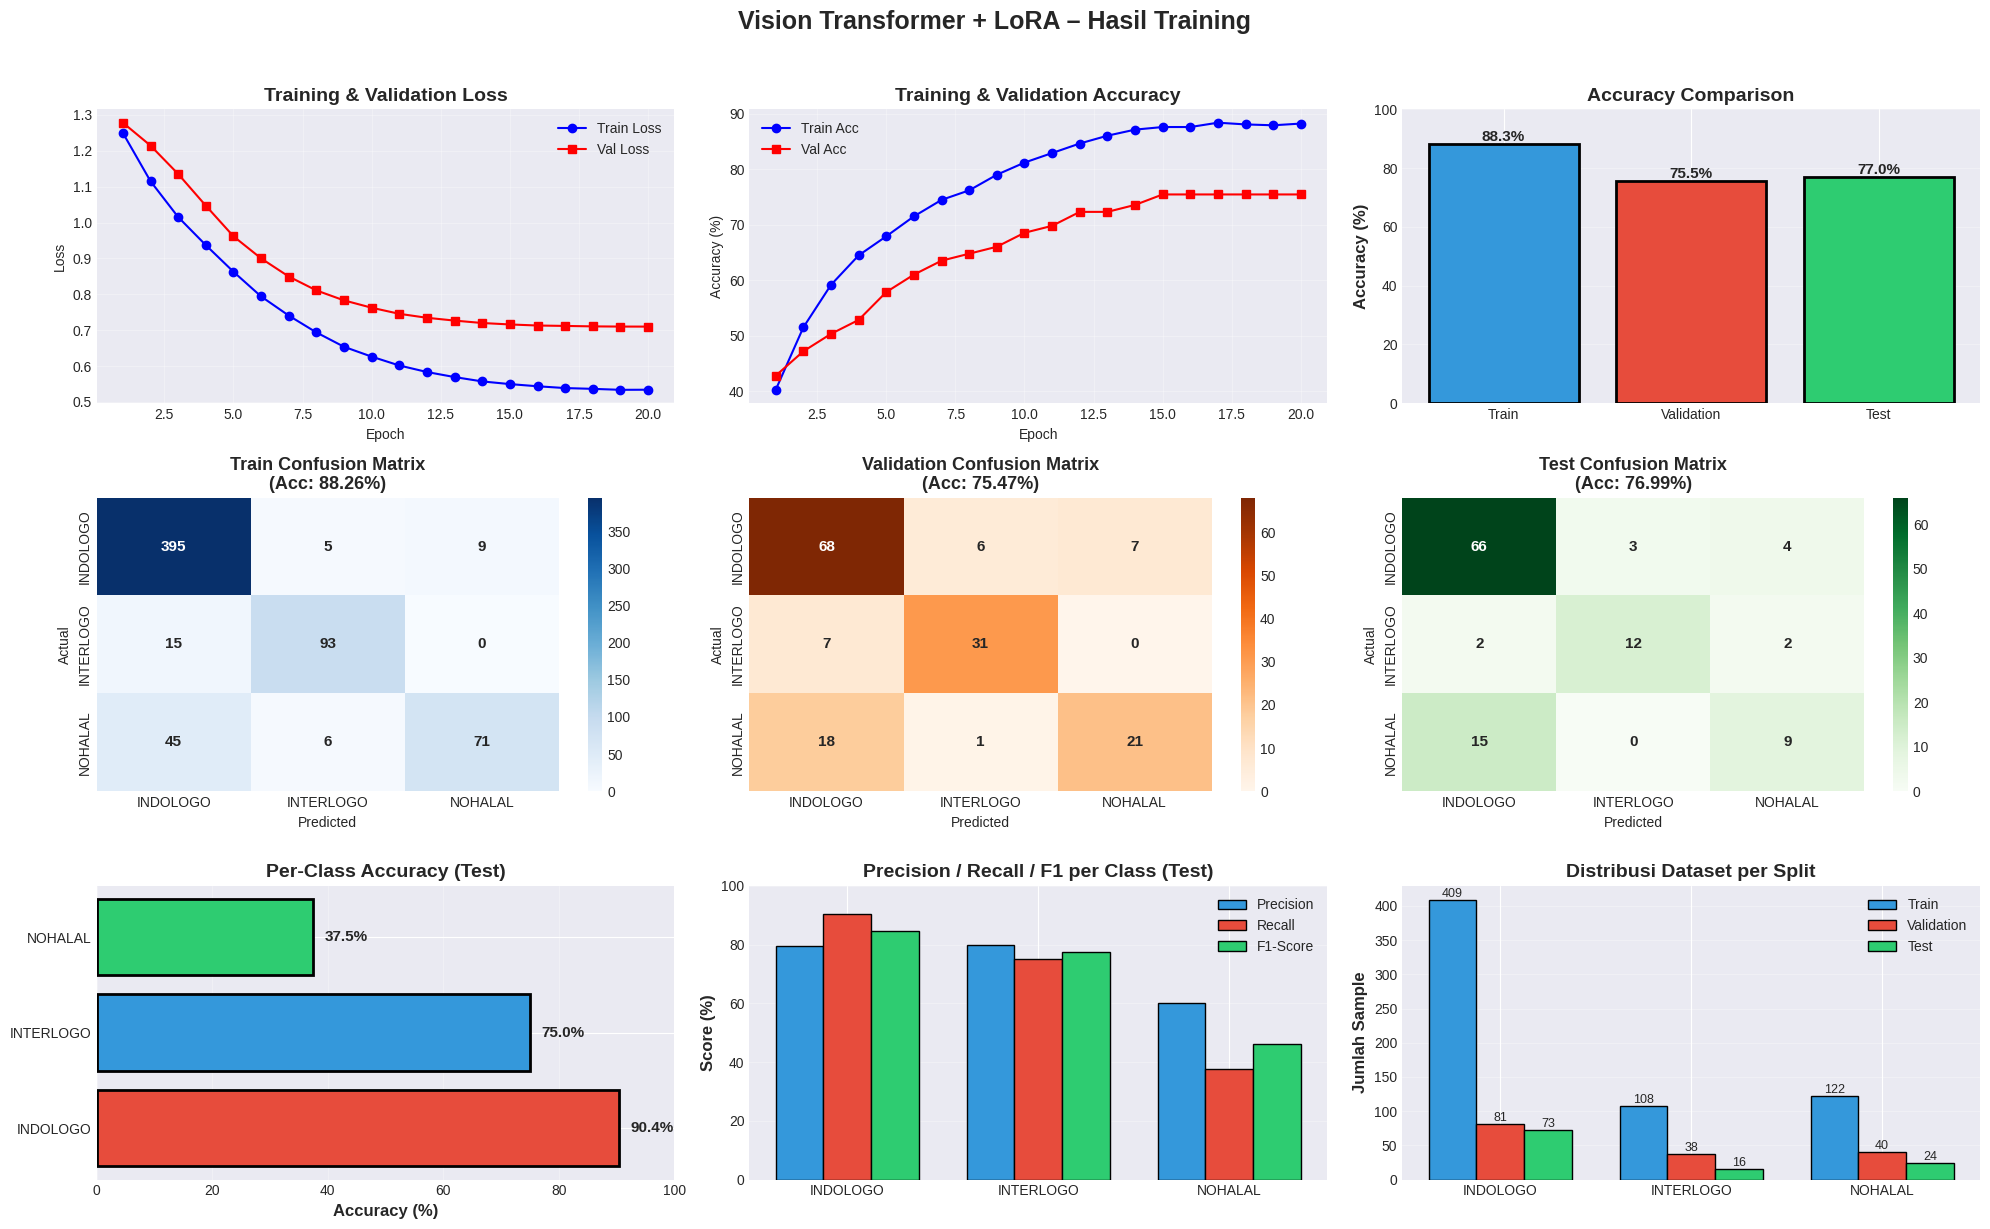

💾 Comprehensive visualization disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/plots/vit_lora_comprehensive_results.png


In [ ]:
# ========================================
# CELL 6: Evaluate & Visualize Results (ViT + LoRA)
# ========================================

# Load best model
best_ckpt_path = os.path.join(VIT_LORA_MODELS_DIR, 'best_vit_lora_model.pth')
checkpoint = torch.load(best_ckpt_path, map_location=DEVICE)
vit_lora_model.load_state_dict(checkpoint['model_state_dict'])
print(f"📥 Loaded best model from: {best_ckpt_path}")

# Evaluasi di test set
test_loss, test_acc = validate(vit_lora_model, test_loader, criterion, DEVICE, desc="Test")
print(f"\n🧪 Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Fungsi untuk dapatkan semua prediksi
def get_predictions(model, loader, device, desc="Getting predictions"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

train_labels, train_preds = get_predictions(vit_lora_model, train_loader, DEVICE, desc="Pred Train")
val_labels,   val_preds   = get_predictions(vit_lora_model, valid_loader, DEVICE, desc="Pred Valid")
test_labels,  test_preds  = get_predictions(vit_lora_model, test_loader,  DEVICE, desc="Pred Test")

# ---- Plot training history (loss & acc) ----
plt.figure(figsize=(12,4))
epochs_range = range(1, len(train_losses)+1)

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs_range, val_losses,   'r-s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ViT + LoRA: Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, 'b-o', label='Train Acc')
plt.plot(epochs_range, val_accs,   'r-s', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ViT + LoRA: Training & Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
history_img_path = os.path.join(VIT_LORA_PLOTS_DIR, 'vit_lora_training_history.png')
plt.savefig(history_img_path, dpi=250, bbox_inches='tight')
plt.show()
print(f"💾 Training history plot disimpan di: {history_img_path}")

# ---- Comprehensive visualization (grid 3x3 seperti kode temanmu) ----
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 12))

# 1. Training & Validation Loss
ax1 = plt.subplot(3,3,1)
ax1.plot(epochs_range, train_losses, 'b-o', label='Train Loss')
ax1.plot(epochs_range, val_losses, 'r-s', label='Val Loss')
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.legend(); ax1.grid(True, alpha=0.3)

# 2. Training & Validation Accuracy
ax2 = plt.subplot(3,3,2)
ax2.plot(epochs_range, train_accs, 'b-o', label='Train Acc')
ax2.plot(epochs_range, val_accs, 'r-s', label='Val Acc')
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy (%)')
ax2.legend(); ax2.grid(True, alpha=0.3)

# 3. Accuracy comparison Train/Val/Test
ax3 = plt.subplot(3,3,3)
accs = [train_accs[-1], val_accs[-1], test_acc]
datasets = ['Train', 'Validation', 'Test']
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax3.bar(datasets, accs, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylim([0,100])
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for b in bars:
    h = b.get_height()
    ax3.text(b.get_x()+b.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4–6: Confusion matrix Train/Val/Test
cm_train = confusion_matrix(train_labels, train_preds)
cm_val   = confusion_matrix(val_labels,   val_preds)
cm_test  = confusion_matrix(test_labels,  test_preds)

ax4 = plt.subplot(3,3,4)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax4,
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax4.set_title(f'Train Confusion Matrix\n(Acc: {train_accs[-1]:.2f}%)', fontsize=13, fontweight='bold')
ax4.set_xlabel('Predicted'); ax4.set_ylabel('Actual')

ax5 = plt.subplot(3,3,5)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax5,
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax5.set_title(f'Validation Confusion Matrix\n(Acc: {val_accs[-1]:.2f}%)', fontsize=13, fontweight='bold')
ax5.set_xlabel('Predicted'); ax5.set_ylabel('Actual')

ax6 = plt.subplot(3,3,6)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax6,
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax6.set_title(f'Test Confusion Matrix\n(Acc: {test_acc:.2f}%)', fontsize=13, fontweight='bold')
ax6.set_xlabel('Predicted'); ax6.set_ylabel('Actual')

# 7. Per-class accuracy (test)
ax7 = plt.subplot(3,3,7)
class_accs = []
for i in range(NUM_CLASSES):
    mask = (test_labels == i)
    if mask.sum() > 0:
        ca = (test_preds[mask] == test_labels[mask]).sum() / mask.sum() * 100
    else:
        ca = 0.0
    class_accs.append(ca)
bars = ax7.barh(CLASS_NAMES, class_accs,
                color=['#e74c3c', '#3498db', '#2ecc71'],
                edgecolor='black', linewidth=2)
ax7.set_xlim([0,100])
ax7.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Per-Class Accuracy (Test)', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')
for i,(b,a) in enumerate(zip(bars, class_accs)):
    ax7.text(a+2, i, f'{a:.1f}%', va='center', fontsize=11, fontweight='bold')

# 8. Precision / Recall / F1 per class (test)
ax8 = plt.subplot(3,3,8)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=None)
x = np.arange(NUM_CLASSES)
w = 0.25
b1 = ax8.bar(x - w, precision*100, w, label='Precision', color='#3498db', edgecolor='black')
b2 = ax8.bar(x,       recall*100,   w, label='Recall',   color='#e74c3c', edgecolor='black')
b3 = ax8.bar(x + w,   f1*100,       w, label='F1-Score', color='#2ecc71', edgecolor='black')
ax8.set_xticks(x); ax8.set_xticklabels(CLASS_NAMES)
ax8.set_ylim([0,100])
ax8.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax8.set_title('Precision / Recall / F1 per Class (Test)', fontsize=14, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3, axis='y')

# 9. Distribusi sample Train/Val/Test per kelas
ax9 = plt.subplot(3,3,9)
train_dist = [np.sum(train_labels == i) for i in range(NUM_CLASSES)]
val_dist   = [np.sum(val_labels   == i) for i in range(NUM_CLASSES)]
test_dist  = [np.sum(test_labels  == i) for i in range(NUM_CLASSES)]
x = np.arange(NUM_CLASSES)
w = 0.25
b1 = ax9.bar(x - w, train_dist, w, label='Train',      color='#3498db', edgecolor='black')
b2 = ax9.bar(x,     val_dist,   w, label='Validation', color='#e74c3c', edgecolor='black')
b3 = ax9.bar(x + w, test_dist,  w, label='Test',       color='#2ecc71', edgecolor='black')
ax9.set_xticks(x); ax9.set_xticklabels(CLASS_NAMES)
ax9.set_ylabel('Jumlah Sample', fontsize=12, fontweight='bold')
ax9.set_title('Distribusi Dataset per Split', fontsize=14, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3, axis='y')
for bars in [b1,b2,b3]:
    for b in bars:
        h = b.get_height()
        ax9.text(b.get_x()+b.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Vision Transformer + LoRA – Hasil Training', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
comp_path = os.path.join(VIT_LORA_PLOTS_DIR, 'vit_lora_comprehensive_results.png')
plt.savefig(comp_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Comprehensive visualization disimpan di: {comp_path}")

In [ ]:
# ========================================
# SIMPAN METRIK VIT + LoRA UNTUK VISUALISASI MASTER (Keras)
# ========================================

# Hitung weighted metrics di test set
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted'
)

vit_lora_metrics_path = os.path.join(VIT_LORA_HISTORY_DIR, "vit_lora_test_metrics.npz")
np.savez(
    vit_lora_metrics_path,
    test_acc=test_acc/100.0,     # ubah ke 0–1 supaya konsisten dengan model lain
    test_loss=test_loss,
    precision_w=precision_w,
    recall_w=recall_w,
    f1_w=f1_w
)
print(f"💾 Metrik ViT + LoRA untuk master visualisation disimpan di: {vit_lora_metrics_path}")

💾 Metrik ViT + LoRA untuk master visualisation disimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/history/vit_lora_test_metrics.npz


## CELL 7: Detailed Report & Analysis

In [ ]:
# ========================================
# CELL 7: Detailed Report & Analysis (template)
# ========================================

print("Silakan tambahkan cell Markdown setelah ini untuk laporan.\n")
print("Contoh poin analisis yang bisa kamu tulis:")

print(f"""
1. Ringkasan performa ViT + LoRA:
   - Best Validation Accuracy : {best_val_acc:.2f}%
   - Test Accuracy            : {test_acc:.2f}%
   - Overfitting gap (Train - Val terakhir): {train_accs[-1] - val_accs[-1]:.2f}%

2. Perbandingan antar kelas:
   - Tulis dari confusion matrix: kelas mana yang paling sulit dibedakan (misal INTERLOGO vs INDOLOGO).
   - Jelaskan apakah distribusi dataset yang tidak seimbang mempengaruhi hasil.

3. Pengaruh LoRA:
   - Jelaskan bahwa yang di-fine-tune hanya subset parameter (attention qkv) sehingga:
     * Lebih hemat memori
     * Training lebih cepat dibanding full fine-tuning ViT
   - Hubungkan dengan hasil (apakah akurasi sudah cukup baik mengingat dataset relatif kecil).

4. Perbandingan dengan CNN (dari eksperimen sebelumnya):
   - Bandingkan Test Accuracy ViT+LoRA vs CNN Klasik, CNN Augmentasi, dan CNN + LoRA.
   - Sebutkan kelebihan/kelemahan: ViT biasanya lebih kuat untuk data besar, tapi di dataset kecil bisa overfit.

5. Saran pengembangan lanjutan:
   - Tambah augmentasi (RandomResizedCrop, ColorJitter).
   - Coba rank LoRA yang berbeda (r=2,4,8) dan lihat trade-off performa vs parameter.
   - Coba backbone ViT yang lebih kecil (misal vit_small) jika resource terbatas.
""")

Silakan tambahkan cell Markdown setelah ini untuk laporan.

Contoh poin analisis yang bisa kamu tulis:

1. Ringkasan performa ViT + LoRA:
   - Best Validation Accuracy : 75.47%
   - Test Accuracy            : 76.99%
   - Overfitting gap (Train - Val terakhir): 12.79%

2. Perbandingan antar kelas:
   - Tulis dari confusion matrix: kelas mana yang paling sulit dibedakan (misal INTERLOGO vs INDOLOGO).
   - Jelaskan apakah distribusi dataset yang tidak seimbang mempengaruhi hasil.

3. Pengaruh LoRA:
   - Jelaskan bahwa yang di-fine-tune hanya subset parameter (attention qkv) sehingga:
     * Lebih hemat memori
     * Training lebih cepat dibanding full fine-tuning ViT
   - Hubungkan dengan hasil (apakah akurasi sudah cukup baik mengingat dataset relatif kecil).

4. Perbandingan dengan CNN (dari eksperimen sebelumnya):
   - Bandingkan Test Accuracy ViT+LoRA vs CNN Klasik, CNN Augmentasi, dan CNN + LoRA.
   - Sebutkan kelebihan/kelemahan: ViT biasanya lebih kuat untuk data besar, tapi di dat

#**5.Explainable AI (XAI)**

> Pengujian ini berdasarkan pengujian penggunaan model terbaik yaitu CNN_Klasik & LoRA, sehingga di jadikan untuk pengujian XAI berikut:

**Noted:** [Sebelum menjalankan program dibawah ini, anda wajib menjalankan CELL 1 & Bagian CNN_Klasik + LoRA.]

In [ ]:
# ========================================
# CELL: Simple train/val generator (no aug)
# ========================================

train_dir = os.path.join(CLASSIFICATION_DATASET_DIR, 'train')
val_dir   = os.path.join(CLASSIFICATION_DATASET_DIR, 'val')

simple_datagen = ImageDataGenerator(rescale=1./255)

train_simple_gen = simple_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_simple_gen = simple_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("✅ Simple generators for CNN Klasik + LoRA are ready.")

## 2. XAI untuk CNN_Klasik_LoRA (Grad‑CAM) + Narasi Laporan
Di laporan, dosenmu minta analisis XAI dari model terbaik (CNN_Klasik_LoRA). Pendekatan yang paling umum dan mudah: Grad‑CAM (heatmap perhatian) di layer konvolusional terakhir.

> 2.1. Kode Grad‑CAM untuk CNN_Klasik_LoRA
Setelah kamu load model terbaik:

In [16]:
# ========================================
# CELL: Load best CNN_Klasik_LoRA
# ========================================

best_lora_path = os.path.join(CNN_CLASSIC_LORA_DIR, 'models', 'cnn_classic_lora_best.h5')
cnn_classic_lora = tf.keras.models.load_model(best_lora_path)
print("✅ Loaded best CNN_Klasik_LoRA from:", best_lora_path)

✅ Loaded best CNN_Klasik_LoRA from: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/models/cnn_classic_lora_best.h5


In [17]:
# ========================================
# CELL: Grad-CAM helper for CNN_Klasik_LoRA
# ========================================

import cv2

def get_img_array(img_path, size):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(size)
    x = np.array(img) / 255.0
    return np.expand_dims(x, axis=0), img  # (1,H,W,3), PIL image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient w.r.t. feature map
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

def save_gradcam_overlay(
    img_path,
    heatmap,
    output_path,
    alpha=0.4
):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1,3,3); plt.imshow(superimposed_img); plt.axis("off"); plt.title("Overlay")
    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.close()
    print("💾 Saved Grad-CAM overlay:", output_path)

In [22]:
import os

test_img_dir = "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images"
for f in os.listdir(test_img_dir):
    if "IMG_20250719_192354" in f or "IMG_20250726_172331" in f:
        print(f)

IMG_20250719_192354_jpg.rf.4ee91be4476e3e0497c52bbfabd15fc4.jpg
IMG_20250726_172331_jpg.rf.abdd8b7b44d2671710fa1375cb5cb034.jpg


In [25]:
# ========================================
# CELL: Generate Grad-CAM samples for each class
# ========================================

XAI_DIR = os.path.join(CNN_CLASSIC_LORA_DIR, 'xai')
os.makedirs(XAI_DIR, exist_ok=True)

last_conv_name = 'conv3_1'

sample_paths = {
    "INDOLOGO": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/IMG_20250719_192354_jpg.rf.4ee91be4476e3e0497c52bbfabd15fc4.jpg",
    "INTERLOGO": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/interhalal1241_jpg.rf.df90ad367fc3a778b10b88b2f46de7af.jpg",
    "NOHALAL": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/IMG_20250726_172331_jpg.rf.abdd8b7b44d2671710fa1375cb5cb034.jpg",
}

for cls_name, img_path in sample_paths.items():
    assert os.path.exists(img_path), f"Path tidak ditemukan: {img_path}"
    img_array, _ = get_img_array(img_path, IMG_SIZE)
    heatmap = make_gradcam_heatmap(img_array, cnn_classic_lora, last_conv_name)
    out_path = os.path.join(XAI_DIR, f"gradcam_{cls_name}.png")
    save_gradcam_overlay(img_path, heatmap, out_path)

💾 Saved Grad-CAM overlay: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_INDOLOGO.png
💾 Saved Grad-CAM overlay: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_INTERLOGO.png
💾 Saved Grad-CAM overlay: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_NOHALAL.png


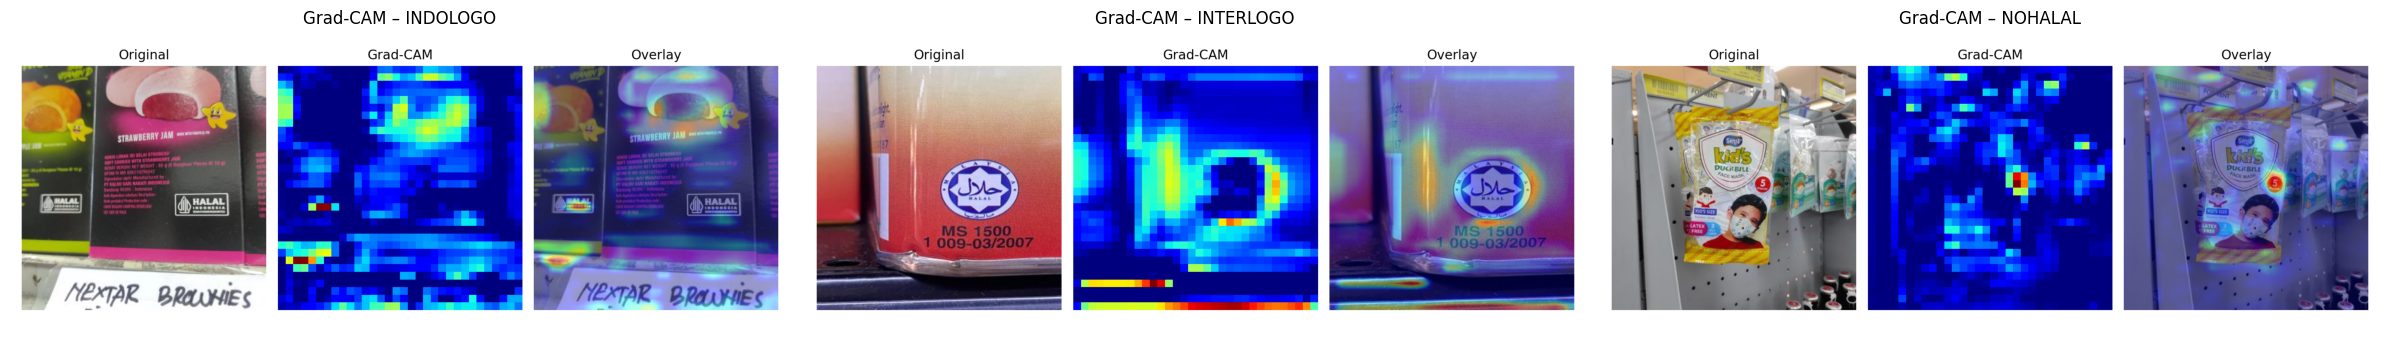

In [28]:
# ========================================
# CELL: Tampilkan hasil Grad-CAM
# ========================================

plt.figure(figsize=(24, 16))

for i, cls_name in enumerate(sample_paths.keys()):
    img = plt.imread(os.path.join(XAI_DIR, f"gradcam_{cls_name}.png"))
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Grad-CAM – {cls_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Menampilkan hasil Secara Spesifik

💾 Saved Grad-CAM overlay only: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_overlay_INDOLOGO.png
💾 Saved Grad-CAM overlay only: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_overlay_INTERLOGO.png
💾 Saved Grad-CAM overlay only: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/gradcam_overlay_NOHALAL.png


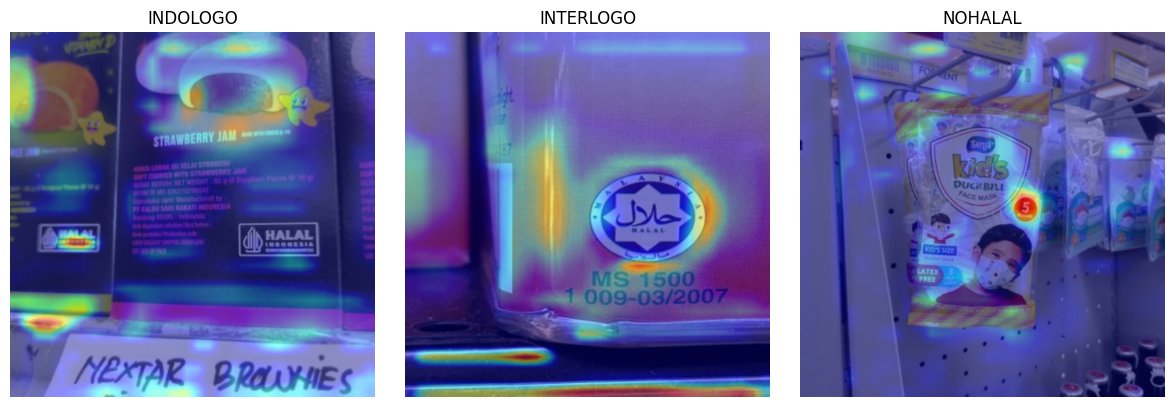

In [30]:
# ========================================
# CELL: Generate Grad-CAM OVERLAY per kelas
#        (1 file PNG per kelas, siap untuk poster)
# ========================================

import cv2

XAI_DIR = os.path.join(CNN_CLASSIC_LORA_DIR, 'xai')
os.makedirs(XAI_DIR, exist_ok=True)

last_conv_name = 'conv3_1'

sample_paths = {
    "INDOLOGO": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/IMG_20250719_192354_jpg.rf.4ee91be4476e3e0497c52bbfabd15fc4.jpg",
    "INTERLOGO": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/interhalal1241_jpg.rf.df90ad367fc3a778b10b88b2f46de7af.jpg",
    "NOHALAL": "/content/drive/MyDrive/Machine-Learning-Experiment/datasets/namaikna-2/test/images/IMG_20250726_172331_jpg.rf.abdd8b7b44d2671710fa1375cb5cb034.jpg",
}

def save_gradcam_overlay_only(img_path, heatmap, output_path, alpha=0.45):
    """Simpan hanya overlay (original + heatmap), tanpa panel multi-subplot."""
    # Baca citra asli (BGR)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap ke ukuran gambar asli
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(4, 4))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    print("💾 Saved Grad-CAM overlay only:", output_path)

# Generate overlay untuk setiap kelas
overlay_files = {}
for cls_name, img_path in sample_paths.items():
    assert os.path.exists(img_path), f"Path tidak ditemukan: {img_path}"
    img_array, _ = get_img_array(img_path, IMG_SIZE)
    heatmap = make_gradcam_heatmap(img_array, cnn_classic_lora, last_conv_name)
    out_path = os.path.join(XAI_DIR, f"gradcam_overlay_{cls_name}.png")
    save_gradcam_overlay_only(img_path, heatmap, out_path)
    overlay_files[cls_name] = out_path

overlay_files

# ========================================
# CELL: Tampilkan overlay Grad-CAM semua kelas
# ========================================

plt.figure(figsize=(12, 4))

for i, cls_name in enumerate(["INDOLOGO", "INTERLOGO", "NOHALAL"]):
    img = plt.imread(overlay_files[cls_name])
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(cls_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Pengujian Secara Acak Menggunakan XAI:

In [31]:
import random
from glob import glob

# ========================================
# CELL: Utility untuk sampling acak + XAI
# ========================================

# Misal struktur dataset klasifikasi:
TEST_DIR = os.path.join(CLASSIFICATION_DATASET_DIR, 'test')  # ganti kalau beda
CLASS_LABELS = ["INDOLOGO", "INTERLOGO", "NOHALAL"]          # urut sesuai class_indices generator kamu

def get_random_test_samples_per_class(test_dir, classes, n_per_class=3):
    """
    Mengambil n_per_class gambar acak per kelas dari folder test/class_name/*.*
    """
    samples = []
    for cls in classes:
        class_dir = os.path.join(test_dir, cls)
        all_files = glob(os.path.join(class_dir, "*.*"))
        if len(all_files) == 0:
            print(f"⚠️ Tidak ada file di: {class_dir}")
            continue
        chosen = random.sample(all_files, min(n_per_class, len(all_files)))
        for f in chosen:
            samples.append((cls, f))
    return samples

def predict_with_model(model, img_array):
    """Prediksi 1 gambar (1,H,W,3) -> label_idx, prob, vector probs."""
    preds = model.predict(img_array, verbose=0)[0]
    idx = np.argmax(preds)
    return idx, preds[idx], preds

def plot_xai_result(img_path, true_label, pred_label, pred_prob, heatmap, save_path=None):
    """Tampilkan dan/atau simpan hasil XAI (original + overlay) untuk 1 sampel."""
    # Baca asli
    import cv2
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(heatmap_color, 0.45, img, 0.55, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    title = f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0)
        print("💾 Saved XAI sample:", save_path)
        plt.close()
    else:
        plt.show()

In [32]:
# ========================================
# CELL: Eksperimen XAI – sampel acak per kelas
# ========================================

XAI_RANDOM_DIR = os.path.join(CNN_CLASSIC_LORA_DIR, 'xai', 'random_samples')
os.makedirs(XAI_RANDOM_DIR, exist_ok=True)

last_conv_name = "conv3_1"

# ambil 3 sampel acak per kelas (bisa kamu ubah nilainya)
random_samples = get_random_test_samples_per_class(TEST_DIR, CLASS_LABELS, n_per_class=3)

results_summary = []

for true_cls, img_path in random_samples:
    # prepare image
    img_array, _ = get_img_array(img_path, IMG_SIZE)

    # prediction
    pred_idx, pred_prob, vec = predict_with_model(cnn_classic_lora, img_array)
    pred_cls = CLASS_LABELS[pred_idx]

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, cnn_classic_lora, last_conv_name)

    # save & display overlay
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    save_path = os.path.join(
        XAI_RANDOM_DIR,
        f"xai_{true_cls}_pred-{pred_cls}_{base_name}.png"
    )

    plot_xai_result(
        img_path=img_path,
        true_label=true_cls,
        pred_label=pred_cls,
        pred_prob=pred_prob,
        heatmap=heatmap,
        save_path=save_path
    )

    # simpan ringkasan untuk analisis
    results_summary.append({
        "file": base_name,
        "true": true_cls,
        "pred": pred_cls,
        "prob": float(pred_prob)
    })

len(results_summary)

💾 Saved XAI sample: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_samples/xai_INDOLOGO_pred-INDOLOGO_indohalal214_jpg.rf.a77368228d4724a8c88757fa82ba0036_0.png
💾 Saved XAI sample: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_samples/xai_INDOLOGO_pred-INDOLOGO_IMG_20250719_192200_jpg.rf.b4cab177473a48fa501a3f0e824a3e87_2.png
💾 Saved XAI sample: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_samples/xai_INDOLOGO_pred-INDOLOGO_indohalal521_jpg.rf.34ec5de3edadfc9238508057e80753f7_0.png
💾 Saved XAI sample: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_samples/xai_INTERLOGO_pred-INDOLOGO_interhalal182_jpg.rf.eadeed457a60001a5cf03c87ba13155b_0.png
💾 Saved XAI sample: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_sampl

9

In [33]:
import pandas as pd

df_xai = pd.DataFrame(results_summary)
df_xai

file       true       pred  \
0  indohalal214_jpg.rf.a77368228d4724a8c88757fa82...   INDOLOGO   INDOLOGO   
1  IMG_20250719_192200_jpg.rf.b4cab177473a48fa501...   INDOLOGO   INDOLOGO   
2  indohalal521_jpg.rf.34ec5de3edadfc9238508057e8...   INDOLOGO   INDOLOGO   
3  interhalal182_jpg.rf.eadeed457a60001a5cf03c87b...  INTERLOGO   INDOLOGO   
4  interhalal1527_jpg.rf.bfec65ad7d6dc675384005df...  INTERLOGO  INTERLOGO   
5  interhalal1569_jpg.rf.2d71f0a009515b080197e609...  INTERLOGO  INTERLOGO   
6  nohalal171_jpg.rf.c92c5bda01196f10e4d4933d930b...    NOHALAL   INDOLOGO   
7  IMG_20250726_172202_jpg.rf.ed737e4f54c6060a025...    NOHALAL    NOHALAL   
8  nohalal30_jpg.rf.aaa180ddde4433c161874045707c8...    NOHALAL    NOHALAL   

       prob  
0  0.976146  
1  0.950793  
2  0.998772  
3  0.984784  
4  0.999999  
5  0.987874  
6  0.458925  
7  0.894175  
8  0.976061

In [34]:
# berapa yang benar vs salah di sampel XAI
df_xai["correct"] = df_xai["true"] == df_xai["pred"]
df_xai["correct"].value_counts()

correct
True     7
False    2
Name: count, dtype: int64

In [35]:
df_xai.groupby(["true", "pred"]).size()

true       pred     
INDOLOGO   INDOLOGO     3
INTERLOGO  INDOLOGO     1
           INTERLOGO    2
NOHALAL    INDOLOGO     1
           NOHALAL      2
dtype: int64

> Gabungan dan Hasil Citrannya.

In [36]:
# ========================================
# CELL: Eksperimen XAI – sampel acak per kelas
#        + tampilkan gambar overlay
# ========================================

import random
from glob import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# --- KONFIGURASI PATH & LABEL ---
TEST_DIR = os.path.join(CLASSIFICATION_DATASET_DIR, 'test')  # ganti jika berbeda
CLASS_LABELS = ["INDOLOGO", "INTERLOGO", "NOHALAL"]
last_conv_name = "conv3_1"

XAI_RANDOM_DIR = os.path.join(CNN_CLASSIC_LORA_DIR, 'xai', 'random_samples')
os.makedirs(XAI_RANDOM_DIR, exist_ok=True)


# --- FUNGSI BANTU ---

def get_random_test_samples_per_class(test_dir, classes, n_per_class=3):
    samples = []
    for cls in classes:
        class_dir = os.path.join(test_dir, cls)
        all_files = glob(os.path.join(class_dir, "*.*"))
        if len(all_files) == 0:
            print(f"⚠️ Tidak ada file di: {class_dir}")
            continue
        chosen = random.sample(all_files, min(n_per_class, len(all_files)))
        for f in chosen:
            samples.append((cls, f))
    return samples

def predict_with_model(model, img_array):
    preds = model.predict(img_array, verbose=0)[0]
    idx = np.argmax(preds)
    return idx, preds[idx], preds

def plot_xai_result(img_path, true_label, pred_label, pred_prob, heatmap, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(heatmap_color, 0.45, img, 0.55, 0)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    title = f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
    else:
        plt.show()


# --- EKSEKUSI: SAMPEL ACAK + XAI ---

random_samples = get_random_test_samples_per_class(TEST_DIR, CLASS_LABELS, n_per_class=3)

results_summary = []
overlay_paths = []  # untuk ditampilkan lagi di satu grid

for true_cls, img_path in random_samples:
    img_array, _ = get_img_array(img_path, IMG_SIZE)

    pred_idx, pred_prob, vec = predict_with_model(cnn_classic_lora, img_array)
    pred_cls = CLASS_LABELS[pred_idx]

    heatmap = make_gradcam_heatmap(img_array, cnn_classic_lora, last_conv_name)

    base_name = os.path.splitext(os.path.basename(img_path))[0]
    save_path = os.path.join(
        XAI_RANDOM_DIR,
        f"xai_{true_cls}_pred-{pred_cls}_{base_name}.png"
    )

    plot_xai_result(
        img_path=img_path,
        true_label=true_cls,
        pred_label=pred_cls,
        pred_prob=pred_prob,
        heatmap=heatmap,
        save_path=save_path
    )

    overlay_paths.append((true_cls, pred_cls, pred_prob, save_path))

    results_summary.append({
        "file": base_name,
        "true": true_cls,
        "pred": pred_cls,
        "prob": float(pred_prob)
    })

df_xai = pd.DataFrame(results_summary)
print(df_xai)
print("\nCorrect counts:")
print((df_xai["true"] == df_xai["pred"]).value_counts())

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_image']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


                                                file       true       pred  \
0  indohalal529_jpg.rf.ebd88fbf7f1e59f98e06bf8044...   INDOLOGO   INDOLOGO   
1  nohalal116_jpg.rf.3b589607574ef2118a1e34509fbb...   INDOLOGO   INDOLOGO   
2  indohalal39_jpg.rf.025909dce0c96957a0870447fcb...   INDOLOGO   INDOLOGO   
3  interhalal1496_jpg.rf.49d428be0f3547207c41ec57...  INTERLOGO  INTERLOGO   
4  interhalal702_jpg.rf.4b3c4f8ccba25c8ca30ede282...  INTERLOGO   INDOLOGO   
5  interhalal1569_jpg.rf.2d71f0a009515b080197e609...  INTERLOGO  INTERLOGO   
6  IMG_20250726_171052_jpg.rf.984cce39f7643943112...    NOHALAL    NOHALAL   
7  nohalal177_jpg.rf.fc79019a6be3ab0af3e684e5009b...    NOHALAL    NOHALAL   
8  nohalal115_jpg.rf.d4570cbd0058cd65ff75c5ab39e5...    NOHALAL   INDOLOGO   

       prob  
0  0.999886  
1  0.992493  
2  0.962803  
3  0.746816  
4  0.412333  
5  0.987874  
6  0.997859  
7  0.988668  
8  0.939174  

Correct counts:
True     7
False    2
Name: count, dtype: int64


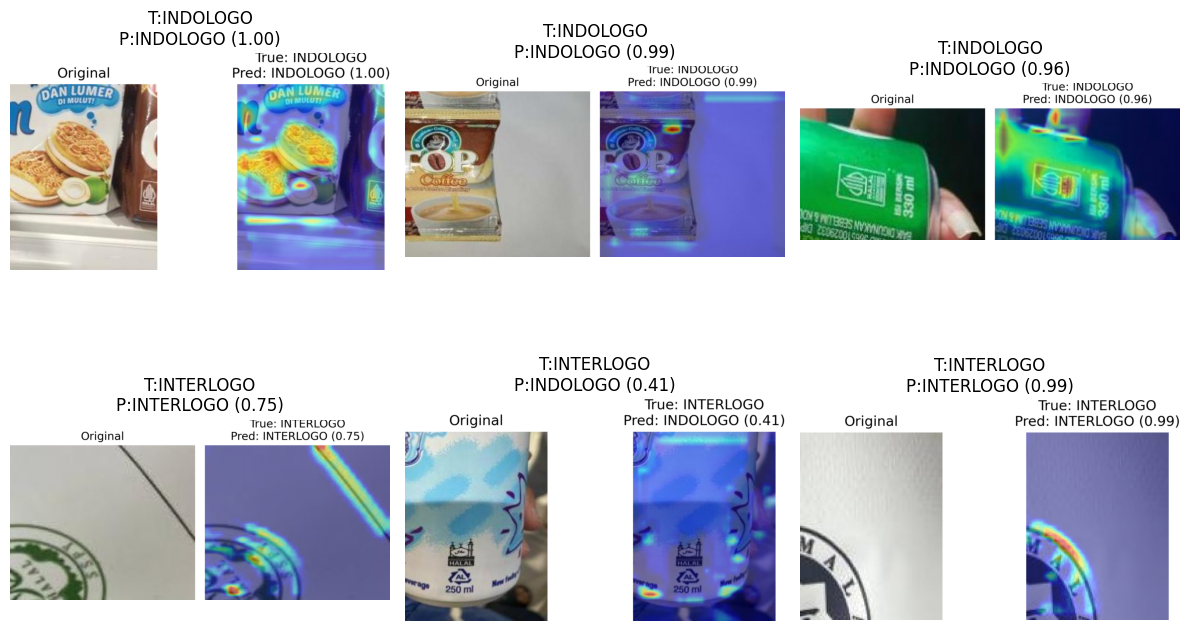

💾 Saved XAI random grid: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/CNN_Klasik_LoRA/xai/random_samples/xai_random_grid.png


In [37]:
# ========================================
# CELL: Tampilkan grid XAI random samples
# ========================================

n_show = min(6, len(overlay_paths))  # tampilkan maks 6 contoh
cols = 3
rows = int(np.ceil(n_show / cols))

plt.figure(figsize=(4*cols, 4*rows))

for i, (true_cls, pred_cls, prob, path) in enumerate(overlay_paths[:n_show]):
    img = plt.imread(path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    title = f"T:{true_cls}\nP:{pred_cls} ({prob:.2f})"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
combined_rand_path = os.path.join(XAI_RANDOM_DIR, "xai_random_grid.png")
plt.savefig(combined_rand_path, dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

print("💾 Saved XAI random grid:", combined_rand_path)

# 6.Visualisasi Besar – Semua Model (untuk Poster)

**Tujuan:** Meringkas hasil evaluasi dari keenam model untuk perbandingan yang jelas dan visual.

---

## Ringkasan Model yang Dievaluasi

Kita telah melatih dan mengevaluasi 6 model dengan berbagai arsitektur dan teknik:

1.  **CNN_Klasik:** CNN sederhana tanpa augmentasi atau LoRA.
2.  **CNN_Augmentasi:** CNN sederhana dengan Augmentasi Data.
3.  **CNN_Klasik_LoRA:** CNN sederhana dengan adaptasi LoRA.
4.  **CNN_Augmentasi_LoRA:** CNN sederhana dengan Augmentasi Data dan LoRA.
5.  **ViT_Manual_LoRA:** Vision Transformer (ViT) yang dilatih dari awal dengan LoRA.
6.  **ViT_Pretrained_LoRA:** ViT *Pretrained* (*fine-tuning*) dengan adaptasi LoRA.

---

## Visualisasi Kunci untuk Poster

Visualisasi berikut akan dibuat untuk memberikan perbandingan komprehensif:

### 1. Perbandingan Akurasi Uji (**Test Accuracy**)

* **Jenis:** **Bar Chart**
* **Tujuan:** Menampilkan Akurasi Uji Akhir dari keenam model secara berdampingan. Visual ini paling cepat menunjukkan model mana yang memiliki kinerja terbaik secara keseluruhan.

### 2. Peta Kinerja Multi-Metrik

* **Jenis:** **Radar Chart** (Satu diagram, setiap model adalah satu 'jaring')
* **Tujuan:** Membandingkan **Precision, Recall, dan F1-Score** secara visual per model. Ini membantu menilai *trade-off* dan kekuatan/kelemahan model di luar Akurasi Uji.

### 3. Matriks Perbandingan Metrik (Opsional/Pendukung)

* **Jenis:** **Heatmap** (Matriks 6 Model x 3 Metrik: Precision, Recall, F1)
* **Tujuan:** Menyajikan nilai-nilai metrik (Precision, Recall, F1) dalam format tabel yang diwarnai untuk memudahkan identifikasi nilai tertinggi/terendah di antara semua model.

---

## Big Summary Table (Tabel Ringkasan Besar)

| Model | Arsitektur | Augmentasi | LoRA | Akurasi Uji (%) | Precision | Recall | F1-Score |
| :--- | :--- | :--- | :--- | :---: | :---: | :---: | :---: |
| **CNN_Klasik** | CNN | ❌ | ❌ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |
| **CNN_Augmentasi** | CNN | ✅ | ❌ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |
| **CNN_Klasik_LoRA** | CNN | ❌ | ✅ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |
| **CNN_Augmentasi_LoRA** | CNN | ✅ | ✅ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |
| **ViT_Manual_LoRA** | ViT (Scratch) | ❌ | ✅ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |
| **ViT_Pretrained_LoRA**| ViT (Pretrained) | ❌ | ✅ | [Nilai] | [Nilai] | [Nilai] | [Nilai] |

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-370360736.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✅ Metrix ViT_LoRA loaded from: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning/ViT_LoRA/history/vit_lora_test_metrics.npz

📊 Ringkasan metrik semua model:
                     name  test_acc  test_loss  precision_w  recall_w  \
0              CNN_Klasik  0.734694   1.137781     0.726777  0.734694   
1          CNN_Augmentasi  0.659864   0.678522     0.650384  0.659864   
2         CNN_Klasik_LoRA  0.782313   1.063157     0.776901  0.782313   
3     CNN_Augmentasi_LoRA  0.741497   0.614353     0.733492  0.741497   
4         ViT_Manual_LoRA  0.687075   0.836933     0.608574  0.687075   
5  EffNet_Pretrained_LoRA  0.639456   0.887338     0.408904  0.639456   
6                ViT_LoRA  0.769912   0.919620     0.754409  0.769912   

       f1_w  
0  0.728213  
1  0.651553  
2  0.776274  
3  0.736143  
4  0.606015  
5  0.498829  
6  0.754277  

🏆 Best model berdasarkan Test Accuracy: CNN_Klasik_LoRA (0.7823)


/tmp/ipython-input-370360736.py:123: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-370360736.py:124: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_test_accuracy.png"), dpi=200)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


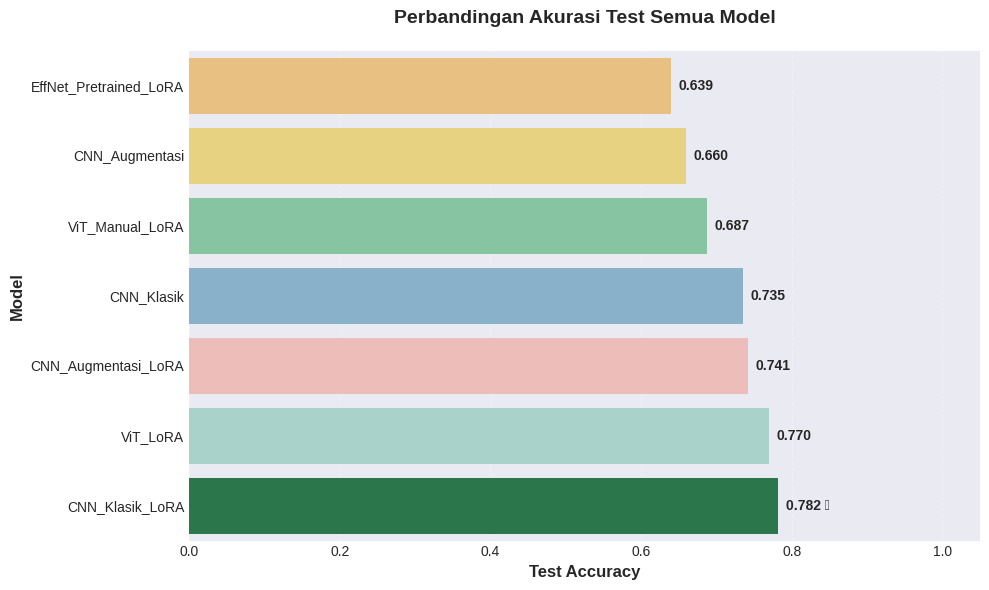

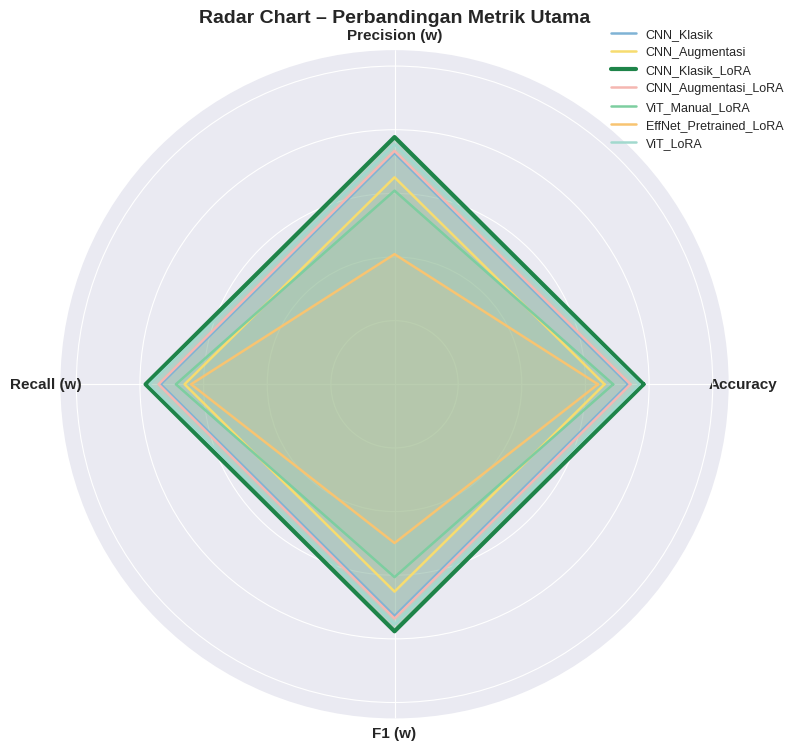

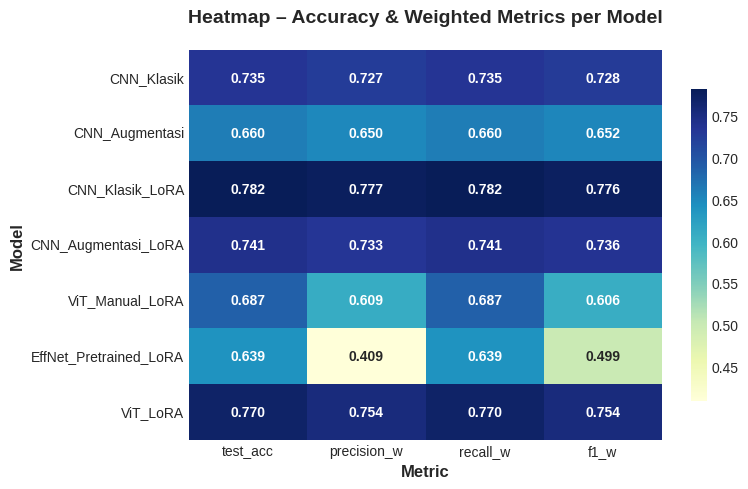

/tmp/ipython-input-370360736.py:218: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_summary_table.png"), dpi=200)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


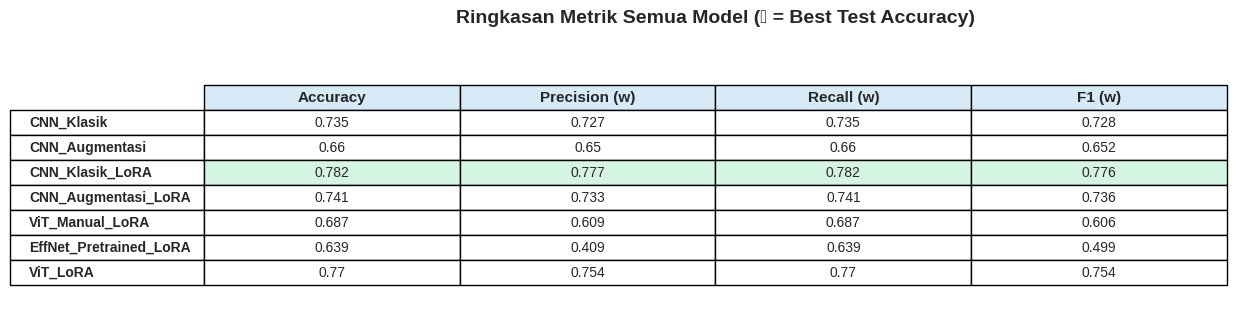


✅ Visualisasi besar semua model tersimpan di: /content/drive/MyDrive/Machine-Learning-Experiment/results/5_Deep_Learning
🏆 Model dengan Test Accuracy terbaik: CNN_Klasik_LoRA


In [ ]:
# ========================================
# MASTER VISUALISATION – ALL MODELS (+ ViT_LoRA)
# ========================================

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import pandas as pd

# 1. Load semua model Keras
cnn_classic_model.load_weights(os.path.join(CNN_CLASSIC_DIR, 'models', 'cnn_classic_best.h5'))
cnn_aug_model.load_weights(os.path.join(CNN_AUG_DIR, 'models', 'cnn_aug_best.h5'))
cnn_classic_lora.load_weights(os.path.join(CNN_CLASSIC_LORA_DIR, 'models', 'cnn_classic_lora_best.h5'))
cnn_aug_lora.load_weights(os.path.join(CNN_AUG_LORA_DIR, 'models', 'cnn_aug_lora_best.h5'))
vit_manual_lora.load_weights(os.path.join(VIT_MANUAL_LORA_DIR, 'models', 'vit_manual_lora_best.h5'))
effnet_pretrained_lora.load_weights(
    os.path.join(EffNET_PRETRAINED_LORA_DIR, 'models', 'effnet_pretrained_lora_best.h5')
)

# 2. Helper evaluasi untuk model Keras
def eval_model_keras(model, name):
    test_simple_gen.reset()
    y_true = test_simple_gen.classes
    y_prob = model.predict(test_simple_gen, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    loss, acc = model.evaluate(test_simple_gen, verbose=0)
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    return {
        "name": name,
        "test_acc": acc,
        "test_loss": loss,
        "precision_w": precision_w,
        "recall_w": recall_w,
        "f1_w": f1_w
    }

# 3. Kumpulkan hasil semua model Keras
results = []
results.append(eval_model_keras(cnn_classic_model, "CNN_Klasik"))
results.append(eval_model_keras(cnn_aug_model, "CNN_Augmentasi"))
results.append(eval_model_keras(cnn_classic_lora, "CNN_Klasik_LoRA"))
results.append(eval_model_keras(cnn_aug_lora, "CNN_Augmentasi_LoRA"))
results.append(eval_model_keras(vit_manual_lora, "ViT_Manual_LoRA"))
results.append(eval_model_keras(effnet_pretrained_lora, "EffNet_Pretrained_LoRA"))

# 4. Tambahkan hasil ViT_LoRA (PyTorch) dari file .npz
vit_lora_metrics_path = os.path.join(
    DEEP_LEARNING_DIR, "ViT_LoRA", "history", "vit_lora_test_metrics.npz"
)

if os.path.exists(vit_lora_metrics_path):
    vit_data = np.load(vit_lora_metrics_path)
    results.append({
        "name": "ViT_LoRA",
        "test_acc": float(vit_data["test_acc"]),        # 0–1
        "test_loss": float(vit_data["test_loss"]),
        "precision_w": float(vit_data["precision_w"]),
        "recall_w": float(vit_data["recall_w"]),
        "f1_w": float(vit_data["f1_w"])
    })
    print(f"✅ Metrix ViT_LoRA loaded from: {vit_lora_metrics_path}")
else:
    print(f"⚠️ File vit_lora_test_metrics.npz tidak ditemukan di: {vit_lora_metrics_path}")
    print("   ViT_LoRA tidak akan muncul di master visualisation.")

df_res = pd.DataFrame(results)
print("\n📊 Ringkasan metrik semua model:")
print(df_res)

# 5. Tentukan model dengan test_acc tertinggi (akan di-highlight)
best_row = df_res.loc[df_res["test_acc"].idxmax()]
best_model_name = best_row["name"]
print(f"\n🏆 Best model berdasarkan Test Accuracy: {best_model_name} ({best_row['test_acc']:.4f})")

# 6. Palet warna: highlight best model dengan warna kuat, lain soft
BASE_COLORS = {
    "CNN_Klasik": "#7FB3D5",
    "CNN_Augmentasi": "#F7DC6F",
    "CNN_Klasik_LoRA": "#C39BD3",
    "CNN_Augmentasi_LoRA": "#F5B7B1",
    "ViT_Manual_LoRA": "#7DCEA0",
    "EffNet_Pretrained_LoRA": "#F8C471",
    "ViT_LoRA": "#A2D9CE",  # soft teal
}

HIGHLIGHT_COLOR = "#1E8449"  # hijau tua untuk model terbaik

MODEL_COLORS = {}
for name in df_res["name"]:
    if name == best_model_name:
        MODEL_COLORS[name] = HIGHLIGHT_COLOR
    else:
        # fallback kalau nama tidak ada di BASE_COLORS
        MODEL_COLORS[name] = BASE_COLORS.get(name, "#CCCCCC")

# --------- A. BAR CHART – TEST ACCURACY --------------
plt.figure(figsize=(10, 6))
order = df_res.sort_values("test_acc")["name"].values

palette = [MODEL_COLORS[n] for n in order]

sns.barplot(
    data=df_res,
    x="test_acc",
    y="name",
    order=order,
    palette=palette
)
plt.xlabel("Test Accuracy", fontsize=12, fontweight="bold")
plt.ylabel("Model", fontsize=12, fontweight="bold")
plt.title("Perbandingan Akurasi Test Semua Model", fontsize=14, fontweight="bold", pad=20)
plt.xlim(0, 1.05)

for i, v in enumerate(df_res.set_index("name").loc[order]["test_acc"]):
    label = f"{v:.3f}"
    # Tambahkan tanda bintang di model terbaik
    if order[i] == best_model_name:
        label += " ★"
    plt.text(v + 0.01, i, label, va="center", fontsize=10, fontweight="bold")

plt.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_test_accuracy.png"), dpi=200)
plt.show()

# --------- B. RADAR CHART – 4 METRIK --------------
from math import pi

metrics = ["test_acc", "precision_w", "recall_w", "f1_w"]
labels_metrics = ["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]

num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for idx, row in df_res.iterrows():
    values = [row[m] for m in metrics]
    values += values[:1]
    color = MODEL_COLORS[row["name"]]
    alpha = 0.25 if row["name"] == best_model_name else 0.15
    lw    = 3.0  if row["name"] == best_model_name else 1.8

    ax.plot(angles, values, color=color, linewidth=lw, label=row["name"])
    ax.fill(angles, values, color=color, alpha=alpha)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels_metrics, fontsize=11, fontweight="bold")
ax.set_yticklabels([])
ax.set_ylim(0, 1.05)
plt.title("Radar Chart – Perbandingan Metrik Utama", fontsize=14, fontweight="bold", pad=20)
plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_radar_metrics.png"), dpi=200)
plt.show()

# --------- C. HEATMAP – METRICS PER MODEL --------------
df_heat = df_res.set_index("name")[["test_acc", "precision_w", "recall_w", "f1_w"]]
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_heat,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)
plt.title("Heatmap – Accuracy & Weighted Metrics per Model", fontsize=14, fontweight="bold", pad=20)
plt.xlabel("Metric", fontsize=12, fontweight="bold")
plt.ylabel("Model", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_metrics_heatmap.png"), dpi=200)
plt.show()

# --------- D. SUMMARY TABLE (untuk poster) --------------
fig, ax = plt.subplots(figsize=(11, 3.5))
ax.axis("tight")
ax.axis("off")

df_show = df_heat.copy()
df_show.columns = ["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]

cell_colors = []
for r, name in enumerate(df_show.index):
    row_colors = []
    for c in range(len(df_show.columns)):
        if name == best_model_name:
            row_colors.append("#D5F5E3")  # hijau lembut highlight
        else:
            row_colors.append("#FFFFFF")
    cell_colors.append(row_colors)

tbl = ax.table(
    cellText=df_show.round(3).values,
    rowLabels=df_show.index,
    colLabels=df_show.columns,
    cellLoc="center",
    loc="center",
    cellColours=cell_colors
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.5)

# style header
for (row, col), cell in tbl.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold", fontsize=11)
        cell.set_facecolor("#D6EAF8")
    elif col == -1:
        cell.set_text_props(weight="bold")

plt.title("Ringkasan Metrik Semua Model (★ = Best Test Accuracy)", fontsize=14, fontweight="bold", pad=20)
plt.savefig(os.path.join(DEEP_LEARNING_DIR, "all_models_summary_table.png"), dpi=200)
plt.show()

print("\n✅ Visualisasi besar semua model tersimpan di:", DEEP_LEARNING_DIR)
print(f"🏆 Model dengan Test Accuracy terbaik: {best_model_name}")

## Struktur Folder Hasil Deep Learning

```text
results/5_Deep_Learning/
├── CNN_Klasik/
│   ├── models/
│   │   └── cnn_classic_best.h5
│   ├── history/
│   └── plots/
├── CNN_Augmentasi/
│   ├── models/
│   │   └── cnn_aug_best.h5
│   ├── history/
│   └── plots/
├── CNN_Klasik_LoRA/
│   ├── models/
│   │   └── cnn_classic_lora_best.h5
│   ├── history/
│   │   └── cnn_classic_lora_history.npy
│   └── plots/
├── CNN_Augmentasi_LoRA/
│   ├── models/
│   │   └── cnn_aug_lora_best.h5
│   ├── history/
│   │   └── cnn_aug_lora_history.npy
│   └── plots/
├── ViT_Manual_LoRA/
│   ├── models/
│   │   └── vit_manual_lora_best.h5
│   ├── history/
│   │   └── vit_manual_lora_history.npy
│   └── plots/
└── EffNet_Pretrained_LoRA/
    ├── models/
    │   └── effnet_pretrained_lora_best.h5
    ├── history/
    │   └── effnet_pretrained_lora_history.npy
    └── plots/
```

## 6.Teks Pendek untuk Laporan / Poster

### Catatan Implementasi Pretrained Backbone + LoRA

Secara konsep, eksperimen ini membandingkan:

1. **CNN Klasik** dan **CNN + LoRA** (dengan/ tanpa augmentasi)
2. **ViT Manual + LoRA** (arsitektur Vision Transformer dibangun manual)
3. **EfficientNet Pretrained + LoRA**  
   Sebagai pengganti "ViT pretrained bawaan", karena pada lingkungan TensorFlow/Keras yang digunakan:
   - Paket resmi ViT pretrained (`keras.applications.vit`, `vit-keras`, `tensorflow-hub`) tidak tersedia atau tidak kompatibel.
   - Oleh karena itu, digunakan **EfficientNetB0 pretrained ImageNet** sebagai backbone vision bawaan (pretrained),
     kemudian ditambahkan **LoRA-style adapter pada classification head**.

Dengan demikian, tujuan utama eksperimen, yaitu **membandingkan model klasik, model dengan augmentasi,
serta model pretrained + LoRA pada task 3 kelas (INDOLOGO, INTERLOGO, NOHALAL)** tetap tercapai.